In [1]:
from calibrate import Calibrate

import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import os
%matplotlib inline



In [2]:
# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')
output_images = "output_images/"
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

calibrate = Calibrate(images, nx, ny)
print("Calibration Complete")

Calibration Complete


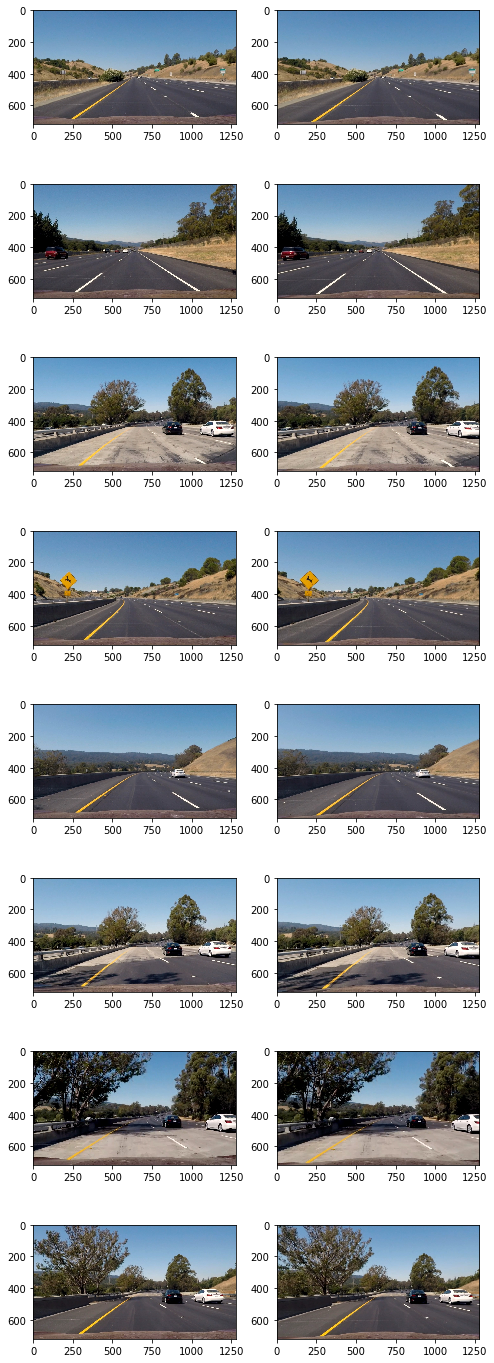

In [20]:
images = glob.glob('./test_images/*.jpg')
undistorted_images = "undistorted_images"
if not os.path.exists(output_images+undistorted_images):
    os.makedirs(output_images+undistorted_images)
undistorted_images += "/"

rows = len(images)

fig = plt.figure(figsize=(8, 25))
for i in range(rows):
    img = mpimage.imread(images[i])
    undistorted_img = calibrate.undistort(img)
    output_fname = output_images+undistorted_images+images[i].split("\\")[-1]
    cv2.imwrite(output_fname, cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2BGR))
    fig.add_subplot(rows, 2, i*2+1)
    plt.imshow(img)
    fig.add_subplot(rows, 2, i*2+2)
    #print(np.max(cv2.cvtColor(img,cv2.COLOR_RGB2HLS)[:,:,0]))
    plt.imshow(undistorted_img)
plt.show()

In [4]:
import thresholdutil as tu
def threshold_pipeline(img):
    mag_binary = tu.mag_thresh(img, mag_thresh=(70, 255))
    dir_binary = tu.dir_threshold(img, sobel_kernel=5, thresh=(0.7, 1.3))
    sx_binary = tu.abs_sobel_thresh(img, sobel_kernel=15, thresh=(70, 255))
    
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_binary = tu.binary_threshold(hls_img[:,:,2], thresh=(160, 255))
    l_binary = tu.binary_threshold(hls_img[:,:,1], thresh=(0, 85))
    h_binary = tu.binary_threshold(hls_img[:,:,0], thresh=(25, 35))
    res_bin = np.zeros_like(dir_binary)
    res_bin[(dir_binary == 1) & (mag_binary == 1)] = 1
    #res_bin[(s_binary == 1) | (sx_binary == 1)] = 1
    res_bin[(s_binary == 1)] = 1
    #res_bin[(h_binary == 1)] = 1
    res_bin[(l_binary == 1)] = 0
    
    
    return res_bin

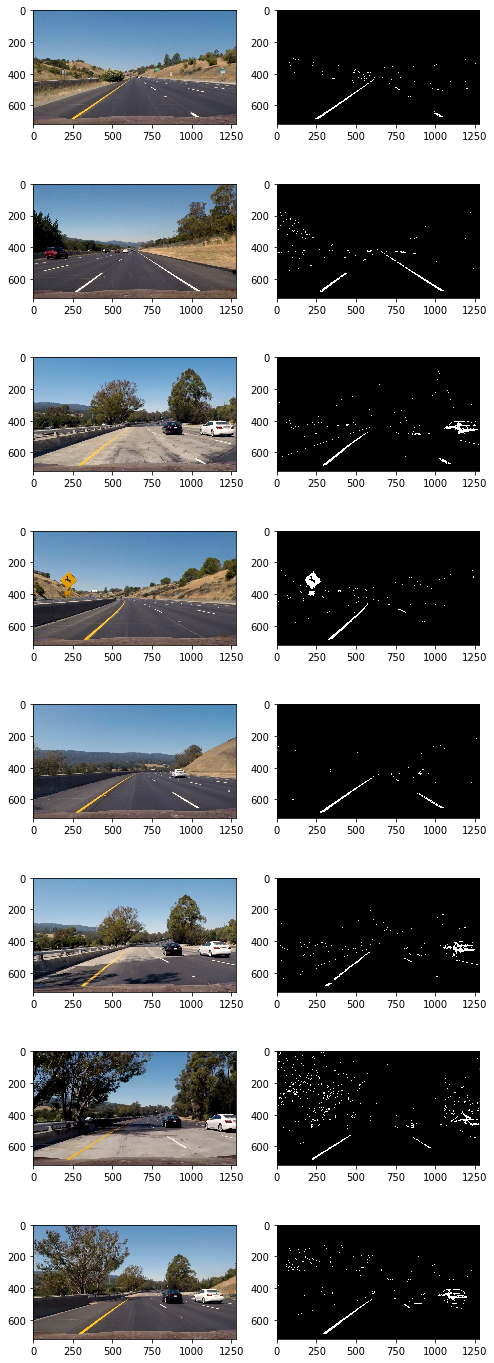

In [21]:

images = glob.glob('./test_images/*.jpg')
thresholded_images = "thresholded_images"
if not os.path.exists(output_images+thresholded_images):
    os.makedirs(output_images+thresholded_images)
thresholded_images += "/"

rows = len(images)

fig = plt.figure(figsize=(8, 25))
for i in range(rows):
    img = mpimage.imread(images[i])
    output_fname = output_images+thresholded_images+images[i].split("\\")[-1]
    
    res_bin = threshold_pipeline(img)
    output_img = np.dstack((res_bin, res_bin, res_bin))*255
    
    cv2.imwrite(output_fname, output_img)
    fig.add_subplot(rows, 2, i*2+1)
    plt.imshow(img)
    fig.add_subplot(rows, 2, i*2+2)
    plt.imshow(output_img)
plt.show()

In [6]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


In [7]:
from perspectivetransform import PerspectiveTransform
xy_bl = (230, 693)
xy_tl = (591, 450)
xy_tr = (689, 450)
xy_br = (1076, 693)
src_pts = [xy_bl, xy_tl, xy_tr, xy_br]

xy_bl = (300, 719)
xy_tl = (300, 0)
xy_tr = (980, 0)
xy_br = (980, 719)
dst_pts = [xy_bl, xy_tl, xy_tr, xy_br]
pt = PerspectiveTransform(src_pts, dst_pts)

xy_bl = (150, 720)
xy_tl = (451, 450)
xy_tr = (839, 450)
xy_br = (1130, 720)
roi_pts = np.array([[xy_bl, xy_tl, xy_tr, xy_br]])


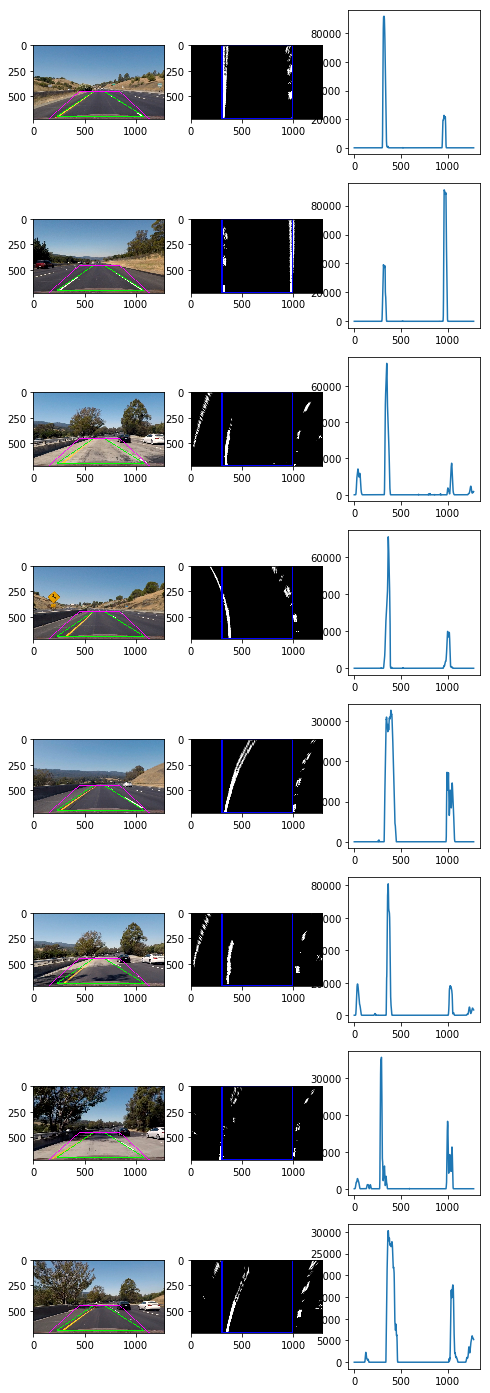

In [22]:

#images = ['./test_images/straight_lines1.jpg']
images = glob.glob('./test_images/*.jpg')
perspective_images = "perspective_images"
if not os.path.exists(output_images+perspective_images):
    os.makedirs(output_images+perspective_images)
perspective_images += "/"

rows = len(images)

fig = plt.figure(figsize=(8, 25))
for i in range(rows):
    img = mpimage.imread(images[i])
    output_fname = output_images+perspective_images+images[i].split("\\")[-1]
    output_undist_fname = output_images+perspective_images+"undist_"+images[i].split("\\")[-1]
    
    undistorted_img = calibrate.undistort(img)
    thresh_img = threshold_pipeline(undistorted_img)
    thresh_img = np.dstack((thresh_img, thresh_img, thresh_img))*255
    roi_img = region_of_interest(thresh_img,roi_pts) 
    output_undistorted_img = pt.transform(undistorted_img)
    
    output_img = pt.transform(roi_img)
    
    output_img_gray = output_img[:, :, 0]
    histogram = np.sum(output_img_gray[(output_img_gray.shape[0]//2):,:],axis=0)
    
    cv2.imwrite(output_undist_fname, cv2.cvtColor(output_undistorted_img, cv2.COLOR_RGB2BGR))
    cv2.imwrite(output_fname, cv2.cvtColor(output_img, cv2.COLOR_RGB2BGR))
    
    cv2.polylines(undistorted_img,np.array([src_pts]),True,(0,255,0),thickness=5)
    cv2.polylines(output_img,np.array([dst_pts]),True,(0,0,255),thickness=10)
    cv2.polylines(undistorted_img,roi_pts,True,(255,0,255),thickness=5)
    
    fig.add_subplot(rows, 3, i*3+1)
    plt.imshow(undistorted_img)
    fig.add_subplot(rows, 3, i*3+2)
    plt.imshow(output_img) 
    fig.add_subplot(rows, 3, i*3+3)
    plt.plot(histogram)
    
    

plt.show()

19070.244167176796

2218.7498428149383

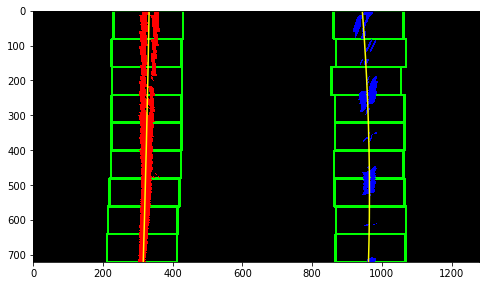

14003.754721643716

3849.250977352082

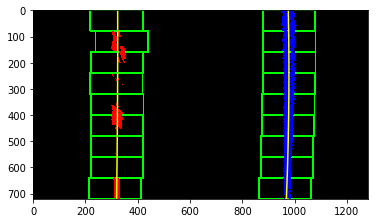

467.03967427778144

474.8897528717788

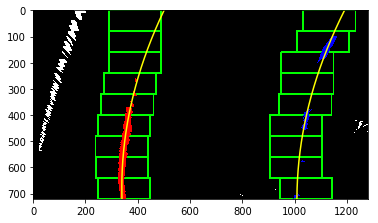

399.3690978298126

356.27609228218427

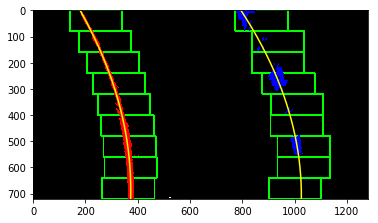

507.95061428218827

560.1855052574775

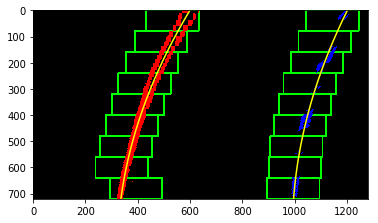

739.2597999630945

458.21864797912923

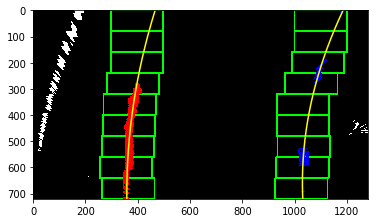

6494.876907014101

373.58204263048714

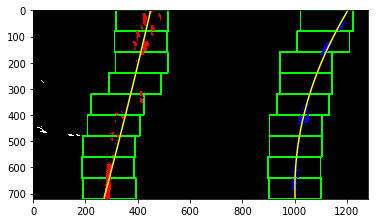

645.0040732164791

1231.373498377294

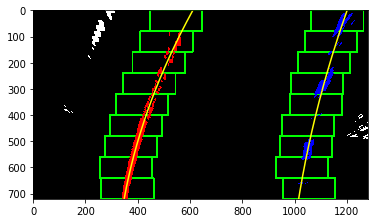

In [25]:
from curveutil import find_base_curve
from curve import Curve

#images = ['./test_images/straight_lines1.jpg']
images = glob.glob('./test_images/*.jpg')
curve_images = "curve_images"
if not os.path.exists(output_images+curve_images):
    os.makedirs(output_images+curve_images)
curve_images += "/"

rows = len(images)

fig = plt.figure(figsize=(8, 25))

left_curve = Curve()
right_curve = Curve()
for i in range(rows):
    img = mpimage.imread(images[i])
    output_fname = output_images+curve_images+images[i].split("\\")[-1]
    
    undistorted_img = calibrate.undistort(img)
    thresh_img = threshold_pipeline(undistorted_img)
    #thresh_img = np.dstack((thresh_img, thresh_img, thresh_img))*255
    roi_img = region_of_interest(thresh_img,roi_pts) 
    output_undistorted_img = pt.transform(undistorted_img)
    
    perspective_img = pt.transform(roi_img)
    
    output_img = find_base_curve(perspective_img, left_curve, right_curve)
    
    print(left_curve.radius_of_curvature, right_curve.radius_of_curvature)
    #cv2.imwrite(output_undist_fname, cv2.cvtColor(output_undistorted_img, cv2.COLOR_RGB2BGR))
    cv2.imwrite(output_fname, cv2.cvtColor(output_img, cv2.COLOR_RGB2BGR))
    # 
    # cv2.polylines(undistorted_img,np.array([src_pts]),True,(0,255,0),thickness=5)
    # cv2.polylines(output_img,np.array([dst_pts]),True,(0,0,255),thickness=10)
    # cv2.polylines(undistorted_img,roi_pts,True,(255,0,255),thickness=5)
    
    # fig.add_subplot(rows, 3, i*3+1)
    # plt.imshow(undistorted_img)
    # fig.add_subplot(rows, 3, i*3+2)
    # plt.imshow(output_img) 
    # fig.add_subplot(rows, 3, i*3+3)
    # plt.plot(histogram)
    ploty = np.linspace(0, output_img.shape[0]-1, output_img.shape[0] )
    left_fitx = left_curve.current_fit[0]*ploty**2 + left_curve.current_fit[1]*ploty + left_curve.current_fit[2]
    right_fitx = right_curve.current_fit[0]*ploty**2 + right_curve.current_fit[1]*ploty + right_curve.current_fit[2]

    plt.imshow(output_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    

    plt.show()

In [35]:
from curveutil import find_base_curve
def process_image(img):
    undistorted_img = calibrate.undistort(img)
    thresh_img = threshold_pipeline(undistorted_img)
    #thresh_img = np.dstack((thresh_img, thresh_img, thresh_img))*255
    roi_img = region_of_interest(thresh_img,roi_pts) 
    #output_undistorted_img = pt.transform(undistorted_img)
    
    perspective_img = pt.transform(roi_img)
    
    output_img = find_base_curve(perspective_img, left_curve, right_curve)
    
    warp_zero = np.zeros_like(perspective_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    ploty = np.linspace(0, output_img.shape[0]-1, output_img.shape[0])
    left_fitx = left_curve.get_fit(ploty)
    right_fitx = right_curve.get_fit(ploty)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = pt.inverse_transform(color_warp)
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)
    #plt.imshow(result)
    font = cv2.FONT_HERSHEY_COMPLEX
    
    xm_per_pix = 3.7/700
    img_mid = img.shape[1] / 2
     
    
    a = left_curve.current_fit[0]
    b = left_curve.current_fit[1]
    c = left_curve.current_fit[2]
    y = 720
    left_line_base = (a*y**2)+(b*y)+c
    
    a = right_curve.current_fit[0]
    b = right_curve.current_fit[1]
    c = right_curve.current_fit[2]
    y = 720
    right_line_base = (a*y**2)+(b*y)+c
    lane_centre = (left_line_base+right_line_base)/2
    dist_center = (lane_centre - img_mid) * xm_per_pix
    
    pos = "left" if dist_center >= 0 else "right"
    pos_text = "{} m {} of center".format(abs(round(dist_center,2)),pos)

    cv2.putText(result, pos_text, (10,50), font, 1,(255,255,255),2)
    avg_rad = round(np.mean([left_curve.radius_of_curvature, right_curve.radius_of_curvature]),0)
    roc_text = "Radius of Curvature: {}(m)".format(avg_rad)
    cv2.putText(result, roc_text, (10,100), font, 1,(255,255,255),2)
    #res =np.dstack((perspective_img,pt.inverse_transform(perspective_img),perspective_img))*255
    #result = cv2.addWeighted(undistorted_img, 1, res, 2, 0)
    return result
    

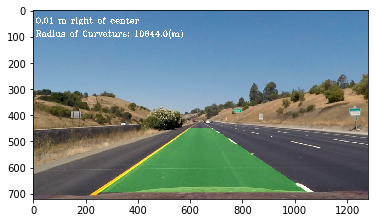

In [39]:
from curve import Curve

#images = ['./test_images/straight_lines1.jpg']
images = glob.glob('./test_images/*.jpg')
final_output = "final_output"
if not os.path.exists(output_images+final_output):
    os.makedirs(output_images+final_output)
final_output += "/"

rows = len(images)


left_curve = Curve()
right_curve = Curve()
for i in range(1):
    img = mpimage.imread(images[i])
    output_fname = output_images+final_output+images[i].split("\\")[-1]
    
    output_img = process_image(img)
    
    #print(left_curve.radius_of_curvature, right_curve.radius_of_curvature)
    cv2.imwrite(output_fname, cv2.cvtColor(output_img, cv2.COLOR_RGB2BGR))

    plt.imshow(output_img)
    plt.show()

In [40]:
from moviepy.editor import VideoFileClip

vid_output = 'res_vid.mp4'
vid_in = VideoFileClip("project_video.mp4")#.subclip('00:00:38.00', '00:00:42.00')

# NOTE: this function expects color images

left_curve = Curve()
right_curve = Curve()
count = 1
def save_frames(img): 
    cv2.imwrite("./output_images/test/test"+str(count)+".jpg", cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    out = process_image(img)
    cv2.imwrite("./output_images/test/out"+str(count)+".jpg", cv2.cvtColor(out, cv2.COLOR_RGB2BGR))
    global count
    count= count+1
    return out

vid_out = vid_in.fl_image(process_image) 
vid_out.write_videofile(vid_output, audio=False)

vid_in.reader.close()
vid_in.audio.reader.close_proc()
vid_out.reader.close()
vid_out.audio.reader.close_proc()

[MoviePy] >>>> Building video res_vid.mp4


[MoviePy] Writing video res_vid.mp4


  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]

  0%|                                                                                 | 1/1261 [00:00<07:13,  2.91it/s]

  0%|▏                                                                                | 2/1261 [00:00<07:20,  2.86it/s]

  0%|▏                                                                                | 3/1261 [00:01<07:29,  2.80it/s]

  0%|▎                                                                                | 4/1261 [00:01<07:12,  2.91it/s]

  0%|▎                                                                                | 5/1261 [00:01<07:12,  2.91it/s]

  0%|▍                                                                                | 6/1261 [00:02<07:05,  2.95it/s]

  1%|▍                                                                                | 7/1261 [00:02<07:07,  2.94it/s]

  1%|▌                                                                                | 8/1261 [00:02<06:54,  3.02it/s]

  1%|▌                                                                                | 9/1261 [00:03<06:36,  3.16it/s]

  1%|▋                                                                               | 10/1261 [00:03<06:11,  3.37it/s]

  1%|▋                                                                               | 11/1261 [00:03<06:00,  3.47it/s]

  1%|▊                                                                               | 12/1261 [00:03<05:57,  3.49it/s]

  1%|▊                                                                               | 13/1261 [00:04<05:49,  3.57it/s]

  1%|▉                                                                               | 14/1261 [00:04<05:43,  3.63it/s]

  1%|▉                                                                               | 15/1261 [00:04<05:51,  3.55it/s]

  1%|█                                                                               | 16/1261 [00:04<05:56,  3.49it/s]

  1%|█                                                                               | 17/1261 [00:05<06:00,  3.45it/s]

  1%|█▏                                                                              | 18/1261 [00:05<06:02,  3.43it/s]

  2%|█▏                                                                              | 19/1261 [00:05<06:00,  3.44it/s]

  2%|█▎                                                                              | 20/1261 [00:06<05:51,  3.53it/s]

  2%|█▎                                                                              | 21/1261 [00:06<05:44,  3.60it/s]

  2%|█▍                                                                              | 22/1261 [00:06<05:37,  3.67it/s]

  2%|█▍                                                                              | 23/1261 [00:06<05:34,  3.70it/s]

  2%|█▌                                                                              | 24/1261 [00:07<05:32,  3.72it/s]

  2%|█▌                                                                              | 25/1261 [00:07<05:31,  3.72it/s]

  2%|█▋                                                                              | 26/1261 [00:07<05:25,  3.79it/s]

  2%|█▋                                                                              | 27/1261 [00:07<05:32,  3.72it/s]

  2%|█▊                                                                              | 28/1261 [00:08<05:30,  3.73it/s]

  2%|█▊                                                                              | 29/1261 [00:08<05:27,  3.76it/s]

  2%|█▉                                                                              | 30/1261 [00:08<05:21,  3.83it/s]

  2%|█▉                                                                              | 31/1261 [00:08<05:22,  3.81it/s]

  3%|██                                                                              | 32/1261 [00:09<05:23,  3.80it/s]

  3%|██                                                                              | 33/1261 [00:09<05:23,  3.79it/s]

  3%|██▏                                                                             | 34/1261 [00:09<05:19,  3.84it/s]

  3%|██▏                                                                             | 35/1261 [00:10<05:21,  3.82it/s]

  3%|██▎                                                                             | 36/1261 [00:10<05:22,  3.80it/s]

  3%|██▎                                                                             | 37/1261 [00:10<05:16,  3.87it/s]

  3%|██▍                                                                             | 38/1261 [00:10<05:24,  3.77it/s]

  3%|██▍                                                                             | 39/1261 [00:11<05:24,  3.77it/s]

  3%|██▌                                                                             | 40/1261 [00:11<05:29,  3.70it/s]

  3%|██▌                                                                             | 41/1261 [00:11<05:39,  3.59it/s]

  3%|██▋                                                                             | 42/1261 [00:11<05:34,  3.64it/s]

  3%|██▋                                                                             | 43/1261 [00:12<05:53,  3.44it/s]

  3%|██▊                                                                             | 44/1261 [00:12<06:00,  3.38it/s]

  4%|██▊                                                                             | 45/1261 [00:12<05:58,  3.40it/s]

  4%|██▉                                                                             | 46/1261 [00:13<05:47,  3.50it/s]

  4%|██▉                                                                             | 47/1261 [00:13<05:39,  3.57it/s]

  4%|███                                                                             | 48/1261 [00:13<05:36,  3.61it/s]

  4%|███                                                                             | 49/1261 [00:13<05:31,  3.65it/s]

  4%|███▏                                                                            | 50/1261 [00:14<05:22,  3.75it/s]

  4%|███▏                                                                            | 51/1261 [00:14<05:29,  3.67it/s]

  4%|███▎                                                                            | 52/1261 [00:14<05:26,  3.70it/s]

  4%|███▎                                                                            | 53/1261 [00:14<05:24,  3.72it/s]

  4%|███▍                                                                            | 54/1261 [00:15<05:23,  3.73it/s]

  4%|███▍                                                                            | 55/1261 [00:15<05:21,  3.75it/s]

  4%|███▌                                                                            | 56/1261 [00:15<05:21,  3.75it/s]

  5%|███▌                                                                            | 57/1261 [00:16<05:20,  3.76it/s]

  5%|███▋                                                                            | 58/1261 [00:16<05:20,  3.76it/s]

  5%|███▋                                                                            | 59/1261 [00:16<05:17,  3.79it/s]

  5%|███▊                                                                            | 60/1261 [00:16<05:23,  3.71it/s]

  5%|███▊                                                                            | 61/1261 [00:17<05:21,  3.73it/s]

  5%|███▉                                                                            | 62/1261 [00:17<05:14,  3.81it/s]

  5%|███▉                                                                            | 63/1261 [00:17<05:14,  3.81it/s]

  5%|████                                                                            | 64/1261 [00:17<05:15,  3.79it/s]

  5%|████                                                                            | 65/1261 [00:18<05:27,  3.65it/s]

  5%|████▏                                                                           | 66/1261 [00:18<06:32,  3.04it/s]

  5%|████▎                                                                           | 67/1261 [00:18<06:21,  3.13it/s]

  5%|████▎                                                                           | 68/1261 [00:19<06:24,  3.11it/s]

  5%|████▍                                                                           | 69/1261 [00:19<06:37,  3.00it/s]

  6%|████▍                                                                           | 70/1261 [00:19<06:18,  3.14it/s]

  6%|████▌                                                                           | 71/1261 [00:20<06:05,  3.26it/s]

  6%|████▌                                                                           | 72/1261 [00:20<05:51,  3.38it/s]

  6%|████▋                                                                           | 73/1261 [00:20<05:35,  3.55it/s]

  6%|████▋                                                                           | 74/1261 [00:21<05:34,  3.55it/s]

  6%|████▊                                                                           | 75/1261 [00:21<05:34,  3.55it/s]

  6%|████▊                                                                           | 76/1261 [00:21<05:25,  3.64it/s]

  6%|████▉                                                                           | 77/1261 [00:21<05:21,  3.68it/s]

  6%|████▉                                                                           | 78/1261 [00:22<05:19,  3.70it/s]

  6%|█████                                                                           | 79/1261 [00:22<05:17,  3.72it/s]

  6%|█████                                                                           | 80/1261 [00:22<05:09,  3.81it/s]

  6%|█████▏                                                                          | 81/1261 [00:22<05:16,  3.73it/s]

  7%|█████▏                                                                          | 82/1261 [00:23<05:15,  3.74it/s]

  7%|█████▎                                                                          | 83/1261 [00:23<05:17,  3.71it/s]

  7%|█████▎                                                                          | 84/1261 [00:23<05:15,  3.72it/s]

  7%|█████▍                                                                          | 85/1261 [00:23<05:14,  3.74it/s]

  7%|█████▍                                                                          | 86/1261 [00:24<05:41,  3.44it/s]

  7%|█████▌                                                                          | 87/1261 [00:24<05:55,  3.30it/s]

  7%|█████▌                                                                          | 88/1261 [00:25<06:53,  2.84it/s]

  7%|█████▋                                                                          | 89/1261 [00:25<07:28,  2.61it/s]

  7%|█████▋                                                                          | 90/1261 [00:25<06:58,  2.80it/s]

  7%|█████▊                                                                          | 91/1261 [00:26<08:56,  2.18it/s]

  7%|█████▊                                                                          | 92/1261 [00:26<07:53,  2.47it/s]

  7%|█████▉                                                                          | 93/1261 [00:27<07:04,  2.75it/s]

  7%|█████▉                                                                          | 94/1261 [00:27<06:35,  2.95it/s]

  8%|██████                                                                          | 95/1261 [00:27<06:11,  3.14it/s]

  8%|██████                                                                          | 96/1261 [00:27<05:59,  3.24it/s]

  8%|██████▏                                                                         | 97/1261 [00:28<05:44,  3.38it/s]

  8%|██████▏                                                                         | 98/1261 [00:28<05:59,  3.24it/s]

  8%|██████▎                                                                         | 99/1261 [00:28<06:49,  2.84it/s]

  8%|██████▎                                                                        | 100/1261 [00:29<06:47,  2.85it/s]

  8%|██████▎                                                                        | 101/1261 [00:30<10:31,  1.84it/s]

  8%|██████▍                                                                        | 102/1261 [00:30<09:25,  2.05it/s]

  8%|██████▍                                                                        | 103/1261 [00:31<08:35,  2.25it/s]

  8%|██████▌                                                                        | 104/1261 [00:33<17:37,  1.09it/s]

  8%|██████▌                                                                        | 105/1261 [00:33<13:56,  1.38it/s]

  8%|██████▋                                                                        | 106/1261 [00:33<11:25,  1.68it/s]

  8%|██████▋                                                                        | 107/1261 [00:33<09:31,  2.02it/s]

  9%|██████▊                                                                        | 108/1261 [00:34<08:05,  2.37it/s]

  9%|██████▊                                                                        | 109/1261 [00:34<07:09,  2.68it/s]

  9%|██████▉                                                                        | 110/1261 [00:34<06:38,  2.89it/s]

  9%|██████▉                                                                        | 111/1261 [00:34<06:10,  3.10it/s]

  9%|███████                                                                        | 112/1261 [00:35<05:45,  3.33it/s]

  9%|███████                                                                        | 113/1261 [00:35<05:34,  3.43it/s]

  9%|███████▏                                                                       | 114/1261 [00:35<05:25,  3.53it/s]

  9%|███████▏                                                                       | 115/1261 [00:35<05:18,  3.60it/s]

  9%|███████▎                                                                       | 116/1261 [00:36<05:14,  3.64it/s]

  9%|███████▎                                                                       | 117/1261 [00:36<05:05,  3.74it/s]

  9%|███████▍                                                                       | 118/1261 [00:36<05:10,  3.69it/s]

  9%|███████▍                                                                       | 119/1261 [00:37<05:09,  3.69it/s]

 10%|███████▌                                                                       | 120/1261 [00:37<05:07,  3.71it/s]

 10%|███████▌                                                                       | 121/1261 [00:37<05:07,  3.71it/s]

 10%|███████▋                                                                       | 122/1261 [00:37<05:11,  3.66it/s]

 10%|███████▋                                                                       | 123/1261 [00:38<05:08,  3.69it/s]

 10%|███████▊                                                                       | 124/1261 [00:38<05:06,  3.71it/s]

 10%|███████▊                                                                       | 125/1261 [00:38<05:10,  3.66it/s]

 10%|███████▉                                                                       | 126/1261 [00:39<06:21,  2.97it/s]

 10%|███████▉                                                                       | 127/1261 [00:39<06:07,  3.08it/s]

 10%|████████                                                                       | 128/1261 [00:39<06:22,  2.96it/s]

 10%|████████                                                                       | 129/1261 [00:40<06:22,  2.96it/s]

 10%|████████▏                                                                      | 130/1261 [00:40<05:58,  3.15it/s]

 10%|████████▏                                                                      | 131/1261 [00:40<05:35,  3.37it/s]

 10%|████████▎                                                                      | 132/1261 [00:40<05:24,  3.48it/s]

 11%|████████▎                                                                      | 133/1261 [00:41<05:17,  3.56it/s]

 11%|████████▍                                                                      | 134/1261 [00:41<05:17,  3.55it/s]

 11%|████████▍                                                                      | 135/1261 [00:41<05:06,  3.68it/s]

 11%|████████▌                                                                      | 136/1261 [00:42<05:03,  3.70it/s]

 11%|████████▌                                                                      | 137/1261 [00:42<05:07,  3.66it/s]

 11%|████████▋                                                                      | 138/1261 [00:42<05:01,  3.73it/s]

 11%|████████▋                                                                      | 139/1261 [00:42<04:59,  3.74it/s]

 11%|████████▊                                                                      | 140/1261 [00:43<04:59,  3.75it/s]

 11%|████████▊                                                                      | 141/1261 [00:43<04:58,  3.75it/s]

 11%|████████▉                                                                      | 142/1261 [00:43<04:57,  3.76it/s]

 11%|████████▉                                                                      | 143/1261 [00:43<04:57,  3.76it/s]

 11%|█████████                                                                      | 144/1261 [00:44<04:51,  3.83it/s]

 11%|█████████                                                                      | 145/1261 [00:44<04:58,  3.74it/s]

 12%|█████████▏                                                                     | 146/1261 [00:44<05:05,  3.65it/s]

 12%|█████████▏                                                                     | 147/1261 [00:44<04:56,  3.75it/s]

 12%|█████████▎                                                                     | 148/1261 [00:45<04:56,  3.76it/s]

 12%|█████████▎                                                                     | 149/1261 [00:45<04:57,  3.73it/s]

 12%|█████████▍                                                                     | 150/1261 [00:45<05:59,  3.09it/s]

 12%|█████████▍                                                                     | 151/1261 [00:46<06:31,  2.83it/s]

 12%|█████████▌                                                                     | 152/1261 [00:46<06:02,  3.06it/s]

 12%|█████████▌                                                                     | 153/1261 [00:46<05:52,  3.15it/s]

 12%|█████████▋                                                                     | 154/1261 [00:47<05:40,  3.25it/s]

 12%|█████████▋                                                                     | 155/1261 [00:47<05:27,  3.38it/s]

 12%|█████████▊                                                                     | 156/1261 [00:47<05:11,  3.54it/s]

 12%|█████████▊                                                                     | 157/1261 [00:48<05:16,  3.49it/s]

 13%|█████████▉                                                                     | 158/1261 [00:48<05:03,  3.63it/s]

 13%|█████████▉                                                                     | 159/1261 [00:48<05:02,  3.65it/s]

 13%|██████████                                                                     | 160/1261 [00:48<04:53,  3.75it/s]

 13%|██████████                                                                     | 161/1261 [00:49<04:58,  3.69it/s]

 13%|██████████▏                                                                    | 162/1261 [00:49<04:56,  3.71it/s]

 13%|██████████▏                                                                    | 163/1261 [00:49<04:52,  3.75it/s]

 13%|██████████▎                                                                    | 164/1261 [00:49<04:47,  3.82it/s]

 13%|██████████▎                                                                    | 165/1261 [00:50<04:53,  3.74it/s]

 13%|██████████▍                                                                    | 166/1261 [00:50<04:52,  3.75it/s]

 13%|██████████▍                                                                    | 167/1261 [00:50<04:47,  3.81it/s]

 13%|██████████▌                                                                    | 168/1261 [00:50<04:47,  3.80it/s]

 13%|██████████▌                                                                    | 169/1261 [00:51<04:43,  3.86it/s]

 13%|██████████▋                                                                    | 170/1261 [00:51<04:51,  3.74it/s]

 14%|██████████▋                                                                    | 171/1261 [00:51<04:45,  3.82it/s]

 14%|██████████▊                                                                    | 172/1261 [00:51<04:51,  3.73it/s]

 14%|██████████▊                                                                    | 173/1261 [00:52<04:55,  3.68it/s]

 14%|██████████▉                                                                    | 174/1261 [00:52<05:49,  3.11it/s]

 14%|██████████▉                                                                    | 175/1261 [00:53<05:56,  3.05it/s]

 14%|███████████                                                                    | 176/1261 [00:53<05:50,  3.09it/s]

 14%|███████████                                                                    | 177/1261 [00:53<05:42,  3.17it/s]

 14%|███████████▏                                                                   | 178/1261 [00:53<05:31,  3.27it/s]

 14%|███████████▏                                                                   | 179/1261 [00:54<05:19,  3.39it/s]

 14%|███████████▎                                                                   | 180/1261 [00:54<05:08,  3.50it/s]

 14%|███████████▎                                                                   | 181/1261 [00:54<05:06,  3.52it/s]

 14%|███████████▍                                                                   | 182/1261 [00:55<05:00,  3.59it/s]

 15%|███████████▍                                                                   | 183/1261 [00:55<04:56,  3.64it/s]

 15%|███████████▌                                                                   | 184/1261 [00:55<04:51,  3.70it/s]

 15%|███████████▌                                                                   | 185/1261 [00:55<04:44,  3.78it/s]

 15%|███████████▋                                                                   | 186/1261 [00:56<04:59,  3.59it/s]

 15%|███████████▋                                                                   | 187/1261 [00:56<05:15,  3.41it/s]

 15%|███████████▊                                                                   | 188/1261 [00:56<05:10,  3.46it/s]

 15%|███████████▊                                                                   | 189/1261 [00:56<05:02,  3.54it/s]

 15%|███████████▉                                                                   | 190/1261 [00:57<05:01,  3.55it/s]

 15%|███████████▉                                                                   | 191/1261 [00:57<04:57,  3.60it/s]

 15%|████████████                                                                   | 192/1261 [00:57<04:47,  3.72it/s]

 15%|████████████                                                                   | 193/1261 [00:58<04:46,  3.73it/s]

 15%|████████████▏                                                                  | 194/1261 [00:58<04:45,  3.74it/s]

 15%|████████████▏                                                                  | 195/1261 [00:58<04:44,  3.74it/s]

 16%|████████████▎                                                                  | 196/1261 [00:58<04:44,  3.75it/s]

 16%|████████████▎                                                                  | 197/1261 [00:59<04:48,  3.69it/s]

 16%|████████████▍                                                                  | 198/1261 [00:59<06:01,  2.94it/s]

 16%|████████████▍                                                                  | 199/1261 [00:59<06:12,  2.85it/s]

 16%|████████████▌                                                                  | 200/1261 [01:00<05:44,  3.08it/s]

 16%|████████████▌                                                                  | 201/1261 [01:00<05:37,  3.14it/s]

 16%|████████████▋                                                                  | 202/1261 [01:00<05:24,  3.26it/s]

 16%|████████████▋                                                                  | 203/1261 [01:01<05:06,  3.45it/s]

 16%|████████████▊                                                                  | 204/1261 [01:01<04:58,  3.54it/s]

 16%|████████████▊                                                                  | 205/1261 [01:01<04:53,  3.60it/s]

 16%|████████████▉                                                                  | 206/1261 [01:01<04:49,  3.65it/s]

 16%|████████████▉                                                                  | 207/1261 [01:02<04:46,  3.68it/s]

 16%|█████████████                                                                  | 208/1261 [01:02<04:43,  3.72it/s]

 17%|█████████████                                                                  | 209/1261 [01:02<04:47,  3.66it/s]

 17%|█████████████▏                                                                 | 210/1261 [01:02<04:44,  3.69it/s]

 17%|█████████████▏                                                                 | 211/1261 [01:03<04:42,  3.71it/s]

 17%|█████████████▎                                                                 | 212/1261 [01:03<04:38,  3.77it/s]

 17%|█████████████▎                                                                 | 213/1261 [01:03<04:47,  3.64it/s]

 17%|█████████████▍                                                                 | 214/1261 [01:04<04:39,  3.74it/s]

 17%|█████████████▍                                                                 | 215/1261 [01:04<04:39,  3.75it/s]

 17%|█████████████▌                                                                 | 216/1261 [01:04<04:35,  3.79it/s]

 17%|█████████████▌                                                                 | 217/1261 [01:04<04:40,  3.72it/s]

 17%|█████████████▋                                                                 | 218/1261 [01:05<04:39,  3.73it/s]

 17%|█████████████▋                                                                 | 219/1261 [01:05<04:38,  3.74it/s]

 17%|█████████████▊                                                                 | 220/1261 [01:05<04:37,  3.75it/s]

 18%|█████████████▊                                                                 | 221/1261 [01:05<04:46,  3.63it/s]

 18%|█████████████▉                                                                 | 222/1261 [01:06<05:46,  3.00it/s]

 18%|█████████████▉                                                                 | 223/1261 [01:06<05:51,  2.95it/s]

 18%|██████████████                                                                 | 224/1261 [01:07<05:33,  3.11it/s]

 18%|██████████████                                                                 | 225/1261 [01:07<05:30,  3.14it/s]

 18%|██████████████▏                                                                | 226/1261 [01:07<05:16,  3.27it/s]

 18%|██████████████▏                                                                | 227/1261 [01:07<05:03,  3.41it/s]

 18%|██████████████▎                                                                | 228/1261 [01:08<04:54,  3.51it/s]

 18%|██████████████▎                                                                | 229/1261 [01:08<04:46,  3.60it/s]

 18%|██████████████▍                                                                | 230/1261 [01:08<04:44,  3.62it/s]

 18%|██████████████▍                                                                | 231/1261 [01:08<04:41,  3.67it/s]

 18%|██████████████▌                                                                | 232/1261 [01:09<04:38,  3.69it/s]

 18%|██████████████▌                                                                | 233/1261 [01:09<04:38,  3.69it/s]

 19%|██████████████▋                                                                | 234/1261 [01:09<04:32,  3.77it/s]

 19%|██████████████▋                                                                | 235/1261 [01:10<04:32,  3.77it/s]

 19%|██████████████▊                                                                | 236/1261 [01:10<04:32,  3.76it/s]

 19%|██████████████▊                                                                | 237/1261 [01:10<04:36,  3.71it/s]

 19%|██████████████▉                                                                | 238/1261 [01:10<04:35,  3.71it/s]

 19%|██████████████▉                                                                | 239/1261 [01:11<04:29,  3.80it/s]

 19%|███████████████                                                                | 240/1261 [01:11<04:28,  3.80it/s]

 19%|███████████████                                                                | 241/1261 [01:11<04:29,  3.78it/s]

 19%|███████████████▏                                                               | 242/1261 [01:11<04:44,  3.58it/s]

 19%|███████████████▏                                                               | 243/1261 [01:12<04:35,  3.70it/s]

 19%|███████████████▎                                                               | 244/1261 [01:12<04:34,  3.70it/s]

 19%|███████████████▎                                                               | 245/1261 [01:12<04:33,  3.72it/s]

 20%|███████████████▍                                                               | 246/1261 [01:13<04:50,  3.49it/s]

 20%|███████████████▍                                                               | 247/1261 [01:13<05:27,  3.10it/s]

 20%|███████████████▌                                                               | 248/1261 [01:13<05:23,  3.13it/s]

 20%|███████████████▌                                                               | 249/1261 [01:14<05:35,  3.02it/s]

 20%|███████████████▋                                                               | 250/1261 [01:14<05:15,  3.21it/s]

 20%|███████████████▋                                                               | 251/1261 [01:14<05:06,  3.29it/s]

 20%|███████████████▊                                                               | 252/1261 [01:14<04:54,  3.42it/s]

 20%|███████████████▊                                                               | 253/1261 [01:15<04:46,  3.52it/s]

 20%|███████████████▉                                                               | 254/1261 [01:15<04:40,  3.59it/s]

 20%|███████████████▉                                                               | 255/1261 [01:15<04:36,  3.64it/s]

 20%|████████████████                                                               | 256/1261 [01:15<04:28,  3.74it/s]

 20%|████████████████                                                               | 257/1261 [01:16<04:27,  3.75it/s]

 20%|████████████████▏                                                              | 258/1261 [01:16<04:26,  3.76it/s]

 21%|████████████████▏                                                              | 259/1261 [01:16<04:26,  3.76it/s]

 21%|████████████████▎                                                              | 260/1261 [01:17<04:26,  3.76it/s]

 21%|████████████████▎                                                              | 261/1261 [01:17<04:25,  3.76it/s]

 21%|████████████████▍                                                              | 262/1261 [01:17<04:25,  3.76it/s]

 21%|████████████████▍                                                              | 263/1261 [01:17<04:25,  3.76it/s]

 21%|████████████████▌                                                              | 264/1261 [01:18<04:20,  3.83it/s]

 21%|████████████████▌                                                              | 265/1261 [01:18<04:21,  3.81it/s]

 21%|████████████████▋                                                              | 266/1261 [01:18<04:28,  3.71it/s]

 21%|████████████████▋                                                              | 267/1261 [01:18<04:22,  3.79it/s]

 21%|████████████████▊                                                              | 268/1261 [01:19<04:22,  3.78it/s]

 21%|████████████████▊                                                              | 269/1261 [01:19<04:31,  3.65it/s]

 21%|████████████████▉                                                              | 270/1261 [01:19<04:33,  3.62it/s]

 21%|████████████████▉                                                              | 271/1261 [01:20<04:58,  3.32it/s]

 22%|█████████████████                                                              | 272/1261 [01:20<05:52,  2.81it/s]

 22%|█████████████████                                                              | 273/1261 [01:20<05:29,  3.00it/s]

 22%|█████████████████▏                                                             | 274/1261 [01:21<05:18,  3.10it/s]

 22%|█████████████████▏                                                             | 275/1261 [01:21<05:05,  3.23it/s]

 22%|█████████████████▎                                                             | 276/1261 [01:21<04:57,  3.31it/s]

 22%|█████████████████▎                                                             | 277/1261 [01:21<04:46,  3.44it/s]

 22%|█████████████████▍                                                             | 278/1261 [01:22<04:43,  3.47it/s]

 22%|█████████████████▍                                                             | 279/1261 [01:22<04:48,  3.41it/s]

 22%|█████████████████▌                                                             | 280/1261 [01:22<04:44,  3.45it/s]

 22%|█████████████████▌                                                             | 281/1261 [01:23<04:36,  3.54it/s]

 22%|█████████████████▋                                                             | 282/1261 [01:23<04:40,  3.49it/s]

 22%|█████████████████▋                                                             | 283/1261 [01:23<04:38,  3.52it/s]

 23%|█████████████████▊                                                             | 284/1261 [01:23<04:36,  3.53it/s]

 23%|█████████████████▊                                                             | 285/1261 [01:24<04:31,  3.60it/s]

 23%|█████████████████▉                                                             | 286/1261 [01:24<04:32,  3.57it/s]

 23%|█████████████████▉                                                             | 287/1261 [01:24<04:28,  3.63it/s]

 23%|██████████████████                                                             | 288/1261 [01:25<04:25,  3.67it/s]

 23%|██████████████████                                                             | 289/1261 [01:25<04:18,  3.76it/s]

 23%|██████████████████▏                                                            | 290/1261 [01:25<04:20,  3.72it/s]

 23%|██████████████████▏                                                            | 291/1261 [01:25<04:17,  3.76it/s]

 23%|██████████████████▎                                                            | 292/1261 [01:26<04:22,  3.70it/s]

 23%|██████████████████▎                                                            | 293/1261 [01:26<04:15,  3.78it/s]

 23%|██████████████████▍                                                            | 294/1261 [01:26<04:20,  3.71it/s]

 23%|██████████████████▍                                                            | 295/1261 [01:27<05:27,  2.95it/s]

 23%|██████████████████▌                                                            | 296/1261 [01:27<05:10,  3.11it/s]

 24%|██████████████████▌                                                            | 297/1261 [01:27<05:16,  3.04it/s]

 24%|██████████████████▋                                                            | 298/1261 [01:28<05:07,  3.13it/s]

 24%|██████████████████▋                                                            | 299/1261 [01:28<04:56,  3.25it/s]

 24%|██████████████████▊                                                            | 300/1261 [01:28<04:44,  3.38it/s]

 24%|██████████████████▊                                                            | 301/1261 [01:28<04:35,  3.49it/s]

 24%|██████████████████▉                                                            | 302/1261 [01:29<04:33,  3.51it/s]

 24%|██████████████████▉                                                            | 303/1261 [01:29<04:29,  3.55it/s]

 24%|███████████████████                                                            | 304/1261 [01:29<04:24,  3.61it/s]

 24%|███████████████████                                                            | 305/1261 [01:29<04:21,  3.66it/s]

 24%|███████████████████▏                                                           | 306/1261 [01:30<04:23,  3.63it/s]

 24%|███████████████████▏                                                           | 307/1261 [01:30<04:19,  3.67it/s]

 24%|███████████████████▎                                                           | 308/1261 [01:30<04:13,  3.76it/s]

 25%|███████████████████▎                                                           | 309/1261 [01:31<04:12,  3.76it/s]

 25%|███████████████████▍                                                           | 310/1261 [01:31<04:17,  3.70it/s]

 25%|███████████████████▍                                                           | 311/1261 [01:31<04:13,  3.74it/s]

 25%|███████████████████▌                                                           | 312/1261 [01:31<04:12,  3.76it/s]

 25%|███████████████████▌                                                           | 313/1261 [01:32<04:12,  3.76it/s]

 25%|███████████████████▋                                                           | 314/1261 [01:32<04:16,  3.70it/s]

 25%|███████████████████▋                                                           | 315/1261 [01:32<04:11,  3.76it/s]

 25%|███████████████████▊                                                           | 316/1261 [01:32<04:11,  3.76it/s]

 25%|███████████████████▊                                                           | 317/1261 [01:33<04:06,  3.83it/s]

 25%|███████████████████▉                                                           | 318/1261 [01:33<04:21,  3.61it/s]

 25%|███████████████████▉                                                           | 319/1261 [01:33<05:19,  2.95it/s]

 25%|████████████████████                                                           | 320/1261 [01:34<05:16,  2.98it/s]

 25%|████████████████████                                                           | 321/1261 [01:34<05:04,  3.08it/s]

 26%|████████████████████▏                                                          | 322/1261 [01:34<04:52,  3.21it/s]

 26%|████████████████████▏                                                          | 323/1261 [01:35<04:43,  3.31it/s]

 26%|████████████████████▎                                                          | 324/1261 [01:35<04:32,  3.44it/s]

 26%|████████████████████▎                                                          | 325/1261 [01:35<04:23,  3.55it/s]

 26%|████████████████████▍                                                          | 326/1261 [01:35<04:18,  3.61it/s]

 26%|████████████████████▍                                                          | 327/1261 [01:36<04:15,  3.66it/s]

 26%|████████████████████▌                                                          | 328/1261 [01:36<04:11,  3.71it/s]

 26%|████████████████████▌                                                          | 329/1261 [01:36<04:10,  3.73it/s]

 26%|████████████████████▋                                                          | 330/1261 [01:36<04:09,  3.74it/s]

 26%|████████████████████▋                                                          | 331/1261 [01:37<04:12,  3.68it/s]

 26%|████████████████████▊                                                          | 332/1261 [01:37<04:06,  3.77it/s]

 26%|████████████████████▊                                                          | 333/1261 [01:37<04:06,  3.77it/s]

 26%|████████████████████▉                                                          | 334/1261 [01:38<04:13,  3.65it/s]

 27%|████████████████████▉                                                          | 335/1261 [01:38<04:09,  3.71it/s]

 27%|█████████████████████                                                          | 336/1261 [01:38<04:04,  3.78it/s]

 27%|█████████████████████                                                          | 337/1261 [01:38<04:04,  3.78it/s]

 27%|█████████████████████▏                                                         | 338/1261 [01:39<04:11,  3.67it/s]

 27%|█████████████████████▏                                                         | 339/1261 [01:39<04:09,  3.70it/s]

 27%|█████████████████████▎                                                         | 340/1261 [01:39<04:07,  3.73it/s]

 27%|█████████████████████▎                                                         | 341/1261 [01:39<04:06,  3.74it/s]

 27%|█████████████████████▍                                                         | 342/1261 [01:40<04:09,  3.68it/s]

 27%|█████████████████████▍                                                         | 343/1261 [01:40<04:37,  3.30it/s]

 27%|█████████████████████▌                                                         | 344/1261 [01:41<05:10,  2.95it/s]

 27%|█████████████████████▌                                                         | 345/1261 [01:41<04:54,  3.11it/s]

 27%|█████████████████████▋                                                         | 346/1261 [01:41<05:08,  2.96it/s]

 28%|█████████████████████▋                                                         | 347/1261 [01:41<04:53,  3.11it/s]

 28%|█████████████████████▊                                                         | 348/1261 [01:42<04:37,  3.29it/s]

 28%|█████████████████████▊                                                         | 349/1261 [01:42<04:30,  3.37it/s]

 28%|█████████████████████▉                                                         | 350/1261 [01:42<04:25,  3.43it/s]

 28%|█████████████████████▉                                                         | 351/1261 [01:43<04:14,  3.58it/s]

 28%|██████████████████████                                                         | 352/1261 [01:43<04:09,  3.64it/s]

 28%|██████████████████████                                                         | 353/1261 [01:43<04:12,  3.60it/s]

 28%|██████████████████████▏                                                        | 354/1261 [01:43<04:08,  3.65it/s]

 28%|██████████████████████▏                                                        | 355/1261 [01:44<04:01,  3.75it/s]

 28%|██████████████████████▎                                                        | 356/1261 [01:44<04:01,  3.75it/s]

 28%|██████████████████████▎                                                        | 357/1261 [01:44<03:58,  3.78it/s]

 28%|██████████████████████▍                                                        | 358/1261 [01:44<04:03,  3.71it/s]

 28%|██████████████████████▍                                                        | 359/1261 [01:45<04:01,  3.73it/s]

 29%|██████████████████████▌                                                        | 360/1261 [01:45<04:00,  3.75it/s]

 29%|██████████████████████▌                                                        | 361/1261 [01:45<03:59,  3.76it/s]

 29%|██████████████████████▋                                                        | 362/1261 [01:45<03:59,  3.76it/s]

 29%|██████████████████████▋                                                        | 363/1261 [01:46<03:58,  3.76it/s]

 29%|██████████████████████▊                                                        | 364/1261 [01:46<03:56,  3.79it/s]

 29%|██████████████████████▊                                                        | 365/1261 [01:46<04:00,  3.72it/s]

 29%|██████████████████████▉                                                        | 366/1261 [01:47<04:08,  3.61it/s]

 29%|██████████████████████▉                                                        | 367/1261 [01:47<04:04,  3.65it/s]

 29%|███████████████████████                                                        | 368/1261 [01:47<04:35,  3.24it/s]

 29%|███████████████████████                                                        | 369/1261 [01:48<05:26,  2.73it/s]

 29%|███████████████████████▏                                                       | 370/1261 [01:48<05:04,  2.92it/s]

 29%|███████████████████████▏                                                       | 371/1261 [01:48<04:46,  3.10it/s]

 30%|███████████████████████▎                                                       | 372/1261 [01:49<04:31,  3.27it/s]

 30%|███████████████████████▎                                                       | 373/1261 [01:49<04:20,  3.41it/s]

 30%|███████████████████████▍                                                       | 374/1261 [01:49<04:16,  3.45it/s]

 30%|███████████████████████▍                                                       | 375/1261 [01:49<04:06,  3.60it/s]

 30%|███████████████████████▌                                                       | 376/1261 [01:50<04:02,  3.65it/s]

 30%|███████████████████████▌                                                       | 377/1261 [01:50<04:00,  3.68it/s]

 30%|███████████████████████▋                                                       | 378/1261 [01:50<03:57,  3.72it/s]

 30%|███████████████████████▋                                                       | 379/1261 [01:50<03:56,  3.73it/s]

 30%|███████████████████████▊                                                       | 380/1261 [01:51<03:55,  3.74it/s]

 30%|███████████████████████▊                                                       | 381/1261 [01:51<03:55,  3.73it/s]

 30%|███████████████████████▉                                                       | 382/1261 [01:51<03:54,  3.74it/s]

 30%|███████████████████████▉                                                       | 383/1261 [01:51<03:50,  3.82it/s]

 30%|████████████████████████                                                       | 384/1261 [01:52<03:54,  3.73it/s]

 31%|████████████████████████                                                       | 385/1261 [01:52<03:54,  3.73it/s]

 31%|████████████████████████▏                                                      | 386/1261 [01:52<03:53,  3.74it/s]

 31%|████████████████████████▏                                                      | 387/1261 [01:53<03:53,  3.75it/s]

 31%|████████████████████████▎                                                      | 388/1261 [01:53<03:48,  3.82it/s]

 31%|████████████████████████▎                                                      | 389/1261 [01:53<03:53,  3.74it/s]

 31%|████████████████████████▍                                                      | 390/1261 [01:53<03:56,  3.68it/s]

 31%|████████████████████████▍                                                      | 391/1261 [01:54<03:58,  3.64it/s]

 31%|████████████████████████▌                                                      | 392/1261 [01:54<05:12,  2.78it/s]

 31%|████████████████████████▌                                                      | 393/1261 [01:55<05:19,  2.71it/s]

 31%|████████████████████████▋                                                      | 394/1261 [01:55<04:56,  2.92it/s]

 31%|████████████████████████▋                                                      | 395/1261 [01:55<04:44,  3.05it/s]

 31%|████████████████████████▊                                                      | 396/1261 [01:55<04:27,  3.23it/s]

 31%|████████████████████████▊                                                      | 397/1261 [01:56<04:15,  3.38it/s]

 32%|████████████████████████▉                                                      | 398/1261 [01:56<04:15,  3.38it/s]

 32%|████████████████████████▉                                                      | 399/1261 [01:56<04:18,  3.33it/s]

 32%|█████████████████████████                                                      | 400/1261 [01:57<04:22,  3.28it/s]

 32%|█████████████████████████                                                      | 401/1261 [01:57<04:16,  3.35it/s]

 32%|█████████████████████████▏                                                     | 402/1261 [01:57<04:06,  3.48it/s]

 32%|█████████████████████████▏                                                     | 403/1261 [01:57<04:00,  3.56it/s]

 32%|█████████████████████████▎                                                     | 404/1261 [01:58<03:56,  3.62it/s]

 32%|█████████████████████████▎                                                     | 405/1261 [01:58<03:52,  3.69it/s]

 32%|█████████████████████████▍                                                     | 406/1261 [01:58<03:50,  3.71it/s]

 32%|█████████████████████████▍                                                     | 407/1261 [01:58<03:49,  3.73it/s]

 32%|█████████████████████████▌                                                     | 408/1261 [01:59<03:48,  3.74it/s]

 32%|█████████████████████████▌                                                     | 409/1261 [01:59<03:47,  3.75it/s]

 33%|█████████████████████████▋                                                     | 410/1261 [01:59<03:42,  3.82it/s]

 33%|█████████████████████████▋                                                     | 411/1261 [02:00<03:43,  3.80it/s]

 33%|█████████████████████████▊                                                     | 412/1261 [02:00<03:43,  3.79it/s]

 33%|█████████████████████████▊                                                     | 413/1261 [02:00<03:44,  3.78it/s]

 33%|█████████████████████████▉                                                     | 414/1261 [02:00<04:04,  3.47it/s]

 33%|█████████████████████████▉                                                     | 415/1261 [02:01<04:57,  2.84it/s]

 33%|██████████████████████████                                                     | 416/1261 [02:01<04:39,  3.02it/s]

 33%|██████████████████████████                                                     | 417/1261 [02:01<04:26,  3.17it/s]

 33%|██████████████████████████▏                                                    | 418/1261 [02:02<04:18,  3.27it/s]

 33%|██████████████████████████▏                                                    | 419/1261 [02:02<04:08,  3.38it/s]

 33%|██████████████████████████▎                                                    | 420/1261 [02:02<04:05,  3.43it/s]

 33%|██████████████████████████▍                                                    | 421/1261 [02:03<03:54,  3.59it/s]

 33%|██████████████████████████▍                                                    | 422/1261 [02:03<03:54,  3.58it/s]

 34%|██████████████████████████▌                                                    | 423/1261 [02:03<03:51,  3.62it/s]

 34%|██████████████████████████▌                                                    | 424/1261 [02:03<03:48,  3.66it/s]

 34%|██████████████████████████▋                                                    | 425/1261 [02:04<03:46,  3.69it/s]

 34%|██████████████████████████▋                                                    | 426/1261 [02:04<03:40,  3.78it/s]

 34%|██████████████████████████▊                                                    | 427/1261 [02:04<03:42,  3.75it/s]

 34%|██████████████████████████▊                                                    | 428/1261 [02:04<03:41,  3.76it/s]

 34%|██████████████████████████▉                                                    | 429/1261 [02:05<03:37,  3.83it/s]

 34%|██████████████████████████▉                                                    | 430/1261 [02:05<03:41,  3.75it/s]

 34%|███████████████████████████                                                    | 431/1261 [02:05<03:41,  3.75it/s]

 34%|███████████████████████████                                                    | 432/1261 [02:05<03:40,  3.76it/s]

 34%|███████████████████████████▏                                                   | 433/1261 [02:06<03:40,  3.76it/s]

 34%|███████████████████████████▏                                                   | 434/1261 [02:06<03:38,  3.78it/s]

 34%|███████████████████████████▎                                                   | 435/1261 [02:06<03:42,  3.71it/s]

 35%|███████████████████████████▎                                                   | 436/1261 [02:07<03:37,  3.79it/s]

 35%|███████████████████████████▍                                                   | 437/1261 [02:07<03:37,  3.78it/s]

 35%|███████████████████████████▍                                                   | 438/1261 [02:07<04:27,  3.07it/s]

 35%|███████████████████████████▌                                                   | 439/1261 [02:08<04:16,  3.20it/s]

 35%|███████████████████████████▌                                                   | 440/1261 [02:08<04:27,  3.06it/s]

 35%|███████████████████████████▋                                                   | 441/1261 [02:08<04:35,  2.97it/s]

 35%|███████████████████████████▋                                                   | 442/1261 [02:09<04:21,  3.13it/s]

 35%|███████████████████████████▊                                                   | 443/1261 [02:09<04:08,  3.30it/s]

 35%|███████████████████████████▊                                                   | 444/1261 [02:09<03:56,  3.45it/s]

 35%|███████████████████████████▉                                                   | 445/1261 [02:09<03:54,  3.48it/s]

 35%|███████████████████████████▉                                                   | 446/1261 [02:10<03:48,  3.56it/s]

 35%|████████████████████████████                                                   | 447/1261 [02:10<03:41,  3.68it/s]

 36%|████████████████████████████                                                   | 448/1261 [02:10<03:41,  3.67it/s]

 36%|████████████████████████████▏                                                  | 449/1261 [02:10<03:39,  3.70it/s]

 36%|████████████████████████████▏                                                  | 450/1261 [02:11<03:38,  3.72it/s]

 36%|████████████████████████████▎                                                  | 451/1261 [02:11<03:38,  3.71it/s]

 36%|████████████████████████████▎                                                  | 452/1261 [02:11<03:36,  3.73it/s]

 36%|████████████████████████████▍                                                  | 453/1261 [02:11<03:39,  3.68it/s]

 36%|████████████████████████████▍                                                  | 454/1261 [02:12<03:38,  3.70it/s]

 36%|████████████████████████████▌                                                  | 455/1261 [02:12<03:36,  3.72it/s]

 36%|████████████████████████████▌                                                  | 456/1261 [02:12<03:31,  3.80it/s]

 36%|████████████████████████████▋                                                  | 457/1261 [02:13<03:35,  3.72it/s]

 36%|████████████████████████████▋                                                  | 458/1261 [02:13<03:35,  3.72it/s]

 36%|████████████████████████████▊                                                  | 459/1261 [02:13<03:33,  3.75it/s]

 36%|████████████████████████████▊                                                  | 460/1261 [02:13<03:33,  3.75it/s]

 37%|████████████████████████████▉                                                  | 461/1261 [02:14<03:36,  3.69it/s]

 37%|████████████████████████████▉                                                  | 462/1261 [02:14<03:42,  3.59it/s]

 37%|█████████████████████████████                                                  | 463/1261 [02:14<04:09,  3.20it/s]

 37%|█████████████████████████████                                                  | 464/1261 [02:15<04:20,  3.06it/s]

 37%|█████████████████████████████▏                                                 | 465/1261 [02:15<04:14,  3.12it/s]

 37%|█████████████████████████████▏                                                 | 466/1261 [02:15<04:05,  3.24it/s]

 37%|█████████████████████████████▎                                                 | 467/1261 [02:16<03:58,  3.33it/s]

 37%|█████████████████████████████▎                                                 | 468/1261 [02:16<03:50,  3.45it/s]

 37%|█████████████████████████████▍                                                 | 469/1261 [02:16<03:46,  3.50it/s]

 37%|█████████████████████████████▍                                                 | 470/1261 [02:16<03:44,  3.52it/s]

 37%|█████████████████████████████▌                                                 | 471/1261 [02:17<03:36,  3.65it/s]

 37%|█████████████████████████████▌                                                 | 472/1261 [02:17<03:38,  3.61it/s]

 38%|█████████████████████████████▋                                                 | 473/1261 [02:17<03:36,  3.64it/s]

 38%|█████████████████████████████▋                                                 | 474/1261 [02:17<03:30,  3.74it/s]

 38%|█████████████████████████████▊                                                 | 475/1261 [02:18<03:30,  3.74it/s]

 38%|█████████████████████████████▊                                                 | 476/1261 [02:18<03:30,  3.73it/s]

 38%|█████████████████████████████▉                                                 | 477/1261 [02:18<03:29,  3.74it/s]

 38%|█████████████████████████████▉                                                 | 478/1261 [02:18<03:28,  3.75it/s]

 38%|██████████████████████████████                                                 | 479/1261 [02:19<03:28,  3.75it/s]

 38%|██████████████████████████████                                                 | 480/1261 [02:19<03:26,  3.78it/s]

 38%|██████████████████████████████▏                                                | 481/1261 [02:19<03:28,  3.74it/s]

 38%|██████████████████████████████▏                                                | 482/1261 [02:20<03:31,  3.69it/s]

 38%|██████████████████████████████▎                                                | 483/1261 [02:20<03:29,  3.71it/s]

 38%|██████████████████████████████▎                                                | 484/1261 [02:20<03:29,  3.70it/s]

 38%|██████████████████████████████▍                                                | 485/1261 [02:20<03:28,  3.72it/s]

 39%|██████████████████████████████▍                                                | 486/1261 [02:21<03:27,  3.73it/s]

 39%|██████████████████████████████▌                                                | 487/1261 [02:21<04:04,  3.17it/s]

 39%|██████████████████████████████▌                                                | 488/1261 [02:21<04:13,  3.04it/s]

 39%|██████████████████████████████▋                                                | 489/1261 [02:22<04:09,  3.09it/s]

 39%|██████████████████████████████▋                                                | 490/1261 [02:22<04:14,  3.03it/s]

 39%|██████████████████████████████▊                                                | 491/1261 [02:22<04:08,  3.10it/s]

 39%|██████████████████████████████▊                                                | 492/1261 [02:23<03:54,  3.28it/s]

 39%|██████████████████████████████▉                                                | 493/1261 [02:23<03:47,  3.37it/s]

 39%|██████████████████████████████▉                                                | 494/1261 [02:23<03:39,  3.50it/s]

 39%|███████████████████████████████                                                | 495/1261 [02:23<03:37,  3.51it/s]

 39%|███████████████████████████████                                                | 496/1261 [02:24<03:33,  3.59it/s]

 39%|███████████████████████████████▏                                               | 497/1261 [02:24<03:27,  3.68it/s]

 39%|███████████████████████████████▏                                               | 498/1261 [02:24<03:26,  3.70it/s]

 40%|███████████████████████████████▎                                               | 499/1261 [02:25<03:28,  3.66it/s]

 40%|███████████████████████████████▎                                               | 500/1261 [02:25<03:26,  3.69it/s]

 40%|███████████████████████████████▍                                               | 501/1261 [02:25<03:24,  3.71it/s]

 40%|███████████████████████████████▍                                               | 502/1261 [02:25<03:23,  3.73it/s]

 40%|███████████████████████████████▌                                               | 503/1261 [02:26<03:22,  3.74it/s]

 40%|███████████████████████████████▌                                               | 504/1261 [02:26<03:22,  3.75it/s]

 40%|███████████████████████████████▋                                               | 505/1261 [02:26<03:23,  3.71it/s]

 40%|███████████████████████████████▋                                               | 506/1261 [02:26<03:22,  3.73it/s]

 40%|███████████████████████████████▊                                               | 507/1261 [02:27<03:21,  3.74it/s]

 40%|███████████████████████████████▊                                               | 508/1261 [02:27<03:22,  3.72it/s]

 40%|███████████████████████████████▉                                               | 509/1261 [02:27<03:21,  3.73it/s]

 40%|███████████████████████████████▉                                               | 510/1261 [02:27<03:24,  3.68it/s]

 41%|████████████████████████████████                                               | 511/1261 [02:28<04:08,  3.02it/s]

 41%|████████████████████████████████                                               | 512/1261 [02:28<04:24,  2.83it/s]

 41%|████████████████████████████████▏                                              | 513/1261 [02:29<04:18,  2.89it/s]

 41%|████████████████████████████████▏                                              | 514/1261 [02:29<04:03,  3.06it/s]

 41%|████████████████████████████████▎                                              | 515/1261 [02:29<03:54,  3.18it/s]

 41%|████████████████████████████████▎                                              | 516/1261 [02:30<03:43,  3.33it/s]

 41%|████████████████████████████████▍                                              | 517/1261 [02:30<03:35,  3.45it/s]

 41%|████████████████████████████████▍                                              | 518/1261 [02:30<03:32,  3.50it/s]

 41%|████████████████████████████████▌                                              | 519/1261 [02:30<03:23,  3.64it/s]

 41%|████████████████████████████████▌                                              | 520/1261 [02:31<03:21,  3.68it/s]

 41%|████████████████████████████████▋                                              | 521/1261 [02:31<03:19,  3.70it/s]

 41%|████████████████████████████████▋                                              | 522/1261 [02:31<03:19,  3.71it/s]

 41%|████████████████████████████████▊                                              | 523/1261 [02:31<03:20,  3.69it/s]

 42%|████████████████████████████████▊                                              | 524/1261 [02:32<03:17,  3.73it/s]

 42%|████████████████████████████████▉                                              | 525/1261 [02:32<03:17,  3.73it/s]

 42%|████████████████████████████████▉                                              | 526/1261 [02:32<03:14,  3.77it/s]

 42%|█████████████████████████████████                                              | 527/1261 [02:32<03:14,  3.77it/s]

 42%|█████████████████████████████████                                              | 528/1261 [02:33<03:11,  3.84it/s]

 42%|█████████████████████████████████▏                                             | 529/1261 [02:33<03:12,  3.81it/s]

 42%|█████████████████████████████████▏                                             | 530/1261 [02:33<03:12,  3.79it/s]

 42%|█████████████████████████████████▎                                             | 531/1261 [02:33<03:12,  3.78it/s]

 42%|█████████████████████████████████▎                                             | 532/1261 [02:34<03:12,  3.78it/s]

 42%|█████████████████████████████████▍                                             | 533/1261 [02:34<03:12,  3.77it/s]

 42%|█████████████████████████████████▍                                             | 534/1261 [02:34<03:19,  3.64it/s]

 42%|█████████████████████████████████▌                                             | 535/1261 [02:35<03:44,  3.23it/s]

 43%|█████████████████████████████████▌                                             | 536/1261 [02:35<04:12,  2.88it/s]

 43%|█████████████████████████████████▋                                             | 537/1261 [02:35<04:10,  2.89it/s]

 43%|█████████████████████████████████▋                                             | 538/1261 [02:36<03:54,  3.09it/s]

 43%|█████████████████████████████████▊                                             | 539/1261 [02:36<03:41,  3.25it/s]

 43%|█████████████████████████████████▊                                             | 540/1261 [02:36<03:29,  3.45it/s]

 43%|█████████████████████████████████▉                                             | 541/1261 [02:37<03:23,  3.54it/s]

 43%|█████████████████████████████████▉                                             | 542/1261 [02:37<03:16,  3.66it/s]

 43%|██████████████████████████████████                                             | 543/1261 [02:37<03:15,  3.68it/s]

 43%|██████████████████████████████████                                             | 544/1261 [02:37<03:13,  3.70it/s]

 43%|██████████████████████████████████▏                                            | 545/1261 [02:38<03:12,  3.72it/s]

 43%|██████████████████████████████████▏                                            | 546/1261 [02:38<03:08,  3.80it/s]

 43%|██████████████████████████████████▎                                            | 547/1261 [02:38<03:06,  3.82it/s]

 43%|██████████████████████████████████▎                                            | 548/1261 [02:38<03:07,  3.80it/s]

 44%|██████████████████████████████████▍                                            | 549/1261 [02:39<03:11,  3.72it/s]

 44%|██████████████████████████████████▍                                            | 550/1261 [02:39<03:08,  3.77it/s]

 44%|██████████████████████████████████▌                                            | 551/1261 [02:39<03:08,  3.76it/s]

 44%|██████████████████████████████████▌                                            | 552/1261 [02:39<03:04,  3.83it/s]

 44%|██████████████████████████████████▋                                            | 553/1261 [02:40<03:05,  3.81it/s]

 44%|██████████████████████████████████▋                                            | 554/1261 [02:40<03:05,  3.80it/s]

 44%|██████████████████████████████████▊                                            | 555/1261 [02:40<03:02,  3.86it/s]

 44%|██████████████████████████████████▊                                            | 556/1261 [02:40<03:07,  3.76it/s]

 44%|██████████████████████████████████▉                                            | 557/1261 [02:41<03:07,  3.76it/s]

 44%|██████████████████████████████████▉                                            | 558/1261 [02:41<03:03,  3.83it/s]

 44%|███████████████████████████████████                                            | 559/1261 [02:42<04:06,  2.85it/s]

 44%|███████████████████████████████████                                            | 560/1261 [02:42<03:51,  3.03it/s]

 44%|███████████████████████████████████▏                                           | 561/1261 [02:42<04:01,  2.90it/s]

 45%|███████████████████████████████████▏                                           | 562/1261 [02:43<03:51,  3.02it/s]

 45%|███████████████████████████████████▎                                           | 563/1261 [02:43<03:40,  3.17it/s]

 45%|███████████████████████████████████▎                                           | 564/1261 [02:43<03:25,  3.39it/s]

 45%|███████████████████████████████████▍                                           | 565/1261 [02:43<03:15,  3.55it/s]

 45%|███████████████████████████████████▍                                           | 566/1261 [02:44<03:15,  3.55it/s]

 45%|███████████████████████████████████▌                                           | 567/1261 [02:44<03:08,  3.68it/s]

 45%|███████████████████████████████████▌                                           | 568/1261 [02:44<03:02,  3.80it/s]

 45%|███████████████████████████████████▋                                           | 569/1261 [02:44<03:01,  3.82it/s]

 45%|███████████████████████████████████▋                                           | 570/1261 [02:45<02:58,  3.87it/s]

 45%|███████████████████████████████████▊                                           | 571/1261 [02:45<02:59,  3.84it/s]

 45%|███████████████████████████████████▊                                           | 572/1261 [02:45<02:57,  3.88it/s]

 45%|███████████████████████████████████▉                                           | 573/1261 [02:45<03:02,  3.78it/s]

 46%|███████████████████████████████████▉                                           | 574/1261 [02:46<02:58,  3.84it/s]

 46%|████████████████████████████████████                                           | 575/1261 [02:46<02:59,  3.82it/s]

 46%|████████████████████████████████████                                           | 576/1261 [02:46<02:57,  3.86it/s]

 46%|████████████████████████████████████▏                                          | 577/1261 [02:46<02:57,  3.85it/s]

 46%|████████████████████████████████████▏                                          | 578/1261 [02:47<02:55,  3.89it/s]

 46%|████████████████████████████████████▎                                          | 579/1261 [02:47<02:55,  3.88it/s]

 46%|████████████████████████████████████▎                                          | 580/1261 [02:47<02:53,  3.93it/s]

 46%|████████████████████████████████████▍                                          | 581/1261 [02:47<02:55,  3.88it/s]

 46%|████████████████████████████████████▍                                          | 582/1261 [02:48<02:56,  3.84it/s]

 46%|████████████████████████████████████▌                                          | 583/1261 [02:48<03:24,  3.32it/s]

 46%|████████████████████████████████████▌                                          | 584/1261 [02:48<03:16,  3.44it/s]

 46%|████████████████████████████████████▋                                          | 585/1261 [02:49<04:07,  2.73it/s]

 46%|████████████████████████████████████▋                                          | 586/1261 [02:49<04:01,  2.80it/s]

 47%|████████████████████████████████████▊                                          | 587/1261 [02:50<03:47,  2.97it/s]

 47%|████████████████████████████████████▊                                          | 588/1261 [02:50<03:40,  3.05it/s]

 47%|████████████████████████████████████▉                                          | 589/1261 [02:50<03:30,  3.19it/s]

 47%|████████████████████████████████████▉                                          | 590/1261 [02:50<03:31,  3.18it/s]

 47%|█████████████████████████████████████                                          | 591/1261 [02:51<03:27,  3.23it/s]

 47%|█████████████████████████████████████                                          | 592/1261 [02:51<03:19,  3.36it/s]

 47%|█████████████████████████████████████▏                                         | 593/1261 [02:51<03:12,  3.47it/s]

 47%|█████████████████████████████████████▏                                         | 594/1261 [02:52<03:04,  3.61it/s]

 47%|█████████████████████████████████████▎                                         | 595/1261 [02:52<02:58,  3.72it/s]

 47%|█████████████████████████████████████▎                                         | 596/1261 [02:52<02:57,  3.75it/s]

 47%|█████████████████████████████████████▍                                         | 597/1261 [02:52<02:56,  3.75it/s]

 47%|█████████████████████████████████████▍                                         | 598/1261 [02:53<02:55,  3.78it/s]

 48%|█████████████████████████████████████▌                                         | 599/1261 [02:53<03:03,  3.61it/s]

 48%|█████████████████████████████████████▌                                         | 600/1261 [02:53<03:07,  3.52it/s]

 48%|█████████████████████████████████████▋                                         | 601/1261 [02:54<03:24,  3.23it/s]

 48%|█████████████████████████████████████▋                                         | 602/1261 [02:54<03:25,  3.20it/s]

 48%|█████████████████████████████████████▊                                         | 603/1261 [02:54<03:19,  3.31it/s]

 48%|█████████████████████████████████████▊                                         | 604/1261 [02:54<03:08,  3.49it/s]

 48%|█████████████████████████████████████▉                                         | 605/1261 [02:55<03:03,  3.57it/s]

 48%|█████████████████████████████████████▉                                         | 606/1261 [02:55<03:13,  3.39it/s]

 48%|██████████████████████████████████████                                         | 607/1261 [02:56<03:59,  2.73it/s]

 48%|██████████████████████████████████████                                         | 608/1261 [02:57<07:36,  1.43it/s]

 48%|██████████████████████████████████████▏                                        | 609/1261 [02:57<06:23,  1.70it/s]

 48%|██████████████████████████████████████▏                                        | 610/1261 [02:58<06:20,  1.71it/s]

 48%|██████████████████████████████████████▎                                        | 611/1261 [02:59<07:30,  1.44it/s]

 49%|██████████████████████████████████████▎                                        | 612/1261 [02:59<06:15,  1.73it/s]

 49%|██████████████████████████████████████▍                                        | 613/1261 [03:00<05:53,  1.83it/s]

 49%|██████████████████████████████████████▍                                        | 614/1261 [03:00<05:00,  2.15it/s]

 49%|██████████████████████████████████████▌                                        | 615/1261 [03:00<04:25,  2.44it/s]

 49%|██████████████████████████████████████▌                                        | 616/1261 [03:00<03:56,  2.73it/s]

 49%|██████████████████████████████████████▋                                        | 617/1261 [03:01<03:36,  2.97it/s]

 49%|██████████████████████████████████████▋                                        | 618/1261 [03:01<03:21,  3.19it/s]

 49%|██████████████████████████████████████▊                                        | 619/1261 [03:01<03:11,  3.34it/s]

 49%|██████████████████████████████████████▊                                        | 620/1261 [03:02<03:05,  3.46it/s]

 49%|██████████████████████████████████████▉                                        | 621/1261 [03:02<02:57,  3.61it/s]

 49%|██████████████████████████████████████▉                                        | 622/1261 [03:02<02:58,  3.58it/s]

 49%|███████████████████████████████████████                                        | 623/1261 [03:02<02:55,  3.64it/s]

 49%|███████████████████████████████████████                                        | 624/1261 [03:03<02:58,  3.57it/s]

 50%|███████████████████████████████████████▏                                       | 625/1261 [03:03<03:36,  2.94it/s]

 50%|███████████████████████████████████████▏                                       | 626/1261 [03:03<03:40,  2.88it/s]

 50%|███████████████████████████████████████▎                                       | 627/1261 [03:04<03:45,  2.81it/s]

 50%|███████████████████████████████████████▎                                       | 628/1261 [03:04<03:30,  3.01it/s]

 50%|███████████████████████████████████████▍                                       | 629/1261 [03:04<03:19,  3.17it/s]

 50%|███████████████████████████████████████▍                                       | 630/1261 [03:05<03:09,  3.33it/s]

 50%|███████████████████████████████████████▌                                       | 631/1261 [03:05<03:06,  3.39it/s]

 50%|███████████████████████████████████████▌                                       | 632/1261 [03:05<03:00,  3.48it/s]

 50%|███████████████████████████████████████▋                                       | 633/1261 [03:05<02:59,  3.50it/s]

 50%|███████████████████████████████████████▋                                       | 634/1261 [03:06<02:55,  3.58it/s]

 50%|███████████████████████████████████████▊                                       | 635/1261 [03:06<02:51,  3.64it/s]

 50%|███████████████████████████████████████▊                                       | 636/1261 [03:06<02:49,  3.68it/s]

 51%|███████████████████████████████████████▉                                       | 637/1261 [03:07<02:48,  3.70it/s]

 51%|███████████████████████████████████████▉                                       | 638/1261 [03:07<02:47,  3.72it/s]

 51%|████████████████████████████████████████                                       | 639/1261 [03:07<02:47,  3.71it/s]

 51%|████████████████████████████████████████                                       | 640/1261 [03:07<02:46,  3.73it/s]

 51%|████████████████████████████████████████▏                                      | 641/1261 [03:08<02:45,  3.74it/s]

 51%|████████████████████████████████████████▏                                      | 642/1261 [03:08<02:45,  3.75it/s]

 51%|████████████████████████████████████████▎                                      | 643/1261 [03:08<02:44,  3.75it/s]

 51%|████████████████████████████████████████▎                                      | 644/1261 [03:08<02:47,  3.69it/s]

 51%|████████████████████████████████████████▍                                      | 645/1261 [03:09<02:43,  3.78it/s]

 51%|████████████████████████████████████████▍                                      | 646/1261 [03:09<02:46,  3.69it/s]

 51%|████████████████████████████████████████▌                                      | 647/1261 [03:09<02:45,  3.71it/s]

 51%|████████████████████████████████████████▌                                      | 648/1261 [03:10<02:50,  3.60it/s]

 51%|████████████████████████████████████████▋                                      | 649/1261 [03:10<03:27,  2.94it/s]

 52%|████████████████████████████████████████▋                                      | 650/1261 [03:10<03:31,  2.89it/s]

 52%|████████████████████████████████████████▊                                      | 651/1261 [03:11<03:19,  3.06it/s]

 52%|████████████████████████████████████████▊                                      | 652/1261 [03:11<03:13,  3.15it/s]

 52%|████████████████████████████████████████▉                                      | 653/1261 [03:11<03:08,  3.23it/s]

 52%|████████████████████████████████████████▉                                      | 654/1261 [03:11<02:59,  3.37it/s]

 52%|█████████████████████████████████████████                                      | 655/1261 [03:12<02:53,  3.48it/s]

 52%|█████████████████████████████████████████                                      | 656/1261 [03:12<02:48,  3.59it/s]

 52%|█████████████████████████████████████████▏                                     | 657/1261 [03:12<02:45,  3.64it/s]

 52%|█████████████████████████████████████████▏                                     | 658/1261 [03:13<02:43,  3.68it/s]

 52%|█████████████████████████████████████████▎                                     | 659/1261 [03:13<02:42,  3.70it/s]

 52%|█████████████████████████████████████████▎                                     | 660/1261 [03:13<02:44,  3.65it/s]

 52%|█████████████████████████████████████████▍                                     | 661/1261 [03:13<02:40,  3.75it/s]

 52%|█████████████████████████████████████████▍                                     | 662/1261 [03:14<02:42,  3.69it/s]

 53%|█████████████████████████████████████████▌                                     | 663/1261 [03:14<02:43,  3.65it/s]

 53%|█████████████████████████████████████████▌                                     | 664/1261 [03:14<02:40,  3.73it/s]

 53%|█████████████████████████████████████████▋                                     | 665/1261 [03:14<02:39,  3.74it/s]

 53%|█████████████████████████████████████████▋                                     | 666/1261 [03:15<02:41,  3.68it/s]

 53%|█████████████████████████████████████████▊                                     | 667/1261 [03:15<02:41,  3.69it/s]

 53%|█████████████████████████████████████████▊                                     | 668/1261 [03:15<02:39,  3.71it/s]

 53%|█████████████████████████████████████████▉                                     | 669/1261 [03:16<02:38,  3.73it/s]

 53%|█████████████████████████████████████████▉                                     | 670/1261 [03:16<02:38,  3.74it/s]

 53%|██████████████████████████████████████████                                     | 671/1261 [03:16<02:37,  3.75it/s]

 53%|██████████████████████████████████████████                                     | 672/1261 [03:16<02:39,  3.69it/s]

 53%|██████████████████████████████████████████▏                                    | 673/1261 [03:17<03:17,  2.98it/s]

 53%|██████████████████████████████████████████▏                                    | 674/1261 [03:17<03:45,  2.60it/s]

 54%|██████████████████████████████████████████▎                                    | 675/1261 [03:18<03:26,  2.84it/s]

 54%|██████████████████████████████████████████▎                                    | 676/1261 [03:18<03:16,  2.98it/s]

 54%|██████████████████████████████████████████▍                                    | 677/1261 [03:18<03:02,  3.19it/s]

 54%|██████████████████████████████████████████▍                                    | 678/1261 [03:18<02:54,  3.34it/s]

 54%|██████████████████████████████████████████▌                                    | 679/1261 [03:19<02:48,  3.46it/s]

 54%|██████████████████████████████████████████▌                                    | 680/1261 [03:19<02:45,  3.51it/s]

 54%|██████████████████████████████████████████▋                                    | 681/1261 [03:19<02:41,  3.60it/s]

 54%|██████████████████████████████████████████▋                                    | 682/1261 [03:19<02:38,  3.65it/s]

 54%|██████████████████████████████████████████▊                                    | 683/1261 [03:20<02:36,  3.68it/s]

 54%|██████████████████████████████████████████▊                                    | 684/1261 [03:20<02:35,  3.71it/s]

 54%|██████████████████████████████████████████▉                                    | 685/1261 [03:20<02:37,  3.67it/s]

 54%|██████████████████████████████████████████▉                                    | 686/1261 [03:21<02:35,  3.69it/s]

 54%|███████████████████████████████████████████                                    | 687/1261 [03:21<02:34,  3.72it/s]

 55%|███████████████████████████████████████████                                    | 688/1261 [03:21<02:33,  3.74it/s]

 55%|███████████████████████████████████████████▏                                   | 689/1261 [03:21<02:32,  3.75it/s]

 55%|███████████████████████████████████████████▏                                   | 690/1261 [03:22<02:34,  3.69it/s]

 55%|███████████████████████████████████████████▎                                   | 691/1261 [03:22<02:35,  3.66it/s]

 55%|███████████████████████████████████████████▎                                   | 692/1261 [03:22<02:34,  3.69it/s]

 55%|███████████████████████████████████████████▍                                   | 693/1261 [03:22<02:35,  3.65it/s]

 55%|███████████████████████████████████████████▍                                   | 694/1261 [03:23<02:34,  3.68it/s]

 55%|███████████████████████████████████████████▌                                   | 695/1261 [03:23<02:35,  3.64it/s]

 55%|███████████████████████████████████████████▌                                   | 696/1261 [03:24<03:55,  2.40it/s]

 55%|███████████████████████████████████████████▋                                   | 697/1261 [03:24<03:40,  2.55it/s]

 55%|███████████████████████████████████████████▋                                   | 698/1261 [03:24<03:29,  2.68it/s]

 55%|███████████████████████████████████████████▊                                   | 699/1261 [03:25<03:21,  2.78it/s]

 56%|███████████████████████████████████████████▊                                   | 700/1261 [03:25<03:07,  3.00it/s]

 56%|███████████████████████████████████████████▉                                   | 701/1261 [03:25<02:56,  3.17it/s]

 56%|███████████████████████████████████████████▉                                   | 702/1261 [03:26<02:47,  3.33it/s]

 56%|████████████████████████████████████████████                                   | 703/1261 [03:26<02:41,  3.45it/s]

 56%|████████████████████████████████████████████                                   | 704/1261 [03:26<02:36,  3.56it/s]

 56%|████████████████████████████████████████████▏                                  | 705/1261 [03:26<02:33,  3.62it/s]

 56%|████████████████████████████████████████████▏                                  | 706/1261 [03:27<02:31,  3.66it/s]

 56%|████████████████████████████████████████████▎                                  | 707/1261 [03:27<02:32,  3.63it/s]

 56%|████████████████████████████████████████████▎                                  | 708/1261 [03:27<02:29,  3.71it/s]

 56%|████████████████████████████████████████████▍                                  | 709/1261 [03:27<02:26,  3.76it/s]

 56%|████████████████████████████████████████████▍                                  | 710/1261 [03:28<02:26,  3.76it/s]

 56%|████████████████████████████████████████████▌                                  | 711/1261 [03:28<02:29,  3.69it/s]

 56%|████████████████████████████████████████████▌                                  | 712/1261 [03:28<02:25,  3.78it/s]

 57%|████████████████████████████████████████████▋                                  | 713/1261 [03:28<02:27,  3.71it/s]

 57%|████████████████████████████████████████████▋                                  | 714/1261 [03:29<02:26,  3.72it/s]

 57%|████████████████████████████████████████████▊                                  | 715/1261 [03:29<02:26,  3.74it/s]

 57%|████████████████████████████████████████████▊                                  | 716/1261 [03:29<02:23,  3.79it/s]

 57%|████████████████████████████████████████████▉                                  | 717/1261 [03:30<02:26,  3.72it/s]

 57%|████████████████████████████████████████████▉                                  | 718/1261 [03:30<02:25,  3.73it/s]

 57%|█████████████████████████████████████████████                                  | 719/1261 [03:30<02:25,  3.73it/s]

 57%|█████████████████████████████████████████████                                  | 720/1261 [03:30<02:34,  3.49it/s]

 57%|█████████████████████████████████████████████▏                                 | 721/1261 [03:31<03:06,  2.89it/s]

 57%|█████████████████████████████████████████████▏                                 | 722/1261 [03:31<03:00,  2.98it/s]

 57%|█████████████████████████████████████████████▎                                 | 723/1261 [03:32<02:54,  3.09it/s]

 57%|█████████████████████████████████████████████▎                                 | 724/1261 [03:32<02:46,  3.22it/s]

 57%|█████████████████████████████████████████████▍                                 | 725/1261 [03:32<02:38,  3.37it/s]

 58%|█████████████████████████████████████████████▍                                 | 726/1261 [03:32<02:33,  3.48it/s]

 58%|█████████████████████████████████████████████▌                                 | 727/1261 [03:33<02:29,  3.56it/s]

 58%|█████████████████████████████████████████████▌                                 | 728/1261 [03:33<02:27,  3.62it/s]

 58%|█████████████████████████████████████████████▋                                 | 729/1261 [03:33<02:25,  3.65it/s]

 58%|█████████████████████████████████████████████▋                                 | 730/1261 [03:33<02:24,  3.68it/s]

 58%|█████████████████████████████████████████████▊                                 | 731/1261 [03:34<02:22,  3.71it/s]

 58%|█████████████████████████████████████████████▊                                 | 732/1261 [03:34<02:22,  3.71it/s]

 58%|█████████████████████████████████████████████▉                                 | 733/1261 [03:34<02:22,  3.71it/s]

 58%|█████████████████████████████████████████████▉                                 | 734/1261 [03:34<02:18,  3.79it/s]

 58%|██████████████████████████████████████████████                                 | 735/1261 [03:35<02:21,  3.72it/s]

 58%|██████████████████████████████████████████████                                 | 736/1261 [03:35<02:20,  3.73it/s]

 58%|██████████████████████████████████████████████▏                                | 737/1261 [03:35<02:20,  3.73it/s]

 59%|██████████████████████████████████████████████▏                                | 738/1261 [03:35<02:17,  3.81it/s]

 59%|██████████████████████████████████████████████▎                                | 739/1261 [03:36<02:20,  3.73it/s]

 59%|██████████████████████████████████████████████▎                                | 740/1261 [03:36<02:19,  3.75it/s]

 59%|██████████████████████████████████████████████▍                                | 741/1261 [03:36<02:18,  3.75it/s]

 59%|██████████████████████████████████████████████▍                                | 742/1261 [03:37<02:18,  3.76it/s]

 59%|██████████████████████████████████████████████▌                                | 743/1261 [03:37<02:17,  3.76it/s]

 59%|██████████████████████████████████████████████▌                                | 744/1261 [03:37<02:19,  3.69it/s]

 59%|██████████████████████████████████████████████▋                                | 745/1261 [03:38<02:45,  3.12it/s]

 59%|██████████████████████████████████████████████▋                                | 746/1261 [03:38<02:43,  3.14it/s]

 59%|██████████████████████████████████████████████▊                                | 747/1261 [03:38<02:45,  3.11it/s]

 59%|██████████████████████████████████████████████▊                                | 748/1261 [03:38<02:38,  3.23it/s]

 59%|██████████████████████████████████████████████▉                                | 749/1261 [03:39<02:37,  3.25it/s]

 59%|██████████████████████████████████████████████▉                                | 750/1261 [03:39<02:30,  3.41it/s]

 60%|███████████████████████████████████████████████                                | 751/1261 [03:39<02:25,  3.51it/s]

 60%|███████████████████████████████████████████████                                | 752/1261 [03:40<02:22,  3.58it/s]

 60%|███████████████████████████████████████████████▏                               | 753/1261 [03:40<02:19,  3.63it/s]

 60%|███████████████████████████████████████████████▏                               | 754/1261 [03:40<02:18,  3.65it/s]

 60%|███████████████████████████████████████████████▎                               | 755/1261 [03:40<02:17,  3.69it/s]

 60%|███████████████████████████████████████████████▎                               | 756/1261 [03:41<02:16,  3.71it/s]

 60%|███████████████████████████████████████████████▍                               | 757/1261 [03:41<02:16,  3.68it/s]

 60%|███████████████████████████████████████████████▍                               | 758/1261 [03:41<02:15,  3.71it/s]

 60%|███████████████████████████████████████████████▌                               | 759/1261 [03:41<02:12,  3.79it/s]

 60%|███████████████████████████████████████████████▌                               | 760/1261 [03:42<02:12,  3.78it/s]

 60%|███████████████████████████████████████████████▋                               | 761/1261 [03:42<02:14,  3.72it/s]

 60%|███████████████████████████████████████████████▋                               | 762/1261 [03:42<02:13,  3.73it/s]

 61%|███████████████████████████████████████████████▊                               | 763/1261 [03:43<02:13,  3.74it/s]

 61%|███████████████████████████████████████████████▊                               | 764/1261 [03:43<02:12,  3.75it/s]

 61%|███████████████████████████████████████████████▉                               | 765/1261 [03:43<02:12,  3.76it/s]

 61%|███████████████████████████████████████████████▉                               | 766/1261 [03:43<02:11,  3.76it/s]

 61%|████████████████████████████████████████████████                               | 767/1261 [03:44<02:11,  3.76it/s]

 61%|████████████████████████████████████████████████                               | 768/1261 [03:44<02:13,  3.70it/s]

 61%|████████████████████████████████████████████████▏                              | 769/1261 [03:44<02:51,  2.87it/s]

 61%|████████████████████████████████████████████████▏                              | 770/1261 [03:45<02:41,  3.04it/s]

 61%|████████████████████████████████████████████████▎                              | 771/1261 [03:45<02:46,  2.95it/s]

 61%|████████████████████████████████████████████████▎                              | 772/1261 [03:45<02:39,  3.07it/s]

 61%|████████████████████████████████████████████████▍                              | 773/1261 [03:46<02:32,  3.20it/s]

 61%|████████████████████████████████████████████████▍                              | 774/1261 [03:46<02:25,  3.35it/s]

 61%|████████████████████████████████████████████████▌                              | 775/1261 [03:46<02:21,  3.42it/s]

 62%|████████████████████████████████████████████████▌                              | 776/1261 [03:46<02:18,  3.51it/s]

 62%|████████████████████████████████████████████████▋                              | 777/1261 [03:47<02:15,  3.58it/s]

 62%|████████████████████████████████████████████████▋                              | 778/1261 [03:47<02:11,  3.68it/s]

 62%|████████████████████████████████████████████████▊                              | 779/1261 [03:47<02:12,  3.64it/s]

 62%|████████████████████████████████████████████████▊                              | 780/1261 [03:48<02:13,  3.61it/s]

 62%|████████████████████████████████████████████████▉                              | 781/1261 [03:48<02:11,  3.66it/s]

 62%|████████████████████████████████████████████████▉                              | 782/1261 [03:48<02:08,  3.72it/s]

 62%|█████████████████████████████████████████████████                              | 783/1261 [03:48<02:10,  3.67it/s]

 62%|█████████████████████████████████████████████████                              | 784/1261 [03:49<02:09,  3.70it/s]

 62%|█████████████████████████████████████████████████▏                             | 785/1261 [03:49<02:08,  3.72it/s]

 62%|█████████████████████████████████████████████████▏                             | 786/1261 [03:49<02:08,  3.70it/s]

 62%|█████████████████████████████████████████████████▎                             | 787/1261 [03:49<02:06,  3.76it/s]

 62%|█████████████████████████████████████████████████▎                             | 788/1261 [03:50<02:05,  3.76it/s]

 63%|█████████████████████████████████████████████████▍                             | 789/1261 [03:50<02:07,  3.71it/s]

 63%|█████████████████████████████████████████████████▍                             | 790/1261 [03:50<02:05,  3.75it/s]

 63%|█████████████████████████████████████████████████▌                             | 791/1261 [03:50<02:05,  3.75it/s]

 63%|█████████████████████████████████████████████████▌                             | 792/1261 [03:51<02:04,  3.76it/s]

 63%|█████████████████████████████████████████████████▋                             | 793/1261 [03:51<02:37,  2.96it/s]

 63%|█████████████████████████████████████████████████▋                             | 794/1261 [03:51<02:29,  3.12it/s]

 63%|█████████████████████████████████████████████████▊                             | 795/1261 [03:52<02:26,  3.19it/s]

 63%|█████████████████████████████████████████████████▊                             | 796/1261 [03:52<02:38,  2.93it/s]

 63%|█████████████████████████████████████████████████▉                             | 797/1261 [03:52<02:31,  3.07it/s]

 63%|█████████████████████████████████████████████████▉                             | 798/1261 [03:53<02:20,  3.30it/s]

 63%|██████████████████████████████████████████████████                             | 799/1261 [03:53<02:16,  3.39it/s]

 63%|██████████████████████████████████████████████████                             | 800/1261 [03:53<02:11,  3.50it/s]

 64%|██████████████████████████████████████████████████▏                            | 801/1261 [03:54<02:10,  3.51it/s]

 64%|██████████████████████████████████████████████████▏                            | 802/1261 [03:54<02:08,  3.59it/s]

 64%|██████████████████████████████████████████████████▎                            | 803/1261 [03:54<02:07,  3.60it/s]

 64%|██████████████████████████████████████████████████▎                            | 804/1261 [03:54<02:03,  3.71it/s]

 64%|██████████████████████████████████████████████████▍                            | 805/1261 [03:55<02:04,  3.66it/s]

 64%|██████████████████████████████████████████████████▍                            | 806/1261 [03:55<02:03,  3.69it/s]

 64%|██████████████████████████████████████████████████▌                            | 807/1261 [03:55<02:02,  3.71it/s]

 64%|██████████████████████████████████████████████████▌                            | 808/1261 [03:55<01:59,  3.79it/s]

 64%|██████████████████████████████████████████████████▋                            | 809/1261 [03:56<02:01,  3.72it/s]

 64%|██████████████████████████████████████████████████▋                            | 810/1261 [03:56<01:59,  3.77it/s]

 64%|██████████████████████████████████████████████████▊                            | 811/1261 [03:56<02:01,  3.70it/s]

 64%|██████████████████████████████████████████████████▊                            | 812/1261 [03:56<02:00,  3.72it/s]

 64%|██████████████████████████████████████████████████▉                            | 813/1261 [03:57<02:02,  3.67it/s]

 65%|██████████████████████████████████████████████████▉                            | 814/1261 [03:57<02:00,  3.70it/s]

 65%|███████████████████████████████████████████████████                            | 815/1261 [03:57<02:01,  3.67it/s]

 65%|███████████████████████████████████████████████████                            | 816/1261 [03:58<02:00,  3.70it/s]

 65%|███████████████████████████████████████████████████▏                           | 817/1261 [03:58<02:03,  3.59it/s]

 65%|███████████████████████████████████████████████████▏                           | 818/1261 [03:58<02:38,  2.79it/s]

 65%|███████████████████████████████████████████████████▎                           | 819/1261 [03:59<02:28,  2.98it/s]

 65%|███████████████████████████████████████████████████▎                           | 820/1261 [03:59<02:31,  2.92it/s]

 65%|███████████████████████████████████████████████████▍                           | 821/1261 [04:00<02:45,  2.66it/s]

 65%|███████████████████████████████████████████████████▍                           | 822/1261 [04:00<02:32,  2.88it/s]

 65%|███████████████████████████████████████████████████▌                           | 823/1261 [04:00<02:22,  3.08it/s]

 65%|███████████████████████████████████████████████████▌                           | 824/1261 [04:00<02:14,  3.25it/s]

 65%|███████████████████████████████████████████████████▋                           | 825/1261 [04:01<02:08,  3.39it/s]

 66%|███████████████████████████████████████████████████▋                           | 826/1261 [04:01<02:04,  3.50it/s]

 66%|███████████████████████████████████████████████████▊                           | 827/1261 [04:01<02:03,  3.51it/s]

 66%|███████████████████████████████████████████████████▊                           | 828/1261 [04:01<02:00,  3.58it/s]

 66%|███████████████████████████████████████████████████▉                           | 829/1261 [04:02<01:58,  3.64it/s]

 66%|███████████████████████████████████████████████████▉                           | 830/1261 [04:02<01:57,  3.65it/s]

 66%|████████████████████████████████████████████████████                           | 831/1261 [04:02<01:58,  3.62it/s]

 66%|████████████████████████████████████████████████████                           | 832/1261 [04:03<01:57,  3.66it/s]

 66%|████████████████████████████████████████████████████▏                          | 833/1261 [04:03<01:55,  3.69it/s]

 66%|████████████████████████████████████████████████████▏                          | 834/1261 [04:03<01:53,  3.75it/s]

 66%|████████████████████████████████████████████████████▎                          | 835/1261 [04:03<01:53,  3.75it/s]

 66%|████████████████████████████████████████████████████▎                          | 836/1261 [04:04<01:55,  3.69it/s]

 66%|████████████████████████████████████████████████████▍                          | 837/1261 [04:04<01:56,  3.65it/s]

 66%|████████████████████████████████████████████████████▍                          | 838/1261 [04:04<01:54,  3.69it/s]

 67%|████████████████████████████████████████████████████▌                          | 839/1261 [04:04<01:54,  3.69it/s]

 67%|████████████████████████████████████████████████████▌                          | 840/1261 [04:05<01:57,  3.59it/s]

 67%|████████████████████████████████████████████████████▋                          | 841/1261 [04:05<02:15,  3.11it/s]

 67%|████████████████████████████████████████████████████▊                          | 842/1261 [04:05<02:20,  2.98it/s]

 67%|████████████████████████████████████████████████████▊                          | 843/1261 [04:06<02:19,  3.00it/s]

 67%|████████████████████████████████████████████████████▉                          | 844/1261 [04:06<02:28,  2.80it/s]

 67%|████████████████████████████████████████████████████▉                          | 845/1261 [04:06<02:18,  3.01it/s]

 67%|█████████████████████████████████████████████████████                          | 846/1261 [04:07<02:10,  3.18it/s]

 67%|█████████████████████████████████████████████████████                          | 847/1261 [04:07<02:03,  3.34it/s]

 67%|█████████████████████████████████████████████████████▏                         | 848/1261 [04:07<02:01,  3.40it/s]

 67%|█████████████████████████████████████████████████████▏                         | 849/1261 [04:08<01:59,  3.45it/s]

 67%|█████████████████████████████████████████████████████▎                         | 850/1261 [04:08<01:56,  3.54it/s]

 67%|█████████████████████████████████████████████████████▎                         | 851/1261 [04:08<01:57,  3.50it/s]

 68%|█████████████████████████████████████████████████████▍                         | 852/1261 [04:08<01:53,  3.59it/s]

 68%|█████████████████████████████████████████████████████▍                         | 853/1261 [04:09<01:52,  3.64it/s]

 68%|█████████████████████████████████████████████████████▌                         | 854/1261 [04:09<01:51,  3.64it/s]

 68%|█████████████████████████████████████████████████████▌                         | 855/1261 [04:09<01:50,  3.67it/s]

 68%|█████████████████████████████████████████████████████▋                         | 856/1261 [04:09<01:51,  3.63it/s]

 68%|█████████████████████████████████████████████████████▋                         | 857/1261 [04:10<01:50,  3.67it/s]

 68%|█████████████████████████████████████████████████████▊                         | 858/1261 [04:10<01:48,  3.70it/s]

 68%|█████████████████████████████████████████████████████▊                         | 859/1261 [04:10<01:50,  3.65it/s]

 68%|█████████████████████████████████████████████████████▉                         | 860/1261 [04:11<01:48,  3.69it/s]

 68%|█████████████████████████████████████████████████████▉                         | 861/1261 [04:11<01:47,  3.71it/s]

 68%|██████████████████████████████████████████████████████                         | 862/1261 [04:11<01:46,  3.74it/s]

 68%|██████████████████████████████████████████████████████                         | 863/1261 [04:11<01:48,  3.68it/s]

 69%|██████████████████████████████████████████████████████▏                        | 864/1261 [04:12<01:48,  3.64it/s]

 69%|██████████████████████████████████████████████████████▏                        | 865/1261 [04:12<01:48,  3.64it/s]

 69%|██████████████████████████████████████████████████████▎                        | 866/1261 [04:13<02:24,  2.73it/s]

 69%|██████████████████████████████████████████████████████▎                        | 867/1261 [04:13<02:17,  2.86it/s]

 69%|██████████████████████████████████████████████████████▍                        | 868/1261 [04:13<02:11,  2.99it/s]

 69%|██████████████████████████████████████████████████████▍                        | 869/1261 [04:13<02:07,  3.07it/s]

 69%|██████████████████████████████████████████████████████▌                        | 870/1261 [04:14<02:03,  3.15it/s]

 69%|██████████████████████████████████████████████████████▌                        | 871/1261 [04:14<01:58,  3.28it/s]

 69%|██████████████████████████████████████████████████████▋                        | 872/1261 [04:14<01:55,  3.36it/s]

 69%|██████████████████████████████████████████████████████▋                        | 873/1261 [04:15<01:51,  3.47it/s]

 69%|██████████████████████████████████████████████████████▊                        | 874/1261 [04:15<01:54,  3.38it/s]

 69%|██████████████████████████████████████████████████████▊                        | 875/1261 [04:15<01:51,  3.48it/s]

 69%|██████████████████████████████████████████████████████▉                        | 876/1261 [04:15<01:49,  3.50it/s]

 70%|██████████████████████████████████████████████████████▉                        | 877/1261 [04:16<01:50,  3.46it/s]

 70%|███████████████████████████████████████████████████████                        | 878/1261 [04:16<01:49,  3.50it/s]

 70%|███████████████████████████████████████████████████████                        | 879/1261 [04:16<01:46,  3.57it/s]

 70%|███████████████████████████████████████████████████████▏                       | 880/1261 [04:17<01:46,  3.57it/s]

 70%|███████████████████████████████████████████████████████▏                       | 881/1261 [04:17<01:44,  3.62it/s]

 70%|███████████████████████████████████████████████████████▎                       | 882/1261 [04:17<01:46,  3.57it/s]

 70%|███████████████████████████████████████████████████████▎                       | 883/1261 [04:17<01:42,  3.69it/s]

 70%|███████████████████████████████████████████████████████▍                       | 884/1261 [04:18<01:43,  3.65it/s]

 70%|███████████████████████████████████████████████████████▍                       | 885/1261 [04:18<01:44,  3.60it/s]

 70%|███████████████████████████████████████████████████████▌                       | 886/1261 [04:18<01:42,  3.65it/s]

 70%|███████████████████████████████████████████████████████▌                       | 887/1261 [04:18<01:41,  3.68it/s]

 70%|███████████████████████████████████████████████████████▋                       | 888/1261 [04:19<01:44,  3.58it/s]

 70%|███████████████████████████████████████████████████████▋                       | 889/1261 [04:19<02:03,  3.02it/s]

 71%|███████████████████████████████████████████████████████▊                       | 890/1261 [04:20<02:00,  3.07it/s]

 71%|███████████████████████████████████████████████████████▊                       | 891/1261 [04:20<02:09,  2.86it/s]

 71%|███████████████████████████████████████████████████████▉                       | 892/1261 [04:20<02:03,  2.99it/s]

 71%|███████████████████████████████████████████████████████▉                       | 893/1261 [04:20<01:55,  3.19it/s]

 71%|████████████████████████████████████████████████████████                       | 894/1261 [04:21<01:50,  3.32it/s]

 71%|████████████████████████████████████████████████████████                       | 895/1261 [04:21<01:45,  3.46it/s]

 71%|████████████████████████████████████████████████████████▏                      | 896/1261 [04:21<01:44,  3.49it/s]

 71%|████████████████████████████████████████████████████████▏                      | 897/1261 [04:22<01:42,  3.57it/s]

 71%|████████████████████████████████████████████████████████▎                      | 898/1261 [04:22<01:40,  3.62it/s]

 71%|████████████████████████████████████████████████████████▎                      | 899/1261 [04:22<01:39,  3.65it/s]

 71%|████████████████████████████████████████████████████████▍                      | 900/1261 [04:22<01:39,  3.62it/s]

 71%|████████████████████████████████████████████████████████▍                      | 901/1261 [04:23<01:38,  3.66it/s]

 72%|████████████████████████████████████████████████████████▌                      | 902/1261 [04:23<01:38,  3.65it/s]

 72%|████████████████████████████████████████████████████████▌                      | 903/1261 [04:23<01:37,  3.68it/s]

 72%|████████████████████████████████████████████████████████▋                      | 904/1261 [04:23<01:37,  3.64it/s]

 72%|████████████████████████████████████████████████████████▋                      | 905/1261 [04:24<01:35,  3.73it/s]

 72%|████████████████████████████████████████████████████████▊                      | 906/1261 [04:24<01:36,  3.69it/s]

 72%|████████████████████████████████████████████████████████▊                      | 907/1261 [04:24<01:35,  3.71it/s]

 72%|████████████████████████████████████████████████████████▉                      | 908/1261 [04:25<01:36,  3.66it/s]

 72%|████████████████████████████████████████████████████████▉                      | 909/1261 [04:25<01:35,  3.69it/s]

 72%|█████████████████████████████████████████████████████████                      | 910/1261 [04:25<01:34,  3.71it/s]

 72%|█████████████████████████████████████████████████████████                      | 911/1261 [04:25<01:35,  3.66it/s]

 72%|█████████████████████████████████████████████████████████▏                     | 912/1261 [04:26<01:42,  3.40it/s]

 72%|█████████████████████████████████████████████████████████▏                     | 913/1261 [04:26<01:47,  3.24it/s]

 72%|█████████████████████████████████████████████████████████▎                     | 914/1261 [04:26<01:50,  3.13it/s]

 73%|█████████████████████████████████████████████████████████▎                     | 915/1261 [04:27<01:59,  2.89it/s]

 73%|█████████████████████████████████████████████████████████▍                     | 916/1261 [04:27<01:53,  3.04it/s]

 73%|█████████████████████████████████████████████████████████▍                     | 917/1261 [04:27<01:47,  3.21it/s]

 73%|█████████████████████████████████████████████████████████▌                     | 918/1261 [04:28<01:42,  3.36it/s]

 73%|█████████████████████████████████████████████████████████▌                     | 919/1261 [04:28<01:38,  3.47it/s]

 73%|█████████████████████████████████████████████████████████▋                     | 920/1261 [04:28<01:36,  3.52it/s]

 73%|█████████████████████████████████████████████████████████▋                     | 921/1261 [04:28<01:36,  3.53it/s]

 73%|█████████████████████████████████████████████████████████▊                     | 922/1261 [04:29<01:34,  3.60it/s]

 73%|█████████████████████████████████████████████████████████▊                     | 923/1261 [04:29<01:33,  3.60it/s]

 73%|█████████████████████████████████████████████████████████▉                     | 924/1261 [04:29<01:30,  3.71it/s]

 73%|█████████████████████████████████████████████████████████▉                     | 925/1261 [04:30<01:31,  3.67it/s]

 73%|██████████████████████████████████████████████████████████                     | 926/1261 [04:30<01:30,  3.69it/s]

 74%|██████████████████████████████████████████████████████████                     | 927/1261 [04:30<01:30,  3.71it/s]

 74%|██████████████████████████████████████████████████████████▏                    | 928/1261 [04:30<01:29,  3.72it/s]

 74%|██████████████████████████████████████████████████████████▏                    | 929/1261 [04:31<01:28,  3.74it/s]

 74%|██████████████████████████████████████████████████████████▎                    | 930/1261 [04:31<01:28,  3.74it/s]

 74%|██████████████████████████████████████████████████████████▎                    | 931/1261 [04:31<01:29,  3.70it/s]

 74%|██████████████████████████████████████████████████████████▍                    | 932/1261 [04:31<01:27,  3.78it/s]

 74%|██████████████████████████████████████████████████████████▍                    | 933/1261 [04:32<01:28,  3.71it/s]

 74%|██████████████████████████████████████████████████████████▌                    | 934/1261 [04:32<01:27,  3.73it/s]

 74%|██████████████████████████████████████████████████████████▌                    | 935/1261 [04:32<01:30,  3.61it/s]

 74%|██████████████████████████████████████████████████████████▋                    | 936/1261 [04:32<01:28,  3.66it/s]

 74%|██████████████████████████████████████████████████████████▋                    | 937/1261 [04:33<01:47,  3.00it/s]

 74%|██████████████████████████████████████████████████████████▊                    | 938/1261 [04:33<01:51,  2.89it/s]

 74%|██████████████████████████████████████████████████████████▊                    | 939/1261 [04:34<01:46,  3.02it/s]

 75%|██████████████████████████████████████████████████████████▉                    | 940/1261 [04:34<01:42,  3.13it/s]

 75%|██████████████████████████████████████████████████████████▉                    | 941/1261 [04:34<01:37,  3.29it/s]

 75%|███████████████████████████████████████████████████████████                    | 942/1261 [04:34<01:34,  3.37it/s]

 75%|███████████████████████████████████████████████████████████                    | 943/1261 [04:35<01:31,  3.48it/s]

 75%|███████████████████████████████████████████████████████████▏                   | 944/1261 [04:35<01:30,  3.49it/s]

 75%|███████████████████████████████████████████████████████████▏                   | 945/1261 [04:35<01:28,  3.57it/s]

 75%|███████████████████████████████████████████████████████████▎                   | 946/1261 [04:36<01:26,  3.62it/s]

 75%|███████████████████████████████████████████████████████████▎                   | 947/1261 [04:36<01:27,  3.60it/s]

 75%|███████████████████████████████████████████████████████████▍                   | 948/1261 [04:36<01:25,  3.66it/s]

 75%|███████████████████████████████████████████████████████████▍                   | 949/1261 [04:36<01:25,  3.63it/s]

 75%|███████████████████████████████████████████████████████████▌                   | 950/1261 [04:37<01:26,  3.61it/s]

 75%|███████████████████████████████████████████████████████████▌                   | 951/1261 [04:37<01:25,  3.63it/s]

 75%|███████████████████████████████████████████████████████████▋                   | 952/1261 [04:37<01:23,  3.71it/s]

 76%|███████████████████████████████████████████████████████████▋                   | 953/1261 [04:37<01:24,  3.66it/s]

 76%|███████████████████████████████████████████████████████████▊                   | 954/1261 [04:38<01:24,  3.63it/s]

 76%|███████████████████████████████████████████████████████████▊                   | 955/1261 [04:38<01:22,  3.72it/s]

 76%|███████████████████████████████████████████████████████████▉                   | 956/1261 [04:38<01:21,  3.73it/s]

 76%|███████████████████████████████████████████████████████████▉                   | 957/1261 [04:39<01:21,  3.74it/s]

 76%|████████████████████████████████████████████████████████████                   | 958/1261 [04:39<01:20,  3.75it/s]

 76%|████████████████████████████████████████████████████████████                   | 959/1261 [04:39<01:22,  3.67it/s]

 76%|████████████████████████████████████████████████████████████▏                  | 960/1261 [04:39<01:22,  3.64it/s]

 76%|████████████████████████████████████████████████████████████▏                  | 961/1261 [04:40<01:45,  2.84it/s]

 76%|████████████████████████████████████████████████████████████▎                  | 962/1261 [04:40<01:38,  3.02it/s]

 76%|████████████████████████████████████████████████████████████▎                  | 963/1261 [04:41<01:39,  2.99it/s]

 76%|████████████████████████████████████████████████████████████▍                  | 964/1261 [04:41<01:35,  3.12it/s]

 77%|████████████████████████████████████████████████████████████▍                  | 965/1261 [04:41<01:29,  3.29it/s]

 77%|████████████████████████████████████████████████████████████▌                  | 966/1261 [04:41<01:27,  3.38it/s]

 77%|████████████████████████████████████████████████████████████▌                  | 967/1261 [04:42<01:24,  3.49it/s]

 77%|████████████████████████████████████████████████████████████▋                  | 968/1261 [04:42<01:23,  3.51it/s]

 77%|████████████████████████████████████████████████████████████▋                  | 969/1261 [04:42<01:21,  3.58it/s]

 77%|████████████████████████████████████████████████████████████▊                  | 970/1261 [04:42<01:20,  3.63it/s]

 77%|████████████████████████████████████████████████████████████▊                  | 971/1261 [04:43<01:18,  3.67it/s]

 77%|████████████████████████████████████████████████████████████▉                  | 972/1261 [04:43<01:18,  3.68it/s]

 77%|████████████████████████████████████████████████████████████▉                  | 973/1261 [04:43<01:17,  3.71it/s]

 77%|█████████████████████████████████████████████████████████████                  | 974/1261 [04:43<01:17,  3.73it/s]

 77%|█████████████████████████████████████████████████████████████                  | 975/1261 [04:44<01:16,  3.74it/s]

 77%|█████████████████████████████████████████████████████████████▏                 | 976/1261 [04:44<01:16,  3.71it/s]

 77%|█████████████████████████████████████████████████████████████▏                 | 977/1261 [04:44<01:14,  3.79it/s]

 78%|█████████████████████████████████████████████████████████████▎                 | 978/1261 [04:45<01:14,  3.78it/s]

 78%|█████████████████████████████████████████████████████████████▎                 | 979/1261 [04:45<01:14,  3.78it/s]

 78%|█████████████████████████████████████████████████████████████▍                 | 980/1261 [04:45<01:14,  3.79it/s]

 78%|█████████████████████████████████████████████████████████████▍                 | 981/1261 [04:45<01:14,  3.78it/s]

 78%|█████████████████████████████████████████████████████████████▌                 | 982/1261 [04:46<01:13,  3.78it/s]

 78%|█████████████████████████████████████████████████████████████▌                 | 983/1261 [04:46<01:15,  3.71it/s]

 78%|█████████████████████████████████████████████████████████████▋                 | 984/1261 [04:46<01:15,  3.66it/s]

 78%|█████████████████████████████████████████████████████████████▋                 | 985/1261 [04:47<01:32,  2.97it/s]

 78%|█████████████████████████████████████████████████████████████▊                 | 986/1261 [04:47<01:29,  3.08it/s]

 78%|█████████████████████████████████████████████████████████████▊                 | 987/1261 [04:47<01:34,  2.90it/s]

 78%|█████████████████████████████████████████████████████████████▉                 | 988/1261 [04:48<01:28,  3.10it/s]

 78%|█████████████████████████████████████████████████████████████▉                 | 989/1261 [04:48<01:23,  3.27it/s]

 79%|██████████████████████████████████████████████████████████████                 | 990/1261 [04:48<01:19,  3.43it/s]

 79%|██████████████████████████████████████████████████████████████                 | 991/1261 [04:48<01:17,  3.46it/s]

 79%|██████████████████████████████████████████████████████████████▏                | 992/1261 [04:49<01:15,  3.55it/s]

 79%|██████████████████████████████████████████████████████████████▏                | 993/1261 [04:49<01:14,  3.61it/s]

 79%|██████████████████████████████████████████████████████████████▎                | 994/1261 [04:49<01:13,  3.66it/s]

 79%|██████████████████████████████████████████████████████████████▎                | 995/1261 [04:49<01:13,  3.63it/s]

 79%|██████████████████████████████████████████████████████████████▍                | 996/1261 [04:50<01:11,  3.73it/s]

 79%|██████████████████████████████████████████████████████████████▍                | 997/1261 [04:50<01:10,  3.73it/s]

 79%|██████████████████████████████████████████████████████████████▌                | 998/1261 [04:50<01:10,  3.74it/s]

 79%|██████████████████████████████████████████████████████████████▌                | 999/1261 [04:51<01:11,  3.68it/s]

 79%|█████████████████████████████████████████████████████████████▊                | 1000/1261 [04:51<01:09,  3.77it/s]

 79%|█████████████████████████████████████████████████████████████▉                | 1001/1261 [04:51<01:09,  3.74it/s]

 79%|█████████████████████████████████████████████████████████████▉                | 1002/1261 [04:51<01:09,  3.75it/s]

 80%|██████████████████████████████████████████████████████████████                | 1003/1261 [04:52<01:09,  3.69it/s]

 80%|██████████████████████████████████████████████████████████████                | 1004/1261 [04:52<01:08,  3.78it/s]

 80%|██████████████████████████████████████████████████████████████▏               | 1005/1261 [04:52<01:08,  3.75it/s]

 80%|██████████████████████████████████████████████████████████████▏               | 1006/1261 [04:52<01:07,  3.75it/s]

 80%|██████████████████████████████████████████████████████████████▎               | 1007/1261 [04:53<01:08,  3.69it/s]

 80%|██████████████████████████████████████████████████████████████▎               | 1008/1261 [04:53<01:08,  3.71it/s]

 80%|██████████████████████████████████████████████████████████████▍               | 1009/1261 [04:54<01:30,  2.80it/s]

 80%|██████████████████████████████████████████████████████████████▍               | 1010/1261 [04:54<01:28,  2.83it/s]

 80%|██████████████████████████████████████████████████████████████▌               | 1011/1261 [04:54<01:25,  2.92it/s]

 80%|██████████████████████████████████████████████████████████████▌               | 1012/1261 [04:54<01:19,  3.12it/s]

 80%|██████████████████████████████████████████████████████████████▋               | 1013/1261 [04:55<01:16,  3.24it/s]

 80%|██████████████████████████████████████████████████████████████▋               | 1014/1261 [04:55<01:12,  3.41it/s]

 80%|██████████████████████████████████████████████████████████████▊               | 1015/1261 [04:55<01:10,  3.51it/s]

 81%|██████████████████████████████████████████████████████████████▊               | 1016/1261 [04:56<01:08,  3.58it/s]

 81%|██████████████████████████████████████████████████████████████▉               | 1017/1261 [04:56<01:05,  3.71it/s]

 81%|██████████████████████████████████████████████████████████████▉               | 1018/1261 [04:56<01:06,  3.68it/s]

 81%|███████████████████████████████████████████████████████████████               | 1019/1261 [04:56<01:04,  3.77it/s]

 81%|███████████████████████████████████████████████████████████████               | 1020/1261 [04:57<01:03,  3.77it/s]

 81%|███████████████████████████████████████████████████████████████▏              | 1021/1261 [04:57<01:03,  3.77it/s]

 81%|███████████████████████████████████████████████████████████████▏              | 1022/1261 [04:57<01:03,  3.76it/s]

 81%|███████████████████████████████████████████████████████████████▎              | 1023/1261 [04:57<01:02,  3.82it/s]

 81%|███████████████████████████████████████████████████████████████▎              | 1024/1261 [04:58<01:03,  3.74it/s]

 81%|███████████████████████████████████████████████████████████████▍              | 1025/1261 [04:58<01:01,  3.81it/s]

 81%|███████████████████████████████████████████████████████████████▍              | 1026/1261 [04:58<01:02,  3.76it/s]

 81%|███████████████████████████████████████████████████████████████▌              | 1027/1261 [04:58<01:01,  3.83it/s]

 82%|███████████████████████████████████████████████████████████████▌              | 1028/1261 [04:59<01:02,  3.74it/s]

 82%|███████████████████████████████████████████████████████████████▋              | 1029/1261 [04:59<01:01,  3.76it/s]

 82%|███████████████████████████████████████████████████████████████▋              | 1030/1261 [04:59<01:02,  3.71it/s]

 82%|███████████████████████████████████████████████████████████████▊              | 1031/1261 [05:00<01:02,  3.66it/s]

 82%|███████████████████████████████████████████████████████████████▊              | 1032/1261 [05:00<01:06,  3.45it/s]

 82%|███████████████████████████████████████████████████████████████▉              | 1033/1261 [05:01<01:40,  2.26it/s]

 82%|███████████████████████████████████████████████████████████████▉              | 1034/1261 [05:01<01:33,  2.42it/s]

 82%|████████████████████████████████████████████████████████████████              | 1035/1261 [05:01<01:23,  2.69it/s]

 82%|████████████████████████████████████████████████████████████████              | 1036/1261 [05:02<01:17,  2.90it/s]

 82%|████████████████████████████████████████████████████████████████▏             | 1037/1261 [05:02<01:11,  3.12it/s]

 82%|████████████████████████████████████████████████████████████████▏             | 1038/1261 [05:02<01:08,  3.24it/s]

 82%|████████████████████████████████████████████████████████████████▎             | 1039/1261 [05:02<01:05,  3.38it/s]

 82%|████████████████████████████████████████████████████████████████▎             | 1040/1261 [05:03<01:03,  3.49it/s]

 83%|████████████████████████████████████████████████████████████████▍             | 1041/1261 [05:03<01:00,  3.63it/s]

 83%|████████████████████████████████████████████████████████████████▍             | 1042/1261 [05:03<01:00,  3.65it/s]

 83%|████████████████████████████████████████████████████████████████▌             | 1043/1261 [05:03<00:59,  3.68it/s]

 83%|████████████████████████████████████████████████████████████████▌             | 1044/1261 [05:04<00:58,  3.71it/s]

 83%|████████████████████████████████████████████████████████████████▋             | 1045/1261 [05:04<00:57,  3.73it/s]

 83%|████████████████████████████████████████████████████████████████▋             | 1046/1261 [05:04<00:57,  3.74it/s]

 83%|████████████████████████████████████████████████████████████████▊             | 1047/1261 [05:04<00:57,  3.75it/s]

 83%|████████████████████████████████████████████████████████████████▊             | 1048/1261 [05:05<00:56,  3.75it/s]

 83%|████████████████████████████████████████████████████████████████▉             | 1049/1261 [05:05<00:56,  3.76it/s]

 83%|████████████████████████████████████████████████████████████████▉             | 1050/1261 [05:05<00:56,  3.76it/s]

 83%|█████████████████████████████████████████████████████████████████             | 1051/1261 [05:06<00:55,  3.76it/s]

 83%|█████████████████████████████████████████████████████████████████             | 1052/1261 [05:06<00:55,  3.76it/s]

 84%|█████████████████████████████████████████████████████████████████▏            | 1053/1261 [05:06<00:54,  3.79it/s]

 84%|█████████████████████████████████████████████████████████████████▏            | 1054/1261 [05:06<00:55,  3.72it/s]

 84%|█████████████████████████████████████████████████████████████████▎            | 1055/1261 [05:07<00:55,  3.73it/s]

 84%|█████████████████████████████████████████████████████████████████▎            | 1056/1261 [05:07<01:14,  2.77it/s]

 84%|█████████████████████████████████████████████████████████████████▍            | 1057/1261 [05:07<01:08,  2.97it/s]

 84%|█████████████████████████████████████████████████████████████████▍            | 1058/1261 [05:08<01:13,  2.76it/s]

 84%|█████████████████████████████████████████████████████████████████▌            | 1059/1261 [05:08<01:08,  2.97it/s]

 84%|█████████████████████████████████████████████████████████████████▌            | 1060/1261 [05:08<01:04,  3.12it/s]

 84%|█████████████████████████████████████████████████████████████████▋            | 1061/1261 [05:09<01:01,  3.24it/s]

 84%|█████████████████████████████████████████████████████████████████▋            | 1062/1261 [05:09<00:59,  3.37it/s]

 84%|█████████████████████████████████████████████████████████████████▊            | 1063/1261 [05:09<00:55,  3.54it/s]

 84%|█████████████████████████████████████████████████████████████████▊            | 1064/1261 [05:10<00:55,  3.54it/s]

 84%|█████████████████████████████████████████████████████████████████▉            | 1065/1261 [05:10<00:55,  3.55it/s]

 85%|█████████████████████████████████████████████████████████████████▉            | 1066/1261 [05:10<00:54,  3.59it/s]

 85%|██████████████████████████████████████████████████████████████████            | 1067/1261 [05:10<00:53,  3.64it/s]

 85%|██████████████████████████████████████████████████████████████████            | 1068/1261 [05:11<00:53,  3.62it/s]

 85%|██████████████████████████████████████████████████████████████████            | 1069/1261 [05:11<00:52,  3.66it/s]

 85%|██████████████████████████████████████████████████████████████████▏           | 1070/1261 [05:11<00:52,  3.66it/s]

 85%|██████████████████████████████████████████████████████████████████▏           | 1071/1261 [05:11<00:51,  3.69it/s]

 85%|██████████████████████████████████████████████████████████████████▎           | 1072/1261 [05:12<00:51,  3.65it/s]

 85%|██████████████████████████████████████████████████████████████████▎           | 1073/1261 [05:12<00:51,  3.64it/s]

 85%|██████████████████████████████████████████████████████████████████▍           | 1074/1261 [05:12<00:50,  3.68it/s]

 85%|██████████████████████████████████████████████████████████████████▍           | 1075/1261 [05:13<00:50,  3.70it/s]

 85%|██████████████████████████████████████████████████████████████████▌           | 1076/1261 [05:13<00:50,  3.66it/s]

 85%|██████████████████████████████████████████████████████████████████▌           | 1077/1261 [05:13<00:50,  3.67it/s]

 85%|██████████████████████████████████████████████████████████████████▋           | 1078/1261 [05:13<00:50,  3.64it/s]

 86%|██████████████████████████████████████████████████████████████████▋           | 1079/1261 [05:14<01:10,  2.57it/s]

 86%|██████████████████████████████████████████████████████████████████▊           | 1080/1261 [05:14<01:07,  2.70it/s]

 86%|██████████████████████████████████████████████████████████████████▊           | 1081/1261 [05:15<01:02,  2.88it/s]

 86%|██████████████████████████████████████████████████████████████████▉           | 1082/1261 [05:15<01:00,  2.98it/s]

 86%|██████████████████████████████████████████████████████████████████▉           | 1083/1261 [05:15<00:57,  3.12it/s]

 86%|███████████████████████████████████████████████████████████████████           | 1084/1261 [05:15<00:53,  3.29it/s]

 86%|███████████████████████████████████████████████████████████████████           | 1085/1261 [05:16<00:52,  3.36it/s]

 86%|███████████████████████████████████████████████████████████████████▏          | 1086/1261 [05:16<00:51,  3.42it/s]

 86%|███████████████████████████████████████████████████████████████████▏          | 1087/1261 [05:16<00:48,  3.58it/s]

 86%|███████████████████████████████████████████████████████████████████▎          | 1088/1261 [05:17<00:48,  3.57it/s]

 86%|███████████████████████████████████████████████████████████████████▎          | 1089/1261 [05:17<00:47,  3.63it/s]

 86%|███████████████████████████████████████████████████████████████████▍          | 1090/1261 [05:17<00:47,  3.62it/s]

 87%|███████████████████████████████████████████████████████████████████▍          | 1091/1261 [05:17<00:46,  3.66it/s]

 87%|███████████████████████████████████████████████████████████████████▌          | 1092/1261 [05:18<00:46,  3.63it/s]

 87%|███████████████████████████████████████████████████████████████████▌          | 1093/1261 [05:18<00:45,  3.65it/s]

 87%|███████████████████████████████████████████████████████████████████▋          | 1094/1261 [05:18<00:46,  3.62it/s]

 87%|███████████████████████████████████████████████████████████████████▋          | 1095/1261 [05:18<00:45,  3.67it/s]

 87%|███████████████████████████████████████████████████████████████████▊          | 1096/1261 [05:19<00:44,  3.69it/s]

 87%|███████████████████████████████████████████████████████████████████▊          | 1097/1261 [05:19<00:44,  3.71it/s]

 87%|███████████████████████████████████████████████████████████████████▉          | 1098/1261 [05:19<00:44,  3.67it/s]

 87%|███████████████████████████████████████████████████████████████████▉          | 1099/1261 [05:20<00:43,  3.70it/s]

 87%|████████████████████████████████████████████████████████████████████          | 1100/1261 [05:20<00:44,  3.66it/s]

 87%|████████████████████████████████████████████████████████████████████          | 1101/1261 [05:20<00:43,  3.69it/s]

 87%|████████████████████████████████████████████████████████████████████▏         | 1102/1261 [05:21<00:54,  2.90it/s]

 87%|████████████████████████████████████████████████████████████████████▏         | 1103/1261 [05:21<00:51,  3.04it/s]

 88%|████████████████████████████████████████████████████████████████████▎         | 1104/1261 [05:21<00:50,  3.13it/s]

 88%|████████████████████████████████████████████████████████████████████▎         | 1105/1261 [05:22<00:51,  3.02it/s]

 88%|████████████████████████████████████████████████████████████████████▍         | 1106/1261 [05:22<00:49,  3.15it/s]

 88%|████████████████████████████████████████████████████████████████████▍         | 1107/1261 [05:22<00:47,  3.27it/s]

 88%|████████████████████████████████████████████████████████████████████▌         | 1108/1261 [05:22<00:44,  3.41it/s]

 88%|████████████████████████████████████████████████████████████████████▌         | 1109/1261 [05:23<00:43,  3.51it/s]

 88%|████████████████████████████████████████████████████████████████████▋         | 1110/1261 [05:23<00:42,  3.56it/s]

 88%|████████████████████████████████████████████████████████████████████▋         | 1111/1261 [05:23<00:41,  3.62it/s]

 88%|████████████████████████████████████████████████████████████████████▊         | 1112/1261 [05:23<00:41,  3.60it/s]

 88%|████████████████████████████████████████████████████████████████████▊         | 1113/1261 [05:24<00:40,  3.65it/s]

 88%|████████████████████████████████████████████████████████████████████▉         | 1114/1261 [05:24<00:40,  3.66it/s]

 88%|████████████████████████████████████████████████████████████████████▉         | 1115/1261 [05:24<00:39,  3.69it/s]

 89%|█████████████████████████████████████████████████████████████████████         | 1116/1261 [05:25<00:39,  3.71it/s]

 89%|█████████████████████████████████████████████████████████████████████         | 1117/1261 [05:25<00:38,  3.73it/s]

 89%|█████████████████████████████████████████████████████████████████████▏        | 1118/1261 [05:25<00:38,  3.72it/s]

 89%|█████████████████████████████████████████████████████████████████████▏        | 1119/1261 [05:25<00:38,  3.73it/s]

 89%|█████████████████████████████████████████████████████████████████████▎        | 1120/1261 [05:26<00:37,  3.74it/s]

 89%|█████████████████████████████████████████████████████████████████████▎        | 1121/1261 [05:26<00:37,  3.75it/s]

 89%|█████████████████████████████████████████████████████████████████████▍        | 1122/1261 [05:26<00:38,  3.63it/s]

 89%|█████████████████████████████████████████████████████████████████████▍        | 1123/1261 [05:26<00:38,  3.60it/s]

 89%|█████████████████████████████████████████████████████████████████████▌        | 1124/1261 [05:27<00:38,  3.59it/s]

 89%|█████████████████████████████████████████████████████████████████████▌        | 1125/1261 [05:27<00:45,  3.01it/s]

 89%|█████████████████████████████████████████████████████████████████████▋        | 1126/1261 [05:28<00:48,  2.78it/s]

 89%|█████████████████████████████████████████████████████████████████████▋        | 1127/1261 [05:28<00:48,  2.76it/s]

 89%|█████████████████████████████████████████████████████████████████████▊        | 1128/1261 [05:28<00:44,  2.98it/s]

 90%|█████████████████████████████████████████████████████████████████████▊        | 1129/1261 [05:29<00:42,  3.09it/s]

 90%|█████████████████████████████████████████████████████████████████████▉        | 1130/1261 [05:29<00:40,  3.27it/s]

 90%|█████████████████████████████████████████████████████████████████████▉        | 1131/1261 [05:29<00:39,  3.33it/s]

 90%|██████████████████████████████████████████████████████████████████████        | 1132/1261 [05:29<00:37,  3.45it/s]

 90%|██████████████████████████████████████████████████████████████████████        | 1133/1261 [05:30<00:36,  3.54it/s]

 90%|██████████████████████████████████████████████████████████████████████▏       | 1134/1261 [05:30<00:35,  3.57it/s]

 90%|██████████████████████████████████████████████████████████████████████▏       | 1135/1261 [05:30<00:35,  3.56it/s]

 90%|██████████████████████████████████████████████████████████████████████▎       | 1136/1261 [05:30<00:35,  3.56it/s]

 90%|██████████████████████████████████████████████████████████████████████▎       | 1137/1261 [05:31<00:34,  3.62it/s]

 90%|██████████████████████████████████████████████████████████████████████▍       | 1138/1261 [05:31<00:33,  3.66it/s]

 90%|██████████████████████████████████████████████████████████████████████▍       | 1139/1261 [05:31<00:33,  3.69it/s]

 90%|██████████████████████████████████████████████████████████████████████▌       | 1140/1261 [05:32<00:32,  3.71it/s]

 90%|██████████████████████████████████████████████████████████████████████▌       | 1141/1261 [05:32<00:32,  3.73it/s]

 91%|██████████████████████████████████████████████████████████████████████▋       | 1142/1261 [05:32<00:32,  3.70it/s]

 91%|██████████████████████████████████████████████████████████████████████▋       | 1143/1261 [05:32<00:31,  3.72it/s]

 91%|██████████████████████████████████████████████████████████████████████▊       | 1144/1261 [05:33<00:31,  3.73it/s]

 91%|██████████████████████████████████████████████████████████████████████▊       | 1145/1261 [05:33<00:30,  3.74it/s]

 91%|██████████████████████████████████████████████████████████████████████▉       | 1146/1261 [05:33<00:31,  3.70it/s]

 91%|██████████████████████████████████████████████████████████████████████▉       | 1147/1261 [05:33<00:30,  3.72it/s]

 91%|███████████████████████████████████████████████████████████████████████       | 1148/1261 [05:34<00:30,  3.67it/s]

 91%|███████████████████████████████████████████████████████████████████████       | 1149/1261 [05:34<00:35,  3.20it/s]

 91%|███████████████████████████████████████████████████████████████████████▏      | 1150/1261 [05:34<00:36,  3.06it/s]

 91%|███████████████████████████████████████████████████████████████████████▏      | 1151/1261 [05:35<00:35,  3.06it/s]

 91%|███████████████████████████████████████████████████████████████████████▎      | 1152/1261 [05:35<00:36,  3.01it/s]

 91%|███████████████████████████████████████████████████████████████████████▎      | 1153/1261 [05:35<00:34,  3.16it/s]

 92%|███████████████████████████████████████████████████████████████████████▍      | 1154/1261 [05:36<00:33,  3.23it/s]

 92%|███████████████████████████████████████████████████████████████████████▍      | 1155/1261 [05:36<00:31,  3.32it/s]

 92%|███████████████████████████████████████████████████████████████████████▌      | 1156/1261 [05:36<00:30,  3.39it/s]

 92%|███████████████████████████████████████████████████████████████████████▌      | 1157/1261 [05:37<00:30,  3.44it/s]

 92%|███████████████████████████████████████████████████████████████████████▋      | 1158/1261 [05:37<00:29,  3.53it/s]

 92%|███████████████████████████████████████████████████████████████████████▋      | 1159/1261 [05:37<00:28,  3.54it/s]

 92%|███████████████████████████████████████████████████████████████████████▊      | 1160/1261 [05:37<00:27,  3.67it/s]

 92%|███████████████████████████████████████████████████████████████████████▊      | 1161/1261 [05:38<00:27,  3.63it/s]

 92%|███████████████████████████████████████████████████████████████████████▉      | 1162/1261 [05:38<00:26,  3.67it/s]

 92%|███████████████████████████████████████████████████████████████████████▉      | 1163/1261 [05:38<00:26,  3.65it/s]

 92%|████████████████████████████████████████████████████████████████████████      | 1164/1261 [05:38<00:26,  3.68it/s]

 92%|████████████████████████████████████████████████████████████████████████      | 1165/1261 [05:39<00:26,  3.64it/s]

 92%|████████████████████████████████████████████████████████████████████████      | 1166/1261 [05:39<00:25,  3.67it/s]

 93%|████████████████████████████████████████████████████████████████████████▏     | 1167/1261 [05:39<00:25,  3.70it/s]

 93%|████████████████████████████████████████████████████████████████████████▏     | 1168/1261 [05:40<00:25,  3.72it/s]

 93%|████████████████████████████████████████████████████████████████████████▎     | 1169/1261 [05:40<00:25,  3.62it/s]

 93%|████████████████████████████████████████████████████████████████████████▎     | 1170/1261 [05:40<00:24,  3.70it/s]

 93%|████████████████████████████████████████████████████████████████████████▍     | 1171/1261 [05:40<00:24,  3.65it/s]

 93%|████████████████████████████████████████████████████████████████████████▍     | 1172/1261 [05:41<00:24,  3.62it/s]

 93%|████████████████████████████████████████████████████████████████████████▌     | 1173/1261 [05:41<00:38,  2.31it/s]

 93%|████████████████████████████████████████████████████████████████████████▌     | 1174/1261 [05:42<00:36,  2.41it/s]

 93%|████████████████████████████████████████████████████████████████████████▋     | 1175/1261 [05:42<00:32,  2.61it/s]

 93%|████████████████████████████████████████████████████████████████████████▋     | 1176/1261 [05:42<00:29,  2.88it/s]

 93%|████████████████████████████████████████████████████████████████████████▊     | 1177/1261 [05:43<00:27,  3.10it/s]

 93%|████████████████████████████████████████████████████████████████████████▊     | 1178/1261 [05:43<00:25,  3.21it/s]

 93%|████████████████████████████████████████████████████████████████████████▉     | 1179/1261 [05:43<00:24,  3.36it/s]

 94%|████████████████████████████████████████████████████████████████████████▉     | 1180/1261 [05:43<00:23,  3.50it/s]

 94%|█████████████████████████████████████████████████████████████████████████     | 1181/1261 [05:44<00:22,  3.52it/s]

 94%|█████████████████████████████████████████████████████████████████████████     | 1182/1261 [05:44<00:21,  3.62it/s]

 94%|█████████████████████████████████████████████████████████████████████████▏    | 1183/1261 [05:44<00:21,  3.60it/s]

 94%|█████████████████████████████████████████████████████████████████████████▏    | 1184/1261 [05:45<00:21,  3.65it/s]

 94%|█████████████████████████████████████████████████████████████████████████▎    | 1185/1261 [05:45<00:20,  3.68it/s]

 94%|█████████████████████████████████████████████████████████████████████████▎    | 1186/1261 [05:45<00:20,  3.67it/s]

 94%|█████████████████████████████████████████████████████████████████████████▍    | 1187/1261 [05:45<00:20,  3.70it/s]

 94%|█████████████████████████████████████████████████████████████████████████▍    | 1188/1261 [05:46<00:19,  3.65it/s]

 94%|█████████████████████████████████████████████████████████████████████████▌    | 1189/1261 [05:46<00:19,  3.69it/s]

 94%|█████████████████████████████████████████████████████████████████████████▌    | 1190/1261 [05:46<00:19,  3.72it/s]

 94%|█████████████████████████████████████████████████████████████████████████▋    | 1191/1261 [05:46<00:19,  3.67it/s]

 95%|█████████████████████████████████████████████████████████████████████████▋    | 1192/1261 [05:47<00:18,  3.70it/s]

 95%|█████████████████████████████████████████████████████████████████████████▊    | 1193/1261 [05:47<00:18,  3.72it/s]

 95%|█████████████████████████████████████████████████████████████████████████▊    | 1194/1261 [05:47<00:18,  3.67it/s]

 95%|█████████████████████████████████████████████████████████████████████████▉    | 1195/1261 [05:48<00:20,  3.15it/s]

 95%|█████████████████████████████████████████████████████████████████████████▉    | 1196/1261 [05:48<00:21,  3.07it/s]

 95%|██████████████████████████████████████████████████████████████████████████    | 1197/1261 [05:48<00:20,  3.06it/s]

 95%|██████████████████████████████████████████████████████████████████████████    | 1198/1261 [05:49<00:25,  2.52it/s]

 95%|██████████████████████████████████████████████████████████████████████████▏   | 1199/1261 [05:49<00:22,  2.75it/s]

 95%|██████████████████████████████████████████████████████████████████████████▏   | 1200/1261 [05:49<00:20,  2.95it/s]

 95%|██████████████████████████████████████████████████████████████████████████▎   | 1201/1261 [05:50<00:19,  3.15it/s]

 95%|██████████████████████████████████████████████████████████████████████████▎   | 1202/1261 [05:50<00:18,  3.26it/s]

 95%|██████████████████████████████████████████████████████████████████████████▍   | 1203/1261 [05:50<00:17,  3.39it/s]

 95%|██████████████████████████████████████████████████████████████████████████▍   | 1204/1261 [05:51<00:16,  3.50it/s]

 96%|██████████████████████████████████████████████████████████████████████████▌   | 1205/1261 [05:51<00:15,  3.57it/s]

 96%|██████████████████████████████████████████████████████████████████████████▌   | 1206/1261 [05:51<00:15,  3.52it/s]

 96%|██████████████████████████████████████████████████████████████████████████▋   | 1207/1261 [05:51<00:15,  3.53it/s]

 96%|██████████████████████████████████████████████████████████████████████████▋   | 1208/1261 [05:52<00:14,  3.60it/s]

 96%|██████████████████████████████████████████████████████████████████████████▊   | 1209/1261 [05:52<00:14,  3.58it/s]

 96%|██████████████████████████████████████████████████████████████████████████▊   | 1210/1261 [05:52<00:14,  3.61it/s]

 96%|██████████████████████████████████████████████████████████████████████████▉   | 1211/1261 [05:52<00:13,  3.65it/s]

 96%|██████████████████████████████████████████████████████████████████████████▉   | 1212/1261 [05:53<00:13,  3.60it/s]

 96%|███████████████████████████████████████████████████████████████████████████   | 1213/1261 [05:53<00:13,  3.55it/s]

 96%|███████████████████████████████████████████████████████████████████████████   | 1214/1261 [05:53<00:13,  3.61it/s]

 96%|███████████████████████████████████████████████████████████████████████████▏  | 1215/1261 [05:54<00:12,  3.60it/s]

 96%|███████████████████████████████████████████████████████████████████████████▏  | 1216/1261 [05:54<00:12,  3.65it/s]

 97%|███████████████████████████████████████████████████████████████████████████▎  | 1217/1261 [05:54<00:11,  3.69it/s]

 97%|███████████████████████████████████████████████████████████████████████████▎  | 1218/1261 [05:54<00:11,  3.69it/s]

 97%|███████████████████████████████████████████████████████████████████████████▍  | 1219/1261 [05:55<00:11,  3.65it/s]

 97%|███████████████████████████████████████████████████████████████████████████▍  | 1220/1261 [05:55<00:11,  3.70it/s]

 97%|███████████████████████████████████████████████████████████████████████████▌  | 1221/1261 [05:55<00:10,  3.66it/s]

 97%|███████████████████████████████████████████████████████████████████████████▌  | 1222/1261 [05:55<00:10,  3.69it/s]

 97%|███████████████████████████████████████████████████████████████████████████▋  | 1223/1261 [05:56<00:10,  3.65it/s]

 97%|███████████████████████████████████████████████████████████████████████████▋  | 1224/1261 [05:56<00:10,  3.69it/s]

 97%|███████████████████████████████████████████████████████████████████████████▊  | 1225/1261 [05:56<00:09,  3.65it/s]

 97%|███████████████████████████████████████████████████████████████████████████▊  | 1226/1261 [05:57<00:09,  3.68it/s]

 97%|███████████████████████████████████████████████████████████████████████████▉  | 1227/1261 [05:57<00:09,  3.64it/s]

 97%|███████████████████████████████████████████████████████████████████████████▉  | 1228/1261 [05:57<00:08,  3.73it/s]

 97%|████████████████████████████████████████████████████████████████████████████  | 1229/1261 [05:57<00:08,  3.63it/s]

 98%|████████████████████████████████████████████████████████████████████████████  | 1230/1261 [05:58<00:08,  3.67it/s]

 98%|████████████████████████████████████████████████████████████████████████████▏ | 1231/1261 [05:58<00:08,  3.68it/s]

 98%|████████████████████████████████████████████████████████████████████████████▏ | 1232/1261 [05:58<00:07,  3.70it/s]

 98%|████████████████████████████████████████████████████████████████████████████▎ | 1233/1261 [05:59<00:07,  3.66it/s]

 98%|████████████████████████████████████████████████████████████████████████████▎ | 1234/1261 [05:59<00:07,  3.69it/s]

 98%|████████████████████████████████████████████████████████████████████████████▍ | 1235/1261 [05:59<00:07,  3.61it/s]

 98%|████████████████████████████████████████████████████████████████████████████▍ | 1236/1261 [05:59<00:06,  3.64it/s]

 98%|████████████████████████████████████████████████████████████████████████████▌ | 1237/1261 [06:00<00:06,  3.55it/s]

 98%|████████████████████████████████████████████████████████████████████████████▌ | 1238/1261 [06:00<00:07,  3.02it/s]

 98%|████████████████████████████████████████████████████████████████████████████▋ | 1239/1261 [06:00<00:07,  3.00it/s]

 98%|████████████████████████████████████████████████████████████████████████████▋ | 1240/1261 [06:01<00:06,  3.07it/s]

 98%|████████████████████████████████████████████████████████████████████████████▊ | 1241/1261 [06:01<00:07,  2.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████▊ | 1242/1261 [06:02<00:06,  2.78it/s]

 99%|████████████████████████████████████████████████████████████████████████████▉ | 1243/1261 [06:02<00:05,  3.02it/s]

 99%|████████████████████████████████████████████████████████████████████████████▉ | 1244/1261 [06:02<00:05,  3.16it/s]

 99%|█████████████████████████████████████████████████████████████████████████████ | 1245/1261 [06:02<00:04,  3.32it/s]

 99%|█████████████████████████████████████████████████████████████████████████████ | 1246/1261 [06:03<00:04,  3.44it/s]

 99%|█████████████████████████████████████████████████████████████████████████████▏| 1247/1261 [06:03<00:03,  3.51it/s]

 99%|█████████████████████████████████████████████████████████████████████████████▏| 1248/1261 [06:03<00:03,  3.56it/s]

 99%|█████████████████████████████████████████████████████████████████████████████▎| 1249/1261 [06:03<00:03,  3.56it/s]

 99%|█████████████████████████████████████████████████████████████████████████████▎| 1250/1261 [06:04<00:03,  3.62it/s]

 99%|█████████████████████████████████████████████████████████████████████████████▍| 1251/1261 [06:04<00:02,  3.68it/s]

 99%|█████████████████████████████████████████████████████████████████████████████▍| 1252/1261 [06:04<00:02,  3.52it/s]

 99%|█████████████████████████████████████████████████████████████████████████████▌| 1253/1261 [06:05<00:02,  3.59it/s]

 99%|█████████████████████████████████████████████████████████████████████████████▌| 1254/1261 [06:05<00:01,  3.64it/s]

100%|█████████████████████████████████████████████████████████████████████████████▋| 1255/1261 [06:05<00:01,  3.65it/s]

100%|█████████████████████████████████████████████████████████████████████████████▋| 1256/1261 [06:05<00:01,  3.62it/s]

100%|█████████████████████████████████████████████████████████████████████████████▊| 1257/1261 [06:06<00:01,  3.66it/s]

100%|█████████████████████████████████████████████████████████████████████████████▊| 1258/1261 [06:06<00:00,  3.69it/s]

100%|█████████████████████████████████████████████████████████████████████████████▉| 1259/1261 [06:06<00:00,  3.68it/s]

100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [06:06<00:00,  3.60it/s]

[MoviePy] Done.


[MoviePy] >>>> Video ready: res_vid.mp4 



In [41]:
from moviepy.editor import VideoFileClip

vid_output = 'res_challenge_vid.mp4'

vid_in = VideoFileClip("challenge_video.mp4")

# NOTE: this function expects color images

left_curve = Curve()
right_curve = Curve()


vid_out = vid_in.fl_image(process_image) 
vid_out.write_videofile(vid_output, audio=False)

vid_in.reader.close()
vid_in.audio.reader.close_proc()
vid_out.reader.close()
vid_out.audio.reader.close_proc()

[MoviePy] >>>> Building video res_challenge_vid.mp4


[MoviePy] Writing video res_challenge_vid.mp4


  0%|                                                                                          | 0/485 [00:00<?, ?it/s]

  0%|▏                                                                                 | 1/485 [00:00<02:23,  3.37it/s]

  0%|▎                                                                                 | 2/485 [00:00<02:25,  3.32it/s]

  1%|▌                                                                                 | 3/485 [00:00<02:31,  3.18it/s]

  1%|▋                                                                                 | 4/485 [00:01<02:39,  3.01it/s]

  1%|▊                                                                                 | 5/485 [00:01<02:47,  2.86it/s]

  1%|█                                                                                 | 6/485 [00:02<02:43,  2.93it/s]

  1%|█▏                                                                                | 7/485 [00:02<02:43,  2.92it/s]

  2%|█▎                                                                                | 8/485 [00:02<03:03,  2.60it/s]

  2%|█▌                                                                                | 9/485 [00:03<03:01,  2.62it/s]

  2%|█▋                                                                               | 10/485 [00:03<02:58,  2.67it/s]

  2%|█▊                                                                               | 11/485 [00:04<03:11,  2.48it/s]

  2%|██                                                                               | 12/485 [00:04<04:02,  1.95it/s]

  3%|██▏                                                                              | 13/485 [00:05<04:07,  1.91it/s]

  3%|██▎                                                                              | 14/485 [00:06<04:38,  1.69it/s]

  3%|██▌                                                                              | 15/485 [00:06<04:30,  1.74it/s]

  3%|██▋                                                                              | 16/485 [00:07<05:10,  1.51it/s]

  4%|██▊                                                                              | 17/485 [00:08<05:34,  1.40it/s]

  4%|███                                                                              | 18/485 [00:08<05:04,  1.54it/s]

  4%|███▏                                                                             | 19/485 [00:09<04:49,  1.61it/s]

  4%|███▎                                                                             | 20/485 [00:10<04:48,  1.61it/s]

  4%|███▌                                                                             | 21/485 [00:10<04:32,  1.70it/s]

  5%|███▋                                                                             | 22/485 [00:11<04:36,  1.68it/s]

  5%|███▊                                                                             | 23/485 [00:11<04:33,  1.69it/s]

  5%|████                                                                             | 24/485 [00:12<04:26,  1.73it/s]

  5%|████▏                                                                            | 25/485 [00:12<04:27,  1.72it/s]

  5%|████▎                                                                            | 26/485 [00:13<04:31,  1.69it/s]

  6%|████▌                                                                            | 27/485 [00:14<04:47,  1.59it/s]

  6%|████▋                                                                            | 28/485 [00:14<05:01,  1.52it/s]

  6%|████▊                                                                            | 29/485 [00:15<04:42,  1.62it/s]

  6%|█████                                                                            | 30/485 [00:16<05:06,  1.49it/s]

  6%|█████▏                                                                           | 31/485 [00:16<04:35,  1.65it/s]

  7%|█████▎                                                                           | 32/485 [00:17<04:37,  1.63it/s]

  7%|█████▌                                                                           | 33/485 [00:17<04:18,  1.75it/s]

  7%|█████▋                                                                           | 34/485 [00:18<04:10,  1.80it/s]

  7%|█████▊                                                                           | 35/485 [00:18<04:12,  1.78it/s]

  7%|██████                                                                           | 36/485 [00:19<04:05,  1.83it/s]

  8%|██████▏                                                                          | 37/485 [00:19<04:01,  1.86it/s]

  8%|██████▎                                                                          | 38/485 [00:20<04:02,  1.84it/s]

  8%|██████▌                                                                          | 39/485 [00:20<03:50,  1.94it/s]

  8%|██████▋                                                                          | 40/485 [00:21<04:23,  1.69it/s]

  8%|██████▊                                                                          | 41/485 [00:22<04:25,  1.67it/s]

  9%|███████                                                                          | 42/485 [00:22<04:25,  1.67it/s]

  9%|███████▏                                                                         | 43/485 [00:23<04:27,  1.65it/s]

  9%|███████▎                                                                         | 44/485 [00:24<04:28,  1.64it/s]

  9%|███████▌                                                                         | 45/485 [00:24<04:34,  1.60it/s]

  9%|███████▋                                                                         | 46/485 [00:25<04:31,  1.62it/s]

 10%|███████▊                                                                         | 47/485 [00:26<04:32,  1.61it/s]

 10%|████████                                                                         | 48/485 [00:26<04:24,  1.65it/s]

 10%|████████▏                                                                        | 49/485 [00:28<07:53,  1.09s/it]

 10%|████████▎                                                                        | 50/485 [00:29<06:52,  1.05it/s]

 11%|████████▌                                                                        | 51/485 [00:30<06:42,  1.08it/s]

 11%|████████▋                                                                        | 52/485 [00:30<05:52,  1.23it/s]

 11%|████████▊                                                                        | 53/485 [00:31<05:05,  1.41it/s]

 11%|█████████                                                                        | 54/485 [00:31<04:32,  1.58it/s]

 11%|█████████▏                                                                       | 55/485 [00:32<04:11,  1.71it/s]

 12%|█████████▎                                                                       | 56/485 [00:32<04:02,  1.77it/s]

 12%|█████████▌                                                                       | 57/485 [00:33<03:56,  1.81it/s]

 12%|█████████▋                                                                       | 58/485 [00:33<03:43,  1.91it/s]

 12%|█████████▊                                                                       | 59/485 [00:34<03:36,  1.97it/s]

 12%|██████████                                                                       | 60/485 [00:34<03:34,  1.98it/s]

 13%|██████████▏                                                                      | 61/485 [00:35<03:41,  1.91it/s]

 13%|██████████▎                                                                      | 62/485 [00:35<03:40,  1.92it/s]

 13%|██████████▌                                                                      | 63/485 [00:36<03:45,  1.87it/s]

 13%|██████████▋                                                                      | 64/485 [00:37<05:41,  1.23it/s]

 13%|██████████▊                                                                      | 65/485 [00:38<05:05,  1.37it/s]

 14%|███████████                                                                      | 66/485 [00:38<04:45,  1.47it/s]

 14%|███████████▏                                                                     | 67/485 [00:40<06:10,  1.13it/s]

 14%|███████████▎                                                                     | 68/485 [00:40<05:18,  1.31it/s]

 14%|███████████▌                                                                     | 69/485 [00:41<04:42,  1.47it/s]

 14%|███████████▋                                                                     | 70/485 [00:41<04:12,  1.65it/s]

 15%|███████████▊                                                                     | 71/485 [00:42<03:57,  1.74it/s]

 15%|████████████                                                                     | 72/485 [00:42<03:42,  1.86it/s]

 15%|████████████▏                                                                    | 73/485 [00:43<03:42,  1.85it/s]

 15%|████████████▎                                                                    | 74/485 [00:43<03:33,  1.93it/s]

 15%|████████████▌                                                                    | 75/485 [00:44<03:21,  2.04it/s]

 16%|████████████▋                                                                    | 76/485 [00:45<04:11,  1.63it/s]

 16%|████████████▊                                                                    | 77/485 [00:45<03:58,  1.71it/s]

 16%|█████████████                                                                    | 78/485 [00:46<04:02,  1.68it/s]

 16%|█████████████▏                                                                   | 79/485 [00:47<05:32,  1.22it/s]

 16%|█████████████▎                                                                   | 80/485 [00:48<04:56,  1.36it/s]

 17%|█████████████▌                                                                   | 81/485 [00:48<04:31,  1.49it/s]

 17%|█████████████▋                                                                   | 82/485 [00:48<03:59,  1.68it/s]

 17%|█████████████▊                                                                   | 83/485 [00:49<03:58,  1.69it/s]

 17%|██████████████                                                                   | 84/485 [00:49<03:36,  1.85it/s]

 18%|██████████████▏                                                                  | 85/485 [00:50<03:29,  1.91it/s]

 18%|██████████████▎                                                                  | 86/485 [00:50<03:27,  1.92it/s]

 18%|██████████████▌                                                                  | 87/485 [00:51<03:27,  1.92it/s]

 18%|██████████████▋                                                                  | 88/485 [00:51<03:21,  1.97it/s]

 18%|██████████████▊                                                                  | 89/485 [00:52<03:10,  2.08it/s]

 19%|███████████████                                                                  | 90/485 [00:53<04:15,  1.55it/s]

 19%|███████████████▏                                                                 | 91/485 [00:54<04:12,  1.56it/s]

 19%|███████████████▎                                                                 | 92/485 [00:54<03:57,  1.65it/s]

 19%|███████████████▌                                                                 | 93/485 [00:56<06:03,  1.08it/s]

 19%|███████████████▋                                                                 | 94/485 [00:56<05:17,  1.23it/s]

 20%|███████████████▊                                                                 | 95/485 [00:57<04:33,  1.43it/s]

 20%|████████████████                                                                 | 96/485 [00:57<04:16,  1.52it/s]

 20%|████████████████▏                                                                | 97/485 [00:58<03:51,  1.68it/s]

 20%|████████████████▎                                                                | 98/485 [00:58<03:30,  1.84it/s]

 20%|████████████████▌                                                                | 99/485 [00:59<03:31,  1.82it/s]

 21%|████████████████▍                                                               | 100/485 [00:59<03:17,  1.95it/s]

 21%|████████████████▋                                                               | 101/485 [01:00<03:20,  1.92it/s]

 21%|████████████████▊                                                               | 102/485 [01:00<03:15,  1.96it/s]

 21%|████████████████▉                                                               | 103/485 [01:01<03:07,  2.03it/s]

 21%|█████████████████▏                                                              | 104/485 [01:01<03:30,  1.81it/s]

 22%|█████████████████▎                                                              | 105/485 [01:02<03:50,  1.65it/s]

 22%|█████████████████▍                                                              | 106/485 [01:03<04:23,  1.44it/s]

 22%|█████████████████▋                                                              | 107/485 [01:04<04:49,  1.31it/s]

 22%|█████████████████▊                                                              | 108/485 [01:04<04:09,  1.51it/s]

 22%|█████████████████▉                                                              | 109/485 [01:05<04:01,  1.55it/s]

 23%|██████████████████▏                                                             | 110/485 [01:05<03:18,  1.89it/s]

 23%|██████████████████▎                                                             | 111/485 [01:05<02:46,  2.25it/s]

 23%|██████████████████▍                                                             | 112/485 [01:06<02:25,  2.56it/s]

 23%|██████████████████▋                                                             | 113/485 [01:06<02:12,  2.82it/s]

 24%|██████████████████▊                                                             | 114/485 [01:06<02:01,  3.04it/s]

 24%|██████████████████▉                                                             | 115/485 [01:07<01:53,  3.25it/s]

 24%|███████████████████▏                                                            | 116/485 [01:07<01:50,  3.34it/s]

 24%|███████████████████▎                                                            | 117/485 [01:07<01:53,  3.24it/s]

 24%|███████████████████▍                                                            | 118/485 [01:07<01:57,  3.11it/s]

 25%|███████████████████▋                                                            | 119/485 [01:08<01:54,  3.20it/s]

 25%|███████████████████▊                                                            | 120/485 [01:08<01:49,  3.33it/s]

 25%|███████████████████▉                                                            | 121/485 [01:08<01:47,  3.39it/s]

 25%|████████████████████                                                            | 122/485 [01:09<01:42,  3.55it/s]

 25%|████████████████████▎                                                           | 123/485 [01:09<01:38,  3.67it/s]

 26%|████████████████████▍                                                           | 124/485 [01:09<01:39,  3.64it/s]

 26%|████████████████████▌                                                           | 125/485 [01:09<01:39,  3.61it/s]

 26%|████████████████████▊                                                           | 126/485 [01:10<01:39,  3.60it/s]

 26%|████████████████████▉                                                           | 127/485 [01:10<01:41,  3.53it/s]

 26%|█████████████████████                                                           | 128/485 [01:10<01:39,  3.59it/s]

 27%|█████████████████████▎                                                          | 129/485 [01:13<05:39,  1.05it/s]

 27%|█████████████████████▍                                                          | 130/485 [01:13<04:46,  1.24it/s]

 27%|█████████████████████▌                                                          | 131/485 [01:14<03:53,  1.52it/s]

 27%|█████████████████████▊                                                          | 132/485 [01:14<03:38,  1.62it/s]

 27%|█████████████████████▉                                                          | 133/485 [01:14<03:08,  1.87it/s]

 28%|██████████████████████                                                          | 134/485 [01:15<02:39,  2.20it/s]

 28%|██████████████████████▎                                                         | 135/485 [01:15<02:18,  2.52it/s]

 28%|██████████████████████▍                                                         | 136/485 [01:15<02:06,  2.76it/s]

 28%|██████████████████████▌                                                         | 137/485 [01:15<01:54,  3.04it/s]

 28%|██████████████████████▊                                                         | 138/485 [01:16<01:45,  3.28it/s]

 29%|██████████████████████▉                                                         | 139/485 [01:16<01:41,  3.41it/s]

 29%|███████████████████████                                                         | 140/485 [01:16<01:38,  3.51it/s]

 29%|███████████████████████▎                                                        | 141/485 [01:16<01:34,  3.63it/s]

 29%|███████████████████████▍                                                        | 142/485 [01:17<01:32,  3.70it/s]

 29%|███████████████████████▌                                                        | 143/485 [01:17<01:30,  3.79it/s]

 30%|███████████████████████▊                                                        | 144/485 [01:17<01:31,  3.71it/s]

 30%|███████████████████████▉                                                        | 145/485 [01:18<01:31,  3.71it/s]

 30%|████████████████████████                                                        | 146/485 [01:18<01:29,  3.79it/s]

 30%|████████████████████████▏                                                       | 147/485 [01:18<01:29,  3.78it/s]

 31%|████████████████████████▍                                                       | 148/485 [01:18<01:34,  3.57it/s]

 31%|████████████████████████▌                                                       | 149/485 [01:19<01:54,  2.93it/s]

 31%|████████████████████████▋                                                       | 150/485 [01:19<01:52,  2.98it/s]

 31%|████████████████████████▉                                                       | 151/485 [01:20<01:54,  2.91it/s]

 31%|█████████████████████████                                                       | 152/485 [01:20<01:48,  3.08it/s]

 32%|█████████████████████████▏                                                      | 153/485 [01:20<01:42,  3.24it/s]

 32%|█████████████████████████▍                                                      | 154/485 [01:20<01:36,  3.43it/s]

 32%|█████████████████████████▌                                                      | 155/485 [01:21<01:34,  3.49it/s]

 32%|█████████████████████████▋                                                      | 156/485 [01:21<01:32,  3.56it/s]

 32%|█████████████████████████▉                                                      | 157/485 [01:21<01:29,  3.69it/s]

 33%|██████████████████████████                                                      | 158/485 [01:21<01:29,  3.66it/s]

 33%|██████████████████████████▏                                                     | 159/485 [01:22<01:28,  3.70it/s]

 33%|██████████████████████████▍                                                     | 160/485 [01:22<01:27,  3.72it/s]

 33%|██████████████████████████▌                                                     | 161/485 [01:22<01:25,  3.80it/s]

 33%|██████████████████████████▋                                                     | 162/485 [01:22<01:25,  3.77it/s]

 34%|██████████████████████████▉                                                     | 163/485 [01:23<01:33,  3.46it/s]

 34%|███████████████████████████                                                     | 164/485 [01:23<01:32,  3.48it/s]

 34%|███████████████████████████▏                                                    | 165/485 [01:23<01:29,  3.56it/s]

 34%|███████████████████████████▍                                                    | 166/485 [01:24<01:27,  3.65it/s]

 34%|███████████████████████████▌                                                    | 167/485 [01:24<01:26,  3.68it/s]

 35%|███████████████████████████▋                                                    | 168/485 [01:24<01:25,  3.71it/s]

 35%|███████████████████████████▉                                                    | 169/485 [01:24<01:23,  3.79it/s]

 35%|████████████████████████████                                                    | 170/485 [01:25<01:24,  3.75it/s]

 35%|████████████████████████████▏                                                   | 171/485 [01:25<01:24,  3.72it/s]

 35%|████████████████████████████▎                                                   | 172/485 [01:25<01:26,  3.60it/s]

 36%|████████████████████████████▌                                                   | 173/485 [01:26<01:44,  2.99it/s]

 36%|████████████████████████████▋                                                   | 174/485 [01:26<01:48,  2.87it/s]

 36%|████████████████████████████▊                                                   | 175/485 [01:26<01:46,  2.90it/s]

 36%|█████████████████████████████                                                   | 176/485 [01:27<01:39,  3.11it/s]

 36%|█████████████████████████████▏                                                  | 177/485 [01:27<01:33,  3.28it/s]

 37%|█████████████████████████████▎                                                  | 178/485 [01:27<01:29,  3.41it/s]

 37%|█████████████████████████████▌                                                  | 179/485 [01:27<01:26,  3.55it/s]

 37%|█████████████████████████████▋                                                  | 180/485 [01:28<01:24,  3.62it/s]

 37%|█████████████████████████████▊                                                  | 181/485 [01:28<01:23,  3.66it/s]

 38%|██████████████████████████████                                                  | 182/485 [01:28<01:20,  3.75it/s]

 38%|██████████████████████████████▏                                                 | 183/485 [01:29<01:21,  3.73it/s]

 38%|██████████████████████████████▎                                                 | 184/485 [01:29<01:19,  3.80it/s]

 38%|██████████████████████████████▌                                                 | 185/485 [01:29<01:19,  3.79it/s]

 38%|██████████████████████████████▋                                                 | 186/485 [01:29<01:19,  3.78it/s]

 39%|██████████████████████████████▊                                                 | 187/485 [01:30<01:17,  3.83it/s]

 39%|███████████████████████████████                                                 | 188/485 [01:30<01:17,  3.81it/s]

 39%|███████████████████████████████▏                                                | 189/485 [01:30<01:16,  3.86it/s]

 39%|███████████████████████████████▎                                                | 190/485 [01:30<01:17,  3.79it/s]

 39%|███████████████████████████████▌                                                | 191/485 [01:31<01:16,  3.84it/s]

 40%|███████████████████████████████▋                                                | 192/485 [01:31<01:16,  3.82it/s]

 40%|███████████████████████████████▊                                                | 193/485 [01:31<01:15,  3.87it/s]

 40%|████████████████████████████████                                                | 194/485 [01:31<01:15,  3.84it/s]

 40%|████████████████████████████████▏                                               | 195/485 [01:32<01:17,  3.73it/s]

 40%|████████████████████████████████▎                                               | 196/485 [01:32<01:17,  3.74it/s]

 41%|████████████████████████████████▍                                               | 197/485 [01:32<01:38,  2.91it/s]

 41%|████████████████████████████████▋                                               | 198/485 [01:33<01:41,  2.83it/s]

 41%|████████████████████████████████▊                                               | 199/485 [01:33<01:37,  2.93it/s]

 41%|████████████████████████████████▉                                               | 200/485 [01:33<01:31,  3.10it/s]

 41%|█████████████████████████████████▏                                              | 201/485 [01:34<01:26,  3.27it/s]

 42%|█████████████████████████████████▎                                              | 202/485 [01:34<01:23,  3.41it/s]

 42%|█████████████████████████████████▍                                              | 203/485 [01:34<01:19,  3.57it/s]

 42%|█████████████████████████████████▋                                              | 204/485 [01:34<01:16,  3.70it/s]

 42%|█████████████████████████████████▊                                              | 205/485 [01:35<01:14,  3.75it/s]

 42%|█████████████████████████████████▉                                              | 206/485 [01:35<01:14,  3.76it/s]

 43%|██████████████████████████████████▏                                             | 207/485 [01:35<01:12,  3.83it/s]

 43%|██████████████████████████████████▎                                             | 208/485 [01:35<01:12,  3.84it/s]

 43%|██████████████████████████████████▍                                             | 209/485 [01:36<01:12,  3.82it/s]

 43%|██████████████████████████████████▋                                             | 210/485 [01:36<01:12,  3.80it/s]

 44%|██████████████████████████████████▊                                             | 211/485 [01:36<01:11,  3.86it/s]

 44%|██████████████████████████████████▉                                             | 212/485 [01:37<01:10,  3.90it/s]

 44%|███████████████████████████████████▏                                            | 213/485 [01:37<01:10,  3.84it/s]

 44%|███████████████████████████████████▎                                            | 214/485 [01:37<01:09,  3.89it/s]

 44%|███████████████████████████████████▍                                            | 215/485 [01:37<01:08,  3.92it/s]

 45%|███████████████████████████████████▋                                            | 216/485 [01:38<01:09,  3.89it/s]

 45%|███████████████████████████████████▊                                            | 217/485 [01:38<01:09,  3.85it/s]

 45%|███████████████████████████████████▉                                            | 218/485 [01:38<01:08,  3.88it/s]

 45%|████████████████████████████████████                                            | 219/485 [01:38<01:15,  3.53it/s]

 45%|████████████████████████████████████▎                                           | 220/485 [01:39<01:17,  3.42it/s]

 46%|████████████████████████████████████▍                                           | 221/485 [01:39<01:36,  2.75it/s]

 46%|████████████████████████████████████▌                                           | 222/485 [01:40<01:29,  2.95it/s]

 46%|████████████████████████████████████▊                                           | 223/485 [01:40<01:25,  3.06it/s]

 46%|████████████████████████████████████▉                                           | 224/485 [01:41<01:54,  2.28it/s]

 46%|█████████████████████████████████████                                           | 225/485 [01:41<01:41,  2.57it/s]

 47%|█████████████████████████████████████▎                                          | 226/485 [01:41<01:32,  2.79it/s]

 47%|█████████████████████████████████████▍                                          | 227/485 [01:41<01:25,  3.03it/s]

 47%|█████████████████████████████████████▌                                          | 228/485 [01:42<01:19,  3.22it/s]

 47%|█████████████████████████████████████▊                                          | 229/485 [01:42<01:14,  3.42it/s]

 47%|█████████████████████████████████████▉                                          | 230/485 [01:42<01:12,  3.52it/s]

 48%|██████████████████████████████████████                                          | 231/485 [01:42<01:10,  3.59it/s]

 48%|██████████████████████████████████████▎                                         | 232/485 [01:43<01:09,  3.63it/s]

 48%|██████████████████████████████████████▍                                         | 233/485 [01:43<01:07,  3.73it/s]

 48%|██████████████████████████████████████▌                                         | 234/485 [01:43<01:07,  3.74it/s]

 48%|██████████████████████████████████████▊                                         | 235/485 [01:43<01:05,  3.80it/s]

 49%|██████████████████████████████████████▉                                         | 236/485 [01:44<01:05,  3.79it/s]

 49%|███████████████████████████████████████                                         | 237/485 [01:44<01:04,  3.85it/s]

 49%|███████████████████████████████████████▎                                        | 238/485 [01:44<01:03,  3.89it/s]

 49%|███████████████████████████████████████▍                                        | 239/485 [01:44<01:04,  3.84it/s]

 49%|███████████████████████████████████████▌                                        | 240/485 [01:45<01:03,  3.89it/s]

 50%|███████████████████████████████████████▊                                        | 241/485 [01:45<01:04,  3.78it/s]

 50%|███████████████████████████████████████▉                                        | 242/485 [01:45<01:03,  3.84it/s]

 50%|████████████████████████████████████████                                        | 243/485 [01:46<01:04,  3.77it/s]

 50%|████████████████████████████████████████▏                                       | 244/485 [01:46<01:04,  3.77it/s]

 51%|████████████████████████████████████████▍                                       | 245/485 [01:46<01:10,  3.40it/s]

 51%|████████████████████████████████████████▌                                       | 246/485 [01:48<03:05,  1.29it/s]

 51%|████████████████████████████████████████▋                                       | 247/485 [01:48<02:31,  1.57it/s]

 51%|████████████████████████████████████████▉                                       | 248/485 [01:49<02:09,  1.84it/s]

 51%|█████████████████████████████████████████                                       | 249/485 [01:49<02:03,  1.92it/s]

 52%|█████████████████████████████████████████▏                                      | 250/485 [01:50<01:57,  2.01it/s]

 52%|█████████████████████████████████████████▍                                      | 251/485 [01:50<01:47,  2.17it/s]

 52%|█████████████████████████████████████████▌                                      | 252/485 [01:50<01:35,  2.43it/s]

 52%|█████████████████████████████████████████▋                                      | 253/485 [01:51<01:34,  2.47it/s]

 52%|█████████████████████████████████████████▉                                      | 254/485 [01:51<01:23,  2.75it/s]

 53%|██████████████████████████████████████████                                      | 255/485 [01:51<01:21,  2.83it/s]

 53%|██████████████████████████████████████████▏                                     | 256/485 [01:52<01:38,  2.32it/s]

 53%|██████████████████████████████████████████▍                                     | 257/485 [01:53<02:04,  1.83it/s]

 53%|██████████████████████████████████████████▌                                     | 258/485 [01:53<01:56,  1.95it/s]

 53%|██████████████████████████████████████████▋                                     | 259/485 [01:54<02:51,  1.32it/s]

 54%|██████████████████████████████████████████▉                                     | 260/485 [01:55<02:53,  1.30it/s]

 54%|███████████████████████████████████████████                                     | 261/485 [01:56<03:19,  1.12it/s]

 54%|███████████████████████████████████████████▏                                    | 262/485 [01:57<02:47,  1.33it/s]

 54%|███████████████████████████████████████████▍                                    | 263/485 [01:57<02:30,  1.48it/s]

 54%|███████████████████████████████████████████▌                                    | 264/485 [01:58<02:19,  1.59it/s]

 55%|███████████████████████████████████████████▋                                    | 265/485 [01:58<02:07,  1.73it/s]

 55%|███████████████████████████████████████████▉                                    | 266/485 [01:59<02:14,  1.63it/s]

 55%|████████████████████████████████████████████                                    | 267/485 [02:00<02:09,  1.68it/s]

 55%|████████████████████████████████████████████▏                                   | 268/485 [02:00<02:07,  1.71it/s]

 55%|████████████████████████████████████████████▎                                   | 269/485 [02:01<01:54,  1.89it/s]

 56%|████████████████████████████████████████████▌                                   | 270/485 [02:02<02:24,  1.49it/s]

 56%|████████████████████████████████████████████▋                                   | 271/485 [02:02<02:07,  1.68it/s]

 56%|████████████████████████████████████████████▊                                   | 272/485 [02:03<02:14,  1.58it/s]

 56%|█████████████████████████████████████████████                                   | 273/485 [02:03<02:16,  1.55it/s]

 56%|█████████████████████████████████████████████▏                                  | 274/485 [02:04<02:26,  1.44it/s]

 57%|█████████████████████████████████████████████▎                                  | 275/485 [02:05<02:20,  1.50it/s]

 57%|█████████████████████████████████████████████▌                                  | 276/485 [02:06<02:57,  1.18it/s]

 57%|█████████████████████████████████████████████▋                                  | 277/485 [02:07<02:35,  1.34it/s]

 57%|█████████████████████████████████████████████▊                                  | 278/485 [02:07<02:13,  1.55it/s]

 58%|██████████████████████████████████████████████                                  | 279/485 [02:07<01:58,  1.74it/s]

 58%|██████████████████████████████████████████████▏                                 | 280/485 [02:08<01:55,  1.78it/s]

 58%|██████████████████████████████████████████████▎                                 | 281/485 [02:08<01:47,  1.90it/s]

 58%|██████████████████████████████████████████████▌                                 | 282/485 [02:09<01:38,  2.05it/s]

 58%|██████████████████████████████████████████████▋                                 | 283/485 [02:09<01:41,  2.00it/s]

 59%|██████████████████████████████████████████████▊                                 | 284/485 [02:10<01:34,  2.14it/s]

 59%|███████████████████████████████████████████████                                 | 285/485 [02:10<01:39,  2.01it/s]

 59%|███████████████████████████████████████████████▏                                | 286/485 [02:11<01:35,  2.09it/s]

 59%|███████████████████████████████████████████████▎                                | 287/485 [02:11<01:29,  2.20it/s]

 59%|███████████████████████████████████████████████▌                                | 288/485 [02:12<01:36,  2.04it/s]

 60%|███████████████████████████████████████████████▋                                | 289/485 [02:12<01:50,  1.78it/s]

 60%|███████████████████████████████████████████████▊                                | 290/485 [02:13<01:49,  1.77it/s]

 60%|████████████████████████████████████████████████                                | 291/485 [02:14<02:20,  1.38it/s]

 60%|████████████████████████████████████████████████▏                               | 292/485 [02:15<02:07,  1.51it/s]

 60%|████████████████████████████████████████████████▎                               | 293/485 [02:15<02:16,  1.41it/s]

 61%|████████████████████████████████████████████████▍                               | 294/485 [02:16<01:58,  1.61it/s]

 61%|████████████████████████████████████████████████▋                               | 295/485 [02:16<01:52,  1.69it/s]

 61%|████████████████████████████████████████████████▊                               | 296/485 [02:17<01:42,  1.85it/s]

 61%|████████████████████████████████████████████████▉                               | 297/485 [02:17<01:35,  1.96it/s]

 61%|█████████████████████████████████████████████████▏                              | 298/485 [02:18<01:33,  1.99it/s]

 62%|█████████████████████████████████████████████████▎                              | 299/485 [02:18<01:27,  2.13it/s]

 62%|█████████████████████████████████████████████████▍                              | 300/485 [02:19<01:26,  2.14it/s]

 62%|█████████████████████████████████████████████████▋                              | 301/485 [02:19<01:25,  2.16it/s]

 62%|█████████████████████████████████████████████████▊                              | 302/485 [02:19<01:22,  2.22it/s]

 62%|█████████████████████████████████████████████████▉                              | 303/485 [02:20<01:24,  2.16it/s]

 63%|██████████████████████████████████████████████████▏                             | 304/485 [02:20<01:21,  2.23it/s]

 63%|██████████████████████████████████████████████████▎                             | 305/485 [02:21<01:23,  2.17it/s]

 63%|██████████████████████████████████████████████████▍                             | 306/485 [02:22<01:53,  1.58it/s]

 63%|██████████████████████████████████████████████████▋                             | 307/485 [02:22<01:43,  1.72it/s]

 64%|██████████████████████████████████████████████████▊                             | 308/485 [02:24<02:31,  1.17it/s]

 64%|██████████████████████████████████████████████████▉                             | 309/485 [02:24<02:14,  1.31it/s]

 64%|███████████████████████████████████████████████████▏                            | 310/485 [02:25<01:56,  1.50it/s]

 64%|███████████████████████████████████████████████████▎                            | 311/485 [02:25<01:48,  1.61it/s]

 64%|███████████████████████████████████████████████████▍                            | 312/485 [02:26<01:47,  1.61it/s]

 65%|███████████████████████████████████████████████████▋                            | 313/485 [02:26<01:41,  1.70it/s]

 65%|███████████████████████████████████████████████████▊                            | 314/485 [02:27<01:31,  1.88it/s]

 65%|███████████████████████████████████████████████████▉                            | 315/485 [02:28<01:44,  1.63it/s]

 65%|████████████████████████████████████████████████████                            | 316/485 [02:28<01:33,  1.81it/s]

 65%|████████████████████████████████████████████████████▎                           | 317/485 [02:28<01:26,  1.95it/s]

 66%|████████████████████████████████████████████████████▍                           | 318/485 [02:29<01:28,  1.89it/s]

 66%|████████████████████████████████████████████████████▌                           | 319/485 [02:29<01:22,  2.01it/s]

 66%|████████████████████████████████████████████████████▊                           | 320/485 [02:31<01:50,  1.50it/s]

 66%|████████████████████████████████████████████████████▉                           | 321/485 [02:32<02:14,  1.22it/s]

 66%|█████████████████████████████████████████████████████                           | 322/485 [02:32<01:57,  1.39it/s]

 67%|█████████████████████████████████████████████████████▎                          | 323/485 [02:33<02:00,  1.34it/s]

 67%|█████████████████████████████████████████████████████▍                          | 324/485 [02:33<01:44,  1.55it/s]

 67%|█████████████████████████████████████████████████████▌                          | 325/485 [02:34<01:38,  1.62it/s]

 67%|█████████████████████████████████████████████████████▊                          | 326/485 [02:34<01:28,  1.80it/s]

 67%|█████████████████████████████████████████████████████▉                          | 327/485 [02:35<01:22,  1.92it/s]

 68%|██████████████████████████████████████████████████████                          | 328/485 [02:35<01:20,  1.95it/s]

 68%|██████████████████████████████████████████████████████▎                         | 329/485 [02:36<01:27,  1.79it/s]

 68%|██████████████████████████████████████████████████████▍                         | 330/485 [02:36<01:21,  1.90it/s]

 68%|██████████████████████████████████████████████████████▌                         | 331/485 [02:37<01:14,  2.06it/s]

 68%|██████████████████████████████████████████████████████▊                         | 332/485 [02:37<01:14,  2.04it/s]

 69%|██████████████████████████████████████████████████████▉                         | 333/485 [02:38<01:44,  1.45it/s]

 69%|███████████████████████████████████████████████████████                         | 334/485 [02:39<01:34,  1.60it/s]

 69%|███████████████████████████████████████████████████████▎                        | 335/485 [02:40<01:52,  1.34it/s]

 69%|███████████████████████████████████████████████████████▍                        | 336/485 [02:40<01:39,  1.50it/s]

 69%|███████████████████████████████████████████████████████▌                        | 337/485 [02:42<02:13,  1.11it/s]

 70%|███████████████████████████████████████████████████████▊                        | 338/485 [02:42<01:51,  1.32it/s]

 70%|███████████████████████████████████████████████████████▉                        | 339/485 [02:43<01:35,  1.53it/s]

 70%|████████████████████████████████████████████████████████                        | 340/485 [02:43<01:18,  1.85it/s]

 70%|████████████████████████████████████████████████████████▏                       | 341/485 [02:43<01:06,  2.17it/s]

 71%|████████████████████████████████████████████████████████▍                       | 342/485 [02:44<00:58,  2.45it/s]

 71%|████████████████████████████████████████████████████████▌                       | 343/485 [02:44<00:54,  2.61it/s]

 71%|████████████████████████████████████████████████████████▋                       | 344/485 [02:44<00:49,  2.83it/s]

 71%|████████████████████████████████████████████████████████▉                       | 345/485 [02:44<00:46,  2.98it/s]

 71%|█████████████████████████████████████████████████████████                       | 346/485 [02:45<00:46,  3.01it/s]

 72%|█████████████████████████████████████████████████████████▏                      | 347/485 [02:45<00:43,  3.17it/s]

 72%|█████████████████████████████████████████████████████████▍                      | 348/485 [02:45<00:40,  3.35it/s]

 72%|█████████████████████████████████████████████████████████▌                      | 349/485 [02:46<00:38,  3.52it/s]

 72%|█████████████████████████████████████████████████████████▋                      | 350/485 [02:46<00:37,  3.57it/s]

 72%|█████████████████████████████████████████████████████████▉                      | 351/485 [02:46<00:40,  3.34it/s]

 73%|██████████████████████████████████████████████████████████                      | 352/485 [02:46<00:39,  3.38it/s]

 73%|██████████████████████████████████████████████████████████▏                     | 353/485 [02:47<00:37,  3.49it/s]

 73%|██████████████████████████████████████████████████████████▍                     | 354/485 [02:47<00:39,  3.29it/s]

 73%|██████████████████████████████████████████████████████████▌                     | 355/485 [02:47<00:43,  3.01it/s]

 73%|██████████████████████████████████████████████████████████▋                     | 356/485 [02:48<00:46,  2.80it/s]

 74%|██████████████████████████████████████████████████████████▉                     | 357/485 [02:48<00:44,  2.88it/s]

 74%|███████████████████████████████████████████████████████████                     | 358/485 [02:49<00:41,  3.04it/s]

 74%|███████████████████████████████████████████████████████████▏                    | 359/485 [02:49<00:39,  3.20it/s]

 74%|███████████████████████████████████████████████████████████▍                    | 360/485 [02:49<00:37,  3.37it/s]

 74%|███████████████████████████████████████████████████████████▌                    | 361/485 [02:49<00:35,  3.50it/s]

 75%|███████████████████████████████████████████████████████████▋                    | 362/485 [02:50<00:46,  2.67it/s]

 75%|███████████████████████████████████████████████████████████▉                    | 363/485 [02:50<00:48,  2.54it/s]

 75%|████████████████████████████████████████████████████████████                    | 364/485 [02:51<00:49,  2.44it/s]

 75%|████████████████████████████████████████████████████████████▏                   | 365/485 [02:51<00:52,  2.30it/s]

 75%|████████████████████████████████████████████████████████████▎                   | 366/485 [02:52<00:53,  2.23it/s]

 76%|████████████████████████████████████████████████████████████▌                   | 367/485 [02:52<00:54,  2.17it/s]

 76%|████████████████████████████████████████████████████████████▋                   | 368/485 [02:53<00:55,  2.09it/s]

 76%|████████████████████████████████████████████████████████████▊                   | 369/485 [02:53<00:53,  2.17it/s]

 76%|█████████████████████████████████████████████████████████████                   | 370/485 [02:54<01:19,  1.46it/s]

 76%|█████████████████████████████████████████████████████████████▏                  | 371/485 [02:55<01:17,  1.47it/s]

 77%|█████████████████████████████████████████████████████████████▎                  | 372/485 [02:57<01:51,  1.02it/s]

 77%|█████████████████████████████████████████████████████████████▌                  | 373/485 [02:57<01:34,  1.19it/s]

 77%|█████████████████████████████████████████████████████████████▋                  | 374/485 [02:58<01:21,  1.36it/s]

 77%|█████████████████████████████████████████████████████████████▊                  | 375/485 [02:58<01:12,  1.52it/s]

 78%|██████████████████████████████████████████████████████████████                  | 376/485 [02:59<01:06,  1.64it/s]

 78%|██████████████████████████████████████████████████████████████▏                 | 377/485 [02:59<01:03,  1.71it/s]

 78%|██████████████████████████████████████████████████████████████▎                 | 378/485 [03:00<00:55,  1.91it/s]

 78%|██████████████████████████████████████████████████████████████▌                 | 379/485 [03:00<00:52,  2.01it/s]

 78%|██████████████████████████████████████████████████████████████▋                 | 380/485 [03:00<00:47,  2.21it/s]

 79%|██████████████████████████████████████████████████████████████▊                 | 381/485 [03:01<00:44,  2.31it/s]

 79%|███████████████████████████████████████████████████████████████                 | 382/485 [03:01<00:39,  2.59it/s]

 79%|███████████████████████████████████████████████████████████████▏                | 383/485 [03:01<00:36,  2.79it/s]

 79%|███████████████████████████████████████████████████████████████▎                | 384/485 [03:02<00:34,  2.95it/s]

 79%|███████████████████████████████████████████████████████████████▌                | 385/485 [03:02<00:33,  3.00it/s]

 80%|███████████████████████████████████████████████████████████████▋                | 386/485 [03:02<00:31,  3.16it/s]

 80%|███████████████████████████████████████████████████████████████▊                | 387/485 [03:03<00:29,  3.32it/s]

 80%|████████████████████████████████████████████████████████████████                | 388/485 [03:03<00:28,  3.44it/s]

 80%|████████████████████████████████████████████████████████████████▏               | 389/485 [03:03<00:28,  3.31it/s]

 80%|████████████████████████████████████████████████████████████████▎               | 390/485 [03:04<00:32,  2.92it/s]

 81%|████████████████████████████████████████████████████████████████▍               | 391/485 [03:04<00:32,  2.92it/s]

 81%|████████████████████████████████████████████████████████████████▋               | 392/485 [03:04<00:29,  3.13it/s]

 81%|████████████████████████████████████████████████████████████████▊               | 393/485 [03:04<00:28,  3.23it/s]

 81%|████████████████████████████████████████████████████████████████▉               | 394/485 [03:05<00:27,  3.32it/s]

 81%|█████████████████████████████████████████████████████████████████▏              | 395/485 [03:05<00:26,  3.44it/s]

 82%|█████████████████████████████████████████████████████████████████▎              | 396/485 [03:05<00:24,  3.58it/s]

 82%|█████████████████████████████████████████████████████████████████▍              | 397/485 [03:05<00:23,  3.67it/s]

 82%|█████████████████████████████████████████████████████████████████▋              | 398/485 [03:06<00:23,  3.70it/s]

 82%|█████████████████████████████████████████████████████████████████▊              | 399/485 [03:06<00:22,  3.75it/s]

 82%|█████████████████████████████████████████████████████████████████▉              | 400/485 [03:06<00:22,  3.80it/s]

 83%|██████████████████████████████████████████████████████████████████▏             | 401/485 [03:07<00:21,  3.83it/s]

 83%|██████████████████████████████████████████████████████████████████▎             | 402/485 [03:07<00:21,  3.81it/s]

 83%|██████████████████████████████████████████████████████████████████▍             | 403/485 [03:07<00:21,  3.86it/s]

 83%|██████████████████████████████████████████████████████████████████▋             | 404/485 [03:07<00:20,  3.90it/s]

 84%|██████████████████████████████████████████████████████████████████▊             | 405/485 [03:08<00:20,  3.81it/s]

 84%|██████████████████████████████████████████████████████████████████▉             | 406/485 [03:08<00:20,  3.87it/s]

 84%|███████████████████████████████████████████████████████████████████▏            | 407/485 [03:08<00:20,  3.83it/s]

 84%|███████████████████████████████████████████████████████████████████▎            | 408/485 [03:08<00:19,  3.88it/s]

 84%|███████████████████████████████████████████████████████████████████▍            | 409/485 [03:09<00:19,  3.81it/s]

 85%|███████████████████████████████████████████████████████████████████▋            | 410/485 [03:09<00:19,  3.79it/s]

 85%|███████████████████████████████████████████████████████████████████▊            | 411/485 [03:09<00:19,  3.85it/s]

 85%|███████████████████████████████████████████████████████████████████▉            | 412/485 [03:09<00:19,  3.83it/s]

 85%|████████████████████████████████████████████████████████████████████            | 413/485 [03:10<00:19,  3.73it/s]

 85%|████████████████████████████████████████████████████████████████████▎           | 414/485 [03:10<00:22,  3.17it/s]

 86%|████████████████████████████████████████████████████████████████████▍           | 415/485 [03:10<00:21,  3.26it/s]

 86%|████████████████████████████████████████████████████████████████████▌           | 416/485 [03:11<00:21,  3.19it/s]

 86%|████████████████████████████████████████████████████████████████████▊           | 417/485 [03:11<00:22,  3.02it/s]

 86%|████████████████████████████████████████████████████████████████████▉           | 418/485 [03:11<00:21,  3.18it/s]

 86%|█████████████████████████████████████████████████████████████████████           | 419/485 [03:12<00:19,  3.32it/s]

 87%|█████████████████████████████████████████████████████████████████████▎          | 420/485 [03:12<00:18,  3.44it/s]

 87%|█████████████████████████████████████████████████████████████████████▍          | 421/485 [03:12<00:17,  3.59it/s]

 87%|█████████████████████████████████████████████████████████████████████▌          | 422/485 [03:12<00:17,  3.59it/s]

 87%|█████████████████████████████████████████████████████████████████████▊          | 423/485 [03:13<00:16,  3.72it/s]

 87%|█████████████████████████████████████████████████████████████████████▉          | 424/485 [03:13<00:16,  3.80it/s]

 88%|██████████████████████████████████████████████████████████████████████          | 425/485 [03:13<00:16,  3.73it/s]

 88%|██████████████████████████████████████████████████████████████████████▎         | 426/485 [03:13<00:15,  3.78it/s]

 88%|██████████████████████████████████████████████████████████████████████▍         | 427/485 [03:14<00:15,  3.85it/s]

 88%|██████████████████████████████████████████████████████████████████████▌         | 428/485 [03:14<00:14,  3.82it/s]

 88%|██████████████████████████████████████████████████████████████████████▊         | 429/485 [03:14<00:14,  3.80it/s]

 89%|██████████████████████████████████████████████████████████████████████▉         | 430/485 [03:15<00:14,  3.79it/s]

 89%|███████████████████████████████████████████████████████████████████████         | 431/485 [03:15<00:14,  3.84it/s]

 89%|███████████████████████████████████████████████████████████████████████▎        | 432/485 [03:15<00:13,  3.82it/s]

 89%|███████████████████████████████████████████████████████████████████████▍        | 433/485 [03:15<00:13,  3.80it/s]

 89%|███████████████████████████████████████████████████████████████████████▌        | 434/485 [03:16<00:13,  3.80it/s]

 90%|███████████████████████████████████████████████████████████████████████▊        | 435/485 [03:16<00:13,  3.79it/s]

 90%|███████████████████████████████████████████████████████████████████████▉        | 436/485 [03:16<00:13,  3.72it/s]

 90%|████████████████████████████████████████████████████████████████████████        | 437/485 [03:16<00:13,  3.60it/s]

 90%|████████████████████████████████████████████████████████████████████████▏       | 438/485 [03:17<00:13,  3.47it/s]

 91%|████████████████████████████████████████████████████████████████████████▍       | 439/485 [03:17<00:18,  2.51it/s]

 91%|████████████████████████████████████████████████████████████████████████▌       | 440/485 [03:18<00:16,  2.65it/s]

 91%|████████████████████████████████████████████████████████████████████████▋       | 441/485 [03:19<00:23,  1.87it/s]

 91%|████████████████████████████████████████████████████████████████████████▉       | 442/485 [03:19<00:19,  2.16it/s]

 91%|█████████████████████████████████████████████████████████████████████████       | 443/485 [03:19<00:17,  2.45it/s]

 92%|█████████████████████████████████████████████████████████████████████████▏      | 444/485 [03:19<00:15,  2.63it/s]

 92%|█████████████████████████████████████████████████████████████████████████▍      | 445/485 [03:20<00:13,  2.95it/s]

 92%|█████████████████████████████████████████████████████████████████████████▌      | 446/485 [03:20<00:12,  3.14it/s]

 92%|█████████████████████████████████████████████████████████████████████████▋      | 447/485 [03:20<00:11,  3.30it/s]

 92%|█████████████████████████████████████████████████████████████████████████▉      | 448/485 [03:21<00:10,  3.47it/s]

 93%|██████████████████████████████████████████████████████████████████████████      | 449/485 [03:21<00:09,  3.62it/s]

 93%|██████████████████████████████████████████████████████████████████████████▏     | 450/485 [03:21<00:09,  3.66it/s]

 93%|██████████████████████████████████████████████████████████████████████████▍     | 451/485 [03:21<00:09,  3.63it/s]

 93%|██████████████████████████████████████████████████████████████████████████▌     | 452/485 [03:22<00:08,  3.73it/s]

 93%|██████████████████████████████████████████████████████████████████████████▋     | 453/485 [03:22<00:08,  3.81it/s]

 94%|██████████████████████████████████████████████████████████████████████████▉     | 454/485 [03:22<00:08,  3.79it/s]

 94%|███████████████████████████████████████████████████████████████████████████     | 455/485 [03:22<00:07,  3.79it/s]

 94%|███████████████████████████████████████████████████████████████████████████▏    | 456/485 [03:23<00:07,  3.77it/s]

 94%|███████████████████████████████████████████████████████████████████████████▍    | 457/485 [03:23<00:07,  3.77it/s]

 94%|███████████████████████████████████████████████████████████████████████████▌    | 458/485 [03:23<00:07,  3.83it/s]

 95%|███████████████████████████████████████████████████████████████████████████▋    | 459/485 [03:23<00:06,  3.81it/s]

 95%|███████████████████████████████████████████████████████████████████████████▉    | 460/485 [03:24<00:06,  3.80it/s]

 95%|████████████████████████████████████████████████████████████████████████████    | 461/485 [03:24<00:06,  3.79it/s]

 95%|████████████████████████████████████████████████████████████████████████████▏   | 462/485 [03:24<00:07,  3.24it/s]

 95%|████████████████████████████████████████████████████████████████████████████▎   | 463/485 [03:25<00:07,  2.94it/s]

 96%|████████████████████████████████████████████████████████████████████████████▌   | 464/485 [03:25<00:07,  2.97it/s]

 96%|████████████████████████████████████████████████████████████████████████████▋   | 465/485 [03:25<00:06,  3.15it/s]

 96%|████████████████████████████████████████████████████████████████████████████▊   | 466/485 [03:26<00:05,  3.18it/s]

 96%|█████████████████████████████████████████████████████████████████████████████   | 467/485 [03:26<00:05,  3.34it/s]

 96%|█████████████████████████████████████████████████████████████████████████████▏  | 468/485 [03:26<00:04,  3.51it/s]

 97%|█████████████████████████████████████████████████████████████████████████████▎  | 469/485 [03:26<00:04,  3.59it/s]

 97%|█████████████████████████████████████████████████████████████████████████████▌  | 470/485 [03:27<00:04,  3.71it/s]

 97%|█████████████████████████████████████████████████████████████████████████████▋  | 471/485 [03:27<00:03,  3.72it/s]

 97%|█████████████████████████████████████████████████████████████████████████████▊  | 472/485 [03:27<00:03,  3.80it/s]

 98%|██████████████████████████████████████████████████████████████████████████████  | 473/485 [03:27<00:03,  3.79it/s]

 98%|██████████████████████████████████████████████████████████████████████████████▏ | 474/485 [03:28<00:02,  3.79it/s]

 98%|██████████████████████████████████████████████████████████████████████████████▎ | 475/485 [03:28<00:02,  3.78it/s]

 98%|██████████████████████████████████████████████████████████████████████████████▌ | 476/485 [03:28<00:02,  3.84it/s]

 98%|██████████████████████████████████████████████████████████████████████████████▋ | 477/485 [03:29<00:02,  3.82it/s]

 99%|██████████████████████████████████████████████████████████████████████████████▊ | 478/485 [03:29<00:01,  3.80it/s]

 99%|███████████████████████████████████████████████████████████████████████████████ | 479/485 [03:29<00:01,  3.79it/s]

 99%|███████████████████████████████████████████████████████████████████████████████▏| 480/485 [03:29<00:01,  3.85it/s]

 99%|███████████████████████████████████████████████████████████████████████████████▎| 481/485 [03:30<00:01,  3.89it/s]

 99%|███████████████████████████████████████████████████████████████████████████████▌| 482/485 [03:30<00:00,  3.85it/s]

100%|███████████████████████████████████████████████████████████████████████████████▋| 483/485 [03:30<00:00,  3.83it/s]

100%|███████████████████████████████████████████████████████████████████████████████▊| 484/485 [03:30<00:00,  3.81it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [03:31<00:00,  3.86it/s]

[MoviePy] Done.


[MoviePy] >>>> Video ready: res_challenge_vid.mp4 

